#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Robust XGBoost baseline (handles v1.x vs v2.x interface)
"""
import os
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb
import inspect
from sklearn.metrics import (accuracy_score, f1_score,
                             roc_auc_score, confusion_matrix,
                             classification_report, precision_recall_curve)

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# ÌòÑÏû¨ ÎîîÎ†âÌÜ†Î¶¨ Íµ¨Ï°∞Ïóê ÎßûÍ≤å Í≤ΩÎ°ú ÏàòÏ†ï
if os.path.exists('data/final'):
    DATA_PATH = 'data/final'
elif os.path.exists('../data/final'):
    DATA_PATH = '../data/final'
else:
    # Ï†àÎåÄ Í≤ΩÎ°úÎ°ú fallback
    DATA_PATH = '/Users/jojongho/KDT/P2_Default-invest/data/final'

print(f"Îç∞Ïù¥ÌÑ∞ Í≤ΩÎ°ú: {DATA_PATH}")

try:
    X_train = pd.read_csv(os.path.join(DATA_PATH, 'X_train.csv'))
    X_val   = pd.read_csv(os.path.join(DATA_PATH, 'X_val.csv'))
    X_test  = pd.read_csv(os.path.join(DATA_PATH, 'X_test.csv'))

    y_train = pd.read_csv(os.path.join(DATA_PATH, 'y_train.csv')).iloc[:, 0]
    y_val   = pd.read_csv(os.path.join(DATA_PATH, 'y_val.csv')).iloc[:, 0]
    y_test  = pd.read_csv(os.path.join(DATA_PATH, 'y_test.csv')).iloc[:, 0]
    
    print(f"Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å:")
    print(f"  Train: {X_train.shape}, Î∂ÄÏã§ÎπÑÏú®: {y_train.mean():.2%}")
    print(f"  Val:   {X_val.shape}, Î∂ÄÏã§ÎπÑÏú®: {y_val.mean():.2%}")
    print(f"  Test:  {X_test.shape}, Î∂ÄÏã§ÎπÑÏú®: {y_test.mean():.2%}")
    
except Exception as e:
    print(f"Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏóêÎü¨: {e}")
    print("Í≤ΩÎ°úÎ•º ÌôïÏù∏ÌïòÍ±∞ÎÇò Îã§Ïùå Î™ÖÎ†πÏñ¥Î°ú ÌååÏùº Ï°¥Ïû¨ Ïó¨Î∂ÄÎ•º ÌôïÏù∏ÌïòÏÑ∏Ïöî:")
    print("ls data/final/")
    
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 2. ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï Ï≤òÎ¶¨ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# scale_pos_weight Í≥ÑÏÇ∞ (ÏùåÏÑ± ÌÅ¥ÎûòÏä§ / ÏñëÏÑ± ÌÅ¥ÎûòÏä§)
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1

print(f"ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨ - Ï†ïÏÉÅ: {neg_count}, Î∂ÄÏã§: {pos_count}")
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 3. Î™®Îç∏ Ï†ïÏùò ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
xgb_clf = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=scale_pos_weight,  # ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï Ï≤òÎ¶¨
    verbosity=0  # Î°úÍ∑∏ Ï∂úÎ†• ÏµúÏÜåÌôî
)

eval_set = [(X_val, y_val)]

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 4. Î≤ÑÏ†ÑÎ≥Ñ fit Ìò∏Ï∂ú ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
print("Î™®Îç∏ ÌïôÏäµ ÏãúÏûë...")
try:
    sig = inspect.signature(xgb_clf.fit).parameters
    if "early_stopping_rounds" in sig:
        # XGBoost ‚â§ 1.7.x
        xgb_clf.fit(
            X_train, y_train,
            eval_set=eval_set,
            early_stopping_rounds=50,
            verbose=False
        )
    else:
        # XGBoost ‚â• 2.0
        from xgboost.callback import EarlyStopping
        xgb_clf.fit(
            X_train, y_train,
            eval_set=eval_set,
            callbacks=[EarlyStopping(rounds=50, save_best=True)],
            verbose=False
        )
    print("Î™®Îç∏ ÌïôÏäµ ÏôÑÎ£å!")
except Exception as e:
    print(f"ÌïôÏäµ Ï§ë ÏóêÎü¨ Î∞úÏÉù: {e}")
    # Fallback: early stopping ÏóÜÏù¥ ÌïôÏäµ
    print("Early stopping ÏóÜÏù¥ Ïû¨ÏãúÎèÑ...")
    xgb_clf.fit(X_train, y_train, verbose=False)

In [34]:
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 5. ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í Ï∞æÍ∏∞ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
def find_optimal_threshold(y_true, y_proba):
    """F1 Ïä§ÏΩîÏñ¥Î•º ÏµúÎåÄÌôîÌïòÎäî ÏûÑÍ≥ÑÍ∞í Ï∞æÍ∏∞"""
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
    return optimal_threshold, f1_scores[optimal_idx]

# Validation ÏÑ∏Ìä∏Î°ú ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í Ï∞æÍ∏∞
y_val_proba = xgb_clf.predict_proba(X_val)[:, 1]
optimal_threshold, optimal_f1 = find_optimal_threshold(y_val, y_val_proba)
print(f"\nÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í: {optimal_threshold:.4f} (F1: {optimal_f1:.4f})")

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 6. Í≤ÄÏ¶ù / ÌÖåÏä§Ìä∏ ÏÑ±Í≥º ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
def evaluate(split, X, y, use_optimal_threshold=True):
    y_proba = xgb_clf.predict_proba(X)[:, 1]
    
    if use_optimal_threshold:
        y_pred = (y_proba >= optimal_threshold).astype(int)
        threshold_used = optimal_threshold
    else:
        y_pred = xgb_clf.predict(X)
        threshold_used = 0.5
    
    print(f"\n[{split} Set] (Threshold: {threshold_used:.4f})")
    print("Accuracy :", f"{accuracy_score(y, y_pred):.4f}")
    print("F1-score :", f"{f1_score(y, y_pred):.4f}")
    print("ROC AUC  :", f"{roc_auc_score(y, y_proba):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))
    print("\nClassification Report:")
    print(classification_report(y, y_pred))
    
    return y_pred, y_proba

print("="*50)
print("ÏÑ±Îä• ÌèâÍ∞Ä Í≤∞Í≥º")
print("="*50)

# ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í ÏÇ¨Ïö©
y_val_pred, y_val_proba = evaluate("Validation", X_val, y_val, use_optimal_threshold=True)
y_test_pred, y_test_proba = evaluate("Test", X_test, y_test, use_optimal_threshold=True)

# Í∏∞Î≥∏ ÏûÑÍ≥ÑÍ∞í(0.5)Í≥º ÎπÑÍµê
print("\n" + "="*30 + " Í∏∞Î≥∏ ÏûÑÍ≥ÑÍ∞í(0.5) ÎπÑÍµê " + "="*30)
evaluate("Test (Default 0.5)", X_test, y_test, use_optimal_threshold=False)

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 7. Î™®Îç∏ Ï†ÄÏû• ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
try:
    xgb_clf.save_model("xgb_model.json")
    joblib.dump(xgb_clf, "xgb_model.pkl")
    print(f"\nÎ™®Îç∏ Ï†ÄÏû• ÏôÑÎ£å -> xgb_model.json / xgb_model.pkl")
    print(f"ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í: {optimal_threshold:.4f}")
except Exception as e:
    print(f"Î™®Îç∏ Ï†ÄÏû• Ï§ë ÏóêÎü¨: {e}")

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 8. ÏöîÏïΩ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
print("\n" + "="*50)
print("ÏµúÏ¢Ö ÏÑ±Îä• ÏöîÏïΩ")
print("="*50)
print(f"Test F1 Score (ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í): {f1_score(y_test, y_test_pred):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"ÏÇ¨Ïö©Îêú ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í: {optimal_threshold:.4f}")


In [ ]:
# cFS.csv Î°úÎìú Î∞è fsÏôÄ ÌÇ§ ÏùºÏπò ÌôïÏù∏
print("\n=== cFS.csv Î°úÎìú Î∞è fsÏôÄ ÌÇ§ ÏùºÏπò ÌôïÏù∏ ===")

# cFS Îç∞Ïù¥ÌÑ∞ Î°úÎìú
cfs_original = pd.read_csv("../data/raw/cFS.csv")
print(f"ÏõêÎ≥∏ cFS Ìñâ Ïàò: {len(cfs_original)}")

# cFS Ï§ëÎ≥µ Ï†úÍ±∞
cfs_dedup = cfs_original.drop_duplicates(subset=['Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ'], keep='first')
print(f"Ï§ëÎ≥µ Ï†úÍ±∞ ÌõÑ cFS Ìñâ Ïàò: {len(cfs_dedup)}")

# fsÏôÄ cFSÏùò ÌÇ§ ÎπÑÍµê
fs_keys = set(fs[['Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ']].apply(lambda x: (x['Í±∞ÎûòÏÜåÏΩîÎìú'], x['ÌöåÍ≥ÑÎÖÑÎèÑ']), axis=1))
cfs_keys = set(cfs_dedup[['Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ']].apply(lambda x: (x['Í±∞ÎûòÏÜåÏΩîÎìú'], x['ÌöåÍ≥ÑÎÖÑÎèÑ']), axis=1))

print(f"\nfs Í≥†Ïú† ÌÇ§ Í∞úÏàò: {len(fs_keys)}")
print(f"cFS Í≥†Ïú† ÌÇ§ Í∞úÏàò: {len(cfs_keys)}")

# ÍµêÏßëÌï©Í≥º Ï∞®ÏßëÌï© ÌôïÏù∏
common_keys = fs_keys & cfs_keys
fs_only_keys = fs_keys - cfs_keys
cfs_only_keys = cfs_keys - fs_keys

print(f"Í≥µÌÜµ ÌÇ§ Í∞úÏàò: {len(common_keys)}")
print(f"fsÏóêÎßå ÏûàÎäî ÌÇ§ Í∞úÏàò: {len(fs_only_keys)}")
print(f"cFSÏóêÎßå ÏûàÎäî ÌÇ§ Í∞úÏàò: {len(cfs_only_keys)}")

if len(fs_keys) == len(cfs_keys) == len(common_keys):
    print("‚úÖ fsÏôÄ cFSÏùò ÌÇ§Í∞Ä ÏôÑÎ≤ΩÌïòÍ≤å ÏùºÏπòÌï©ÎãàÎã§!")
else:
    print("‚ùå fsÏôÄ cFSÏùò ÌÇ§Í∞Ä ÏùºÏπòÌïòÏßÄ ÏïäÏäµÎãàÎã§.")
    
    if len(fs_only_keys) > 0:
        print(f"\nfsÏóêÎßå ÏûàÎäî ÌÇ§ ÏòàÏãú (ÏµúÎåÄ 5Í∞ú):")
        for i, key in enumerate(list(fs_only_keys)[:5]):
            print(f"  {key}")
    
    if len(cfs_only_keys) > 0:
        print(f"\ncFSÏóêÎßå ÏûàÎäî ÌÇ§ ÏòàÏãú (ÏµúÎåÄ 5Í∞ú):")
        for i, key in enumerate(list(cfs_only_keys)[:5]):
            print(f"  {key}")

# Îß§Ïπ≠ ÎπÑÏú® Í≥ÑÏÇ∞
fs_match_rate = len(common_keys) / len(fs_keys) * 100 if len(fs_keys) > 0 else 0
cfs_match_rate = len(common_keys) / len(cfs_keys) * 100 if len(cfs_keys) > 0 else 0

print(f"\nfs ÌÇ§Ïùò Îß§Ïπ≠ ÎπÑÏú®: {fs_match_rate:.2f}%")
print(f"cFS ÌÇ§Ïùò Îß§Ïπ≠ ÎπÑÏú®: {cfs_match_rate:.2f}%")


In [ ]:
# cfo.xlsxÏóêÏÑú ÏòÅÏóÖÌòÑÍ∏àÌùêÎ¶Ñ Îç∞Ïù¥ÌÑ∞Î•º fsÏóê Ï∂îÍ∞Ä
print("=== cfo.xlsx ÏòÅÏóÖÌòÑÍ∏àÌùêÎ¶Ñ Îç∞Ïù¥ÌÑ∞ Ï∂îÍ∞Ä ===")

# cfo.xlsx ÌååÏùº Î°úÎìú
cfo_original = pd.read_excel("../data/raw/cfo.xlsx")
print(f"ÏõêÎ≥∏ cfo Ìñâ Ïàò: {len(cfo_original)}")
print(f"cfo Ïª¨Îüº Ïàò: {len(cfo_original.columns)}")

# cfo Îç∞Ïù¥ÌÑ∞Ïùò Ïª¨Îüº Íµ¨Ï°∞ ÌôïÏù∏
print(f"\ncfo Ïª¨ÎüºÎì§ (Ï≤òÏùå 10Í∞ú):")
for i, col in enumerate(cfo_original.columns[:10]):
    print(f"  {i+1}. {col}")

# ÏòÅÏóÖÌòÑÍ∏àÌùêÎ¶Ñ Í¥ÄÎ†® Ïª¨Îüº Ï∞æÍ∏∞
cfo_cols = [col for col in cfo_original.columns if 'ÏòÅÏóÖ' in col and 'ÌòÑÍ∏à' in col]
print(f"\nÏòÅÏóÖÌòÑÍ∏àÌùêÎ¶Ñ Í¥ÄÎ†® Ïª¨ÎüºÎì§:")
for col in cfo_cols:
    print(f"  - {col}")

# Ï≤´ Î≤àÏß∏ ÏòÅÏóÖÌòÑÍ∏àÌùêÎ¶Ñ Ïª¨ÎüºÏùÑ ÏÇ¨Ïö© (ÎòêÎäî ÏÇ¨Ïö©ÏûêÍ∞Ä ÏßÄÏ†ïÌï† Ïàò ÏûàÎèÑÎ°ù)
if len(cfo_cols) > 0:
    cfo_col = cfo_cols[0]  # Ï≤´ Î≤àÏß∏ Ïª¨Îüº ÏÇ¨Ïö©
    print(f"\nÏÑ†ÌÉùÎêú Ïª¨Îüº: {cfo_col}")
else:
    # ÎßåÏïΩ 'ÏòÅÏóÖÌòÑÍ∏àÌùêÎ¶Ñ'Ïù¥ÎùºÎäî ÏßÅÏ†ëÏ†ÅÏù∏ Ïª¨ÎüºÏù¥ ÏóÜÎã§Î©¥ Îã§Î•∏ Ìå®ÌÑ¥ ÏãúÎèÑ
    cash_cols = [col for col in cfo_original.columns if 'ÌòÑÍ∏à' in col]
    operating_cols = [col for col in cfo_original.columns if 'ÏòÅÏóÖ' in col]
    
    print(f"\nÌòÑÍ∏à Í¥ÄÎ†® Ïª¨ÎüºÎì§:")
    for col in cash_cols[:5]:  # Ï≤òÏùå 5Í∞úÎßå
        print(f"  - {col}")
    
    print(f"\nÏòÅÏóÖ Í¥ÄÎ†® Ïª¨ÎüºÎì§:")
    for col in operating_cols[:5]:  # Ï≤òÏùå 5Í∞úÎßå
        print(f"  - {col}")
    
    # ÏÇ¨Ïö©ÏûêÍ∞Ä ÏÑ†ÌÉùÌï† Ïàò ÏûàÎèÑÎ°ù ÏïàÎÇ¥
    print(f"\n‚ùó 'ÏòÅÏóÖÌòÑÍ∏àÌùêÎ¶Ñ' Ïª¨ÎüºÏùÑ ÏûêÎèôÏúºÎ°ú Ï∞æÏßÄ Î™ªÌñàÏäµÎãàÎã§.")
    print(f"ÏúÑÏùò Ïª¨Îüº Î™©Î°ùÏóêÏÑú Ï†ÅÏ†àÌïú Ïª¨ÎüºÎ™ÖÏùÑ ÌôïÏù∏ÌïòÍ≥† ÏàòÎèôÏúºÎ°ú ÏßÄÏ†ïÌï¥Ï£ºÏÑ∏Ïöî.")

# Í∏∞Î≥∏ ÌÇ§ Ïª¨ÎüºÎì§ ÌôïÏù∏
print(f"\nÍ∏∞Î≥∏ ÌÇ§ Ïª¨ÎüºÎì§ ÌôïÏù∏:")
key_cols = ['Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ']
for key_col in key_cols:
    if key_col in cfo_original.columns:
        print(f"  ‚úÖ {key_col} Ï°¥Ïû¨")
    else:
        similar_cols = [col for col in cfo_original.columns if key_col in col or any(keyword in col for keyword in ['ÏΩîÎìú', 'ÎÖÑÎèÑ', 'year', 'code'])]
        print(f"  ‚ùå {key_col} ÏóÜÏùå, Ïú†ÏÇ¨Ìïú Ïª¨Îüº: {similar_cols[:3]}")

# ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
print(f"\ncfo Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå (Ï≤òÏùå 3Ìñâ):")
display_cols = list(cfo_original.columns[:8])  # Ï≤òÏùå 8Í∞ú Ïª¨ÎüºÎßå
print(cfo_original[display_cols].head(3))


In [ ]:
# ÏòÅÏóÖÌòÑÍ∏àÌùêÎ¶Ñ Îç∞Ïù¥ÌÑ∞Î•º fsÏóê merge (ÎãπÍ∏∞ÏàúÏù¥ÏùµÍ≥º ÎèôÏùºÌïú Î∞©Ïãù)
print("=== ÏòÅÏóÖÌòÑÍ∏àÌùêÎ¶Ñ Îç∞Ïù¥ÌÑ∞ merge ÏûëÏóÖ ===")

# ÏòÅÏóÖÌòÑÍ∏àÌùêÎ¶Ñ Ïª¨ÎüºÏù¥ Ï°¥Ïû¨ÌïòÎäî Í≤ΩÏö∞ÏóêÎßå ÏßÑÌñâ
if 'cfo_col' in locals() and cfo_col:
    print(f"ÏÇ¨Ïö©Ìï† ÏòÅÏóÖÌòÑÍ∏àÌùêÎ¶Ñ Ïª¨Îüº: {cfo_col}")
    
    # Í∏∞Ï°¥ fs Î∞±ÏóÖ
    fs_backup = fs.copy()
    print(f"merge Ï†Ñ fs Ìñâ Ïàò: {len(fs)}")
    
    # cfo Îç∞Ïù¥ÌÑ∞ Ï§ëÎ≥µ Ï†úÍ±∞
    cfo_dedup = cfo_original.drop_duplicates(subset=['Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ'], keep='first')
    print(f"Ï§ëÎ≥µ Ï†úÍ±∞ ÌõÑ cfo Ìñâ Ïàò: {len(cfo_dedup)}")
    
    # fsÏôÄ cfo merge (ÎãπÍ∏∞ÏàúÏù¥Ïùµ Î∞©ÏãùÍ≥º ÎèôÏùº)
    fs_with_cfo = fs.merge(cfo_dedup[['Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ', cfo_col]], 
                          on=['Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ'], 
                          how='left')
    
    print(f"merge ÌõÑ fs Ìñâ Ïàò: {len(fs_with_cfo)}")
    print(f"merge ÌõÑ ÏòÅÏóÖÌòÑÍ∏àÌùêÎ¶Ñ Îç∞Ïù¥ÌÑ∞ Ïàò: {fs_with_cfo[cfo_col].notna().sum()}")
    
    # Ï§ëÎ≥µ ÌôïÏù∏
    final_duplicates = fs_with_cfo[['Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ']].duplicated().sum()
    print(f"ÏµúÏ¢Ö Ï§ëÎ≥µ Ìñâ Í∞úÏàò: {final_duplicates}")
    
    # fsÏôÄ cfoÏùò ÏòÅÏóÖÌòÑÍ∏àÌùêÎ¶Ñ Í∞í ÏùºÏπò ÌôïÏù∏
    print(f"\n=== fsÏôÄ cfoÏùò ÏòÅÏóÖÌòÑÍ∏àÌùêÎ¶Ñ Í∞í ÏùºÏπò ÌôïÏù∏ ===")
    comparison_cfo = fs_with_cfo[['Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ', cfo_col]].merge(
        cfo_dedup[['Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ', cfo_col]], 
        on=['Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ'], 
        suffixes=('_fs', '_cfo')
    )
    
    # Í∞íÏù¥ Îã§Î•∏ Í≤ΩÏö∞ ÌôïÏù∏
    different_cfo_values = comparison_cfo[
        ~(
            (comparison_cfo[f'{cfo_col}_fs'] == comparison_cfo[f'{cfo_col}_cfo']) |
            (comparison_cfo[f'{cfo_col}_fs'].isna() & comparison_cfo[f'{cfo_col}_cfo'].isna())
        )
    ]
    
    print(f"Í≥µÌÜµ ÌÇ§ Í∞úÏàò: {len(comparison_cfo)}")
    print(f"Í∞íÏù¥ Îã§Î•∏ ÌñâÏùò Í∞úÏàò: {len(different_cfo_values)}")
    
    if len(different_cfo_values) == 0:
        print("‚úÖ Î™®Îì† Í≥µÌÜµ ÌÇ§Ïóê ÎåÄÌï¥ ÏòÅÏóÖÌòÑÍ∏àÌùêÎ¶Ñ Í∞íÏù¥ ÎèôÏùºÌï©ÎãàÎã§.")
    else:
        print("‚ùå Í∞íÏù¥ Îã§Î•∏ ÌñâÏù¥ Î∞úÍ≤¨ÎêòÏóàÏäµÎãàÎã§:")
        print(different_cfo_values.head())
    
    # ÏÑ±Í≥µÏ†ÅÏúºÎ°ú mergeÎêú Í≤∞Í≥ºÎ•º fsÏóê Ïû¨Ìï†Îãπ
    fs = fs_with_cfo.copy()
    print(f"\n‚úÖ ÏòÅÏóÖÌòÑÍ∏àÌùêÎ¶ÑÏù¥ Ï∂îÍ∞ÄÎêú Îç∞Ïù¥ÌÑ∞Í∞Ä fs Î≥ÄÏàòÏóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§ (Ï¥ù {len(fs)}Ìñâ)")
    
    # Ï∂îÍ∞ÄÎêú Ïª¨Îüº ÌôïÏù∏
    print(f"fsÏóê Ï∂îÍ∞ÄÎêú Ïª¨Îüº: {cfo_col}")
    print(f"ÌòÑÏû¨ fs Ïª¨Îüº Ïàò: {len(fs.columns)}")
    
else:
    print("‚ùó ÏòÅÏóÖÌòÑÍ∏àÌùêÎ¶Ñ Ïª¨ÎüºÏùÑ Ï∞æÏßÄ Î™ªÌñàÍ±∞ÎÇò ÏßÄÏ†ïÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§.")
    print("ÏúÑÏùò ÏÖÄÏóêÏÑú cfo_col Î≥ÄÏàòÎ•º ÏàòÎèôÏúºÎ°ú ÏÑ§Ï†ïÌï¥Ï£ºÏÑ∏Ïöî.")
    print("Ïòà: cfo_col = 'ÏòÅÏóÖÌòÑÍ∏àÌùêÎ¶Ñ(IFRS)(Ï≤úÏõê)'")


In [ ]:
# cfsÏùò ÎπàÍ∞íÏùÑ fs Îç∞Ïù¥ÌÑ∞Î°ú Ï±ÑÏö∞Í∏∞ + EV/EBITDA Ïª¨Îüº Ï∂îÍ∞Ä (Í∞úÏÑ†Îêú Î≤ÑÏ†Ñ)
print("=== cfsÏôÄ fs Ïª¨Îüº Îß§Ïπ≠ Î∂ÑÏÑù (Í∞úÏÑ†Îêú Î≤ÑÏ†Ñ) ===")

# cfs Îç∞Ïù¥ÌÑ∞ Îã§Ïãú Î°úÎìú (Íπ®ÎÅóÌïú Î≤ÑÏ†Ñ)
cfs_original = pd.read_csv("../data/raw/cFS.csv")
cfs_clean = cfs_original.drop_duplicates(subset=['Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ'], keep='first')

print(f"cfs Ïª¨Îüº Ïàò: {len(cfs_clean.columns)}")
print(f"fs Ïª¨Îüº Ïàò: {len(fs.columns)}")

# Ïã§Ï†ú Ïª¨ÎüºÎì§ ÎÇòÏó¥
print(f"\n=== Ïã§Ï†ú Ïª¨Îüº Íµ¨Ï°∞ Î∂ÑÏÑù ===")
print(f"cfs Ïª¨ÎüºÎì§ (Ï¥ù {len(cfs_clean.columns)}Í∞ú):")
for i, col in enumerate(cfs_clean.columns):
    print(f"  {i+1:2d}. {col}")

print(f"\nfs Ïª¨ÎüºÎì§ (Ï¥ù {len(fs.columns)}Í∞ú):")
for i, col in enumerate(fs.columns):
    print(f"  {i+1:2d}. {col}")

# Ï†ïÍµêÌïú Ïª¨ÎüºÎ™Ö Îß§Ïπ≠ Ìï®Ïàò (IFRSÏó∞Í≤∞ ‚Üî IFRS Îß§Ïπ≠ Í∞ÄÎä•)
def get_column_core_name(col_name):
    """Ïª¨ÎüºÎ™ÖÏóêÏÑú ÌïµÏã¨ ÏãùÎ≥ÑÏûê Ï∂îÏ∂ú"""
    import re
    
    # Í∏∞Î≥∏ ÌÇ§ Ïª¨ÎüºÎì§ÏùÄ Í∑∏ÎåÄÎ°ú Î∞òÌôò
    if col_name in ['ÌöåÏÇ¨Î™Ö', 'Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ']:
        return col_name
    
    core_name = col_name
    
    # Îã®Í≥ÑÎ≥Ñ Ï†ïÍ∑úÌôî
    # 1. IFRS Í¥ÄÎ†® Î∂ÄÎ∂Ñ ÌÜµÏùº (IFRSÏó∞Í≤∞ ‚Üí IFRS)
    core_name = re.sub(r'\(IFRS[^)]*\)', '(IFRS)', core_name)
    
    # 2. Îã®ÏúÑ Í¥ÄÎ†® Î∂ÄÎ∂Ñ ÌÜµÏùº 
    # (Ï≤úÏõê) ‚Üí (Ïõê), (Î∞±ÎßåÏõê) ‚Üí (Ïõê), (Ï£º) ‚Üí (Îã®ÏúÑ), (Î∞∞) ‚Üí (Îã®ÏúÑ)
    core_name = re.sub(r'\([^)]*Ïõê\)', '(Ïõê)', core_name)
    core_name = re.sub(r'\(Ï£º\)', '(Îã®ÏúÑ)', core_name)
    core_name = re.sub(r'\(Î∞∞\)', '(Îã®ÏúÑ)', core_name)
    
    # 3. Í≥µÎ∞± Ï†ïÎ¶¨
    core_name = ' '.join(core_name.split())
    
    return core_name

# Ï†ïÍµêÌïú Îß§Ïπ≠ ÏàòÌñâ
cfs_core_names = {}
fs_core_names = {}

print(f"\n=== Ïª¨Îüº Ï†ïÍ∑úÌôî Í≤∞Í≥º ===")
print("cfs Ïª¨Îüº Ï†ïÍ∑úÌôî:")
for col in cfs_clean.columns:
    core_name = get_column_core_name(col)
    if core_name not in cfs_core_names:
        cfs_core_names[core_name] = []
    cfs_core_names[core_name].append(col)
    print(f"  {col} ‚Üí {core_name}")

print(f"\nfs Ïª¨Îüº Ï†ïÍ∑úÌôî:")
for col in fs.columns:
    core_name = get_column_core_name(col)
    if core_name not in fs_core_names:
        fs_core_names[core_name] = []
    fs_core_names[core_name].append(col)
    print(f"  {col} ‚Üí {core_name}")

# Îß§Ïπ≠ ÏàòÌñâ
column_matches = {}
for core_name in cfs_core_names:
    if core_name in fs_core_names and core_name not in ['ÌöåÏÇ¨Î™Ö', 'Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ']:
        cfs_col = cfs_core_names[core_name][0]  # Ï≤´ Î≤àÏß∏ Ïª¨Îüº ÏÑ†ÌÉù
        fs_col = fs_core_names[core_name][0]    # Ï≤´ Î≤àÏß∏ Ïª¨Îüº ÏÑ†ÌÉù
        column_matches[cfs_col] = fs_col

print(f"\n=== Í∞úÏÑ†Îêú Îß§Ïπ≠ Í≤∞Í≥º ===")
print(f"Îß§Ïπ≠Îêú Ïª¨Îüº Ïåç Ïàò: {len(column_matches)}")
print("Îß§Ïπ≠Îêú Ïª¨ÎüºÎì§:")
for i, (cfs_col, fs_col) in enumerate(column_matches.items()):
    core_name = get_column_core_name(cfs_col)
    print(f"  {i+1:2d}. ÌïµÏã¨Î™Ö: {core_name}")
    print(f"       cFS: {cfs_col}")
    print(f"       fs:  {fs_col}")

# Îß§Ïπ≠ÎêòÏßÄ ÏïäÏùÄ Ïª¨ÎüºÎì§ Î∂ÑÏÑù
cfs_unmatched = []
fs_unmatched = []

for col in cfs_clean.columns:
    if col not in column_matches and col not in ['ÌöåÏÇ¨Î™Ö', 'Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ']:
        cfs_unmatched.append(col)

for col in fs.columns:
    if col not in column_matches.values() and col not in ['ÌöåÏÇ¨Î™Ö', 'Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ']:
        fs_unmatched.append(col)

print(f"\n=== Îß§Ïπ≠ÎêòÏßÄ ÏïäÏùÄ Ïª¨ÎüºÎì§ ===")
print(f"cfsÏóêÏÑú Îß§Ïπ≠ÎêòÏßÄ ÏïäÏùÄ Ïª¨ÎüºÎì§ ({len(cfs_unmatched)}Í∞ú):")
for i, col in enumerate(cfs_unmatched):
    print(f"  {i+1}. {col}")

print(f"\nfsÏóêÏÑú Îß§Ïπ≠ÎêòÏßÄ ÏïäÏùÄ Ïª¨ÎüºÎì§ ({len(fs_unmatched)}Í∞ú):")
for i, col in enumerate(fs_unmatched):
    print(f"  {i+1}. {col}")

# EV, EBITDA Í¥ÄÎ†® Ïª¨Îüº Ï∞æÍ∏∞
ev_ebitda_keywords = ['EV', 'EBITDA', 'EV/EBITDA', 'Í∏∞ÏóÖÍ∞ÄÏπò', 'Enterprise Value']
ev_ebitda_cols = []

for col in fs.columns:
    if any(keyword in col for keyword in ev_ebitda_keywords):
        ev_ebitda_cols.append(col)

print(f"\nfsÏóêÏÑú Î∞úÍ≤¨Îêú EV/EBITDA Í¥ÄÎ†® Ïª¨ÎüºÎì§:")
for col in ev_ebitda_cols:
    print(f"  - {col}")

print(f"\nÏ¥ù {len(ev_ebitda_cols)}Í∞úÏùò EV/EBITDA Ïª¨ÎüºÏùÑ cfsÏóê Ï∂îÍ∞ÄÌï† ÏòàÏ†ï")

# ÏàòÎèô Îß§Ïπ≠ Î°úÏßÅ (Ïú†ÏÇ¨ÏÑ± Í∏∞Î∞ò)
def find_similar_columns(target_col, candidate_cols, threshold=0.7):
    """Î¨∏ÏûêÏó¥ Ïú†ÏÇ¨ÎèÑ Í∏∞Î∞òÏúºÎ°ú Îß§Ïπ≠ Í∞ÄÎä•Ìïú Ïª¨Îüº Ï∞æÍ∏∞"""
    from difflib import SequenceMatcher
    
    def similarity(a, b):
        return SequenceMatcher(None, a, b).ratio()
    
    matches = []
    for candidate in candidate_cols:
        sim = similarity(target_col.lower(), candidate.lower())
        if sim >= threshold:
            matches.append((candidate, sim))
    
    return sorted(matches, key=lambda x: x[1], reverse=True)

print(f"\n=== ÏàòÎèô Îß§Ïπ≠ ÏãúÎèÑ ===")
additional_matches = {}

# cfsÏùò Îß§Ïπ≠ÎêòÏßÄ ÏïäÏùÄ Ïª¨ÎüºÎì§Ïóê ÎåÄÌï¥ ÏàòÎèô Îß§Ïπ≠ ÏãúÎèÑ
for cfs_col in cfs_unmatched:
    similar_cols = find_similar_columns(cfs_col, fs_unmatched, threshold=0.6)
    if similar_cols:
        best_match, similarity_score = similar_cols[0]
        print(f"ÏàòÎèô Îß§Ïπ≠ ÌõÑÎ≥¥:")
        print(f"  cFS: {cfs_col}")
        print(f"  fs:  {best_match} (Ïú†ÏÇ¨ÎèÑ: {similarity_score:.2f})")
        
        # ÎÜíÏùÄ Ïú†ÏÇ¨ÎèÑÏùò Í≤ΩÏö∞ ÏûêÎèô Îß§Ïπ≠
        if similarity_score >= 0.8:
            additional_matches[cfs_col] = best_match
            print(f"  ‚Üí ÏûêÎèô Îß§Ïπ≠ Ï∂îÍ∞Ä!")
        print()

# Ï∂îÍ∞Ä Îß§Ïπ≠ Í≤∞Í≥ºÎ•º Í∏∞Ï°¥ Îß§Ïπ≠Ïóê Î≥ëÌï©
column_matches.update(additional_matches)

# ÏµúÏ¢Ö Îß§Ïπ≠ ÌíàÏßà ÌèâÍ∞Ä
total_possible_matches = min(len(cfs_clean.columns) - 3, len(fs.columns) - 3)  # ÌÇ§ Ïª¨Îüº Ï†úÏô∏
match_rate = len(column_matches) / total_possible_matches * 100

print(f"\n=== ÏµúÏ¢Ö Îß§Ïπ≠ ÌíàÏßà ÌèâÍ∞Ä ===")
print(f"Ï¥ù Í∞ÄÎä•Ìïú Îß§Ïπ≠ Ïàò: {total_possible_matches}")
print(f"ÏûêÎèô Îß§Ïπ≠ Ïàò: {len(column_matches) - len(additional_matches)}")
print(f"ÏàòÎèô Îß§Ïπ≠ Ïàò: {len(additional_matches)}")
print(f"Ï¥ù Îß§Ïπ≠ Ïàò: {len(column_matches)}")
print(f"Îß§Ïπ≠ ÏÑ±Í≥µÎ•†: {match_rate:.1f}%")

# ÏµúÏ¢Ö Îß§Ïπ≠ÎêòÏßÄ ÏïäÏùÄ Ïª¨ÎüºÎì§ Ïû¨Í≥ÑÏÇ∞
final_cfs_unmatched = [col for col in cfs_clean.columns 
                      if col not in column_matches and col not in ['ÌöåÏÇ¨Î™Ö', 'Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ']]
final_fs_unmatched = [col for col in fs.columns 
                     if col not in column_matches.values() and col not in ['ÌöåÏÇ¨Î™Ö', 'Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ']]

print(f"\n=== ÏµúÏ¢Ö Îß§Ïπ≠ÎêòÏßÄ ÏïäÏùÄ Ïª¨ÎüºÎì§ ===")
print(f"cfsÏóêÏÑú Îß§Ïπ≠ÎêòÏßÄ ÏïäÏùÄ Ïª¨ÎüºÎì§ ({len(final_cfs_unmatched)}Í∞ú):")
for i, col in enumerate(final_cfs_unmatched):
    print(f"  {i+1}. {col}")

print(f"\nfsÏóêÏÑú Îß§Ïπ≠ÎêòÏßÄ ÏïäÏùÄ Ïª¨ÎüºÎì§ ({len(final_fs_unmatched)}Í∞ú):")
for i, col in enumerate(final_fs_unmatched):
    print(f"  {i+1}. {col}")

print(f"\n=== Î™®Îì† Îß§Ïπ≠ Í≤∞Í≥º ÏöîÏïΩ ===")
print(f"Ï¥ù {len(column_matches)}Í∞ú Ïª¨Îüº Îß§Ïπ≠:")
for i, (cfs_col, fs_col) in enumerate(column_matches.items()):
    match_type = "ÏàòÎèô" if cfs_col in additional_matches else "ÏûêÎèô"
    print(f"  {i+1:2d}. [{match_type}] {cfs_col} ‚Üî {fs_col}")


In [ ]:
# ÏµúÏ¢Ö cfs Îç∞Ïù¥ÌÑ∞ Ï†ïÎ¶¨ Î∞è Ï†ÄÏû•
print("=== ÏµúÏ¢Ö cfs Îç∞Ïù¥ÌÑ∞ Ï†ïÎ¶¨ Î∞è Ï†ÄÏû• ===")

# ÌòÑÏû¨ cfs Ïª¨Îüº Íµ¨Ï°∞ ÌôïÏù∏
print(f"ÌòÑÏû¨ cfs Ïª¨Îüº Ïàò: {len(cfs.columns)}")
print(f"ÌòÑÏû¨ Ïª¨ÎüºÎì§:")
for i, col in enumerate(cfs.columns):
    print(f"  {i+1:2d}. {col}")

# 1. ÏõêÎûò cfs Ïª¨ÎüºÎì§ (IFRSÏó∞Í≤∞) ÏÑ†ÌÉù
original_cfs_cols = []
for col in cfs.columns:
    if 'IFRSÏó∞Í≤∞' in col or col in ['ÌöåÏÇ¨Î™Ö', 'Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ']:
        original_cfs_cols.append(col)

print(f"\n=== ÏõêÎûò cfs Ïª¨ÎüºÎì§ (IFRSÏó∞Í≤∞) ===")
print(f"ÏÑ†ÌÉùÎêú Ïª¨Îüº Ïàò: {len(original_cfs_cols)}")
for i, col in enumerate(original_cfs_cols):
    print(f"  {i+1:2d}. {col}")

# 2. EV/EBITDA Ïª¨ÎüºÎì§ Ï§ë Ï§ëÎ≥µ Ï†úÍ±∞ (_x, _y Ï§ë ÌïòÎÇòÎßå ÏÑ†ÌÉù)
ev_ebitda_final_cols = []
for base_col in ev_ebitda_cols:
    # _x, _y Î≤ÑÏ†ÑÏù¥ ÏûàÎäîÏßÄ ÌôïÏù∏
    x_version = f"{base_col}_x"
    y_version = f"{base_col}_y"
    
    if x_version in cfs.columns and y_version in cfs.columns:
        # Îëê Î≤ÑÏ†ÑÏùò Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ ÎπÑÍµê
        x_completeness = cfs[x_version].notna().sum()
        y_completeness = cfs[y_version].notna().sum()
        
        # Îçî ÏôÑÏÑ±ÎèÑÍ∞Ä ÎÜíÏùÄ Í≤É ÏÑ†ÌÉù (Í∞ôÏúºÎ©¥ _x ÏÑ†ÌÉù)
        if x_completeness >= y_completeness:
            selected_col = x_version
            selected_completeness = x_completeness
        else:
            selected_col = y_version
            selected_completeness = y_completeness
            
        ev_ebitda_final_cols.append(selected_col)
        print(f"\nEV/EBITDA Ïª¨Îüº ÏÑ†ÌÉù: {selected_col}")
        print(f"  - Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ: {selected_completeness:,}/{len(cfs):,} ({selected_completeness/len(cfs)*100:.1f}%)")
        
    elif x_version in cfs.columns:
        ev_ebitda_final_cols.append(x_version)
        completeness = cfs[x_version].notna().sum()
        print(f"\nEV/EBITDA Ïª¨Îüº: {x_version}")
        print(f"  - Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ: {completeness:,}/{len(cfs):,} ({completeness/len(cfs)*100:.1f}%)")
        
    elif y_version in cfs.columns:
        ev_ebitda_final_cols.append(y_version)
        completeness = cfs[y_version].notna().sum()
        print(f"\nEV/EBITDA Ïª¨Îüº: {y_version}")
        print(f"  - Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ: {completeness:,}/{len(cfs):,} ({completeness/len(cfs)*100:.1f}%)")
        
    elif base_col in cfs.columns:
        ev_ebitda_final_cols.append(base_col)
        completeness = cfs[base_col].notna().sum()
        print(f"\nEV/EBITDA Ïª¨Îüº: {base_col}")
        print(f"  - Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ: {completeness:,}/{len(cfs):,} ({completeness/len(cfs)*100:.1f}%)")

print(f"\n=== ÏÑ†ÌÉùÎêú EV/EBITDA Ïª¨ÎüºÎì§ ===")
print(f"ÏÑ†ÌÉùÎêú Ïª¨Îüº Ïàò: {len(ev_ebitda_final_cols)}")
for i, col in enumerate(ev_ebitda_final_cols):
    print(f"  {i+1}. {col}")

# 3. ÏµúÏ¢Ö Ïª¨Îüº Î¶¨Ïä§Ìä∏ ÏÉùÏÑ±
final_columns = original_cfs_cols + ev_ebitda_final_cols

print(f"\n=== ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ Íµ¨ÏÑ± ===")
print(f"ÏõêÎûò cfs Ïª¨Îüº: {len(original_cfs_cols)}Í∞ú")
print(f"EV/EBITDA Ïª¨Îüº: {len(ev_ebitda_final_cols)}Í∞ú")
print(f"Ï¥ù Ïª¨Îüº Ïàò: {len(final_columns)}Í∞ú")

# 4. ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
final_cfs = cfs[final_columns].copy()

# 5. EV/EBITDA Ïª¨ÎüºÎ™Ö Ï†ïÎ¶¨ (_x, _y Ï†úÍ±∞)
rename_dict = {}
for col in final_cfs.columns:
    if col.endswith('_x') or col.endswith('_y'):
        clean_name = col[:-2]  # _x, _y Ï†úÍ±∞
        rename_dict[col] = clean_name

if rename_dict:
    print(f"\n=== Ïª¨ÎüºÎ™Ö Ï†ïÎ¶¨ ===")
    for old_name, new_name in rename_dict.items():
        print(f"  {old_name} ‚Üí {new_name}")
    
    final_cfs = final_cfs.rename(columns=rename_dict)

# 6. ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù
print(f"\n=== ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù ===")
print(f"ÏµúÏ¢Ö Ìñâ Ïàò: {len(final_cfs):,}")
print(f"ÏµúÏ¢Ö Ïª¨Îüº Ïàò: {len(final_cfs.columns)}")
print(f"ÏµúÏ¢Ö ÎπàÍ∞í Ïàò: {final_cfs.isnull().sum().sum():,}")
final_completeness = (1 - final_cfs.isnull().sum().sum() / (len(final_cfs) * len(final_cfs.columns))) * 100
print(f"ÏµúÏ¢Ö ÏôÑÏÑ±ÎèÑ: {final_completeness:.2f}%")

print(f"\nÏµúÏ¢Ö Ïª¨Îüº Íµ¨ÏÑ±:")
for i, col in enumerate(final_cfs.columns):
    non_null = final_cfs[col].notna().sum()
    completeness = non_null / len(final_cfs) * 100
    print(f"  {i+1:2d}. {col} ({completeness:.1f}%)")

# 7. processed/FS.csvÏóê Ï†ÄÏû•
print(f"\n=== Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû• ===")
output_path = "../data/processed/FS.csv"

try:
    final_cfs.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"‚úÖ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§: {output_path}")
    print(f"   - Ï†ÄÏû•Îêú Ìñâ Ïàò: {len(final_cfs):,}")
    print(f"   - Ï†ÄÏû•Îêú Ïª¨Îüº Ïàò: {len(final_cfs.columns)}")
    print(f"   - ÌååÏùº ÌÅ¨Í∏∞: {final_cfs.memory_usage(deep=True).sum() / 1024 / 1024:.1f} MB (Î©îÎ™®Î¶¨ Í∏∞Ï§Ä)")
    
    # Ï†ÄÏû•Îêú ÌååÏùº ÌôïÏù∏
    import os
    if os.path.exists(output_path):
        file_size = os.path.getsize(output_path) / 1024 / 1024
        print(f"   - Ïã§Ï†ú ÌååÏùº ÌÅ¨Í∏∞: {file_size:.1f} MB")
    
except Exception as e:
    print(f"‚ùå Ï†ÄÏû• Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")

# 8. ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
print(f"\n=== Ï†ÄÏû•Îêú Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå ÌôïÏù∏ ===")
print("Ï≤òÏùå 3Ìñâ:")
print(final_cfs.head(3))

print(f"\n" + "="*80)
print(f"üéâ ÏµúÏ¢Ö cfs Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨ ÏôÑÎ£å!")
print(f"   ‚úÖ IFRSÏó∞Í≤∞ ‚Üê IFRS Í∞íÏúºÎ°ú ÎπàÍ∞í Ï±ÑÏö∞Í∏∞ ÏôÑÎ£å")
print(f"   ‚úÖ EV/EBITDA ÏßÄÌëú Ï∂îÍ∞Ä ÏôÑÎ£å") 
print(f"   ‚úÖ Ï§ëÎ≥µ Ïª¨Îüº Ï†ïÎ¶¨ ÏôÑÎ£å")
print(f"   ‚úÖ processed/FS.csv Ï†ÄÏû• ÏôÑÎ£å")
print(f"   üìä ÏµúÏ¢Ö: {len(final_cfs):,}Ìñâ √ó {len(final_cfs.columns)}Ïª¨Îüº")
print(f"   üìà Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ: {final_completeness:.1f}%")
print(f"="*80)


In [ ]:
# cfs ÎπàÍ∞í Ï±ÑÏö∞Í∏∞ ÏûëÏóÖ ÏàòÌñâ (ÏàòÏ†ïÎêú Î≤ÑÏ†Ñ)
print("=== cfs ÎπàÍ∞í Ï±ÑÏö∞Í∏∞ ÏûëÏóÖ (ÏàòÏ†ïÎêú Î≤ÑÏ†Ñ) ===")

# fsÏôÄ mergeÌïòÏó¨ Îß§Ïπ≠ÎêòÎäî Ïª¨ÎüºÎì§Ïùò Í∞í Í∞ÄÏ†∏Ïò§Í∏∞
cfs_with_fs = cfs_clean.merge(fs, on=['Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ'], how='left', suffixes=('_cfs', '_fs'))

print(f"merge ÌõÑ cfs Ìñâ Ïàò: {len(cfs_with_fs)}")
print(f"merge ÌõÑ Ï¥ù Ïª¨Îüº Ïàò: {len(cfs_with_fs.columns)}")

# merge ÌõÑ Ïã§Ï†ú Ïª¨Îüº Íµ¨Ï°∞ ÌôïÏù∏
print(f"\n=== merge ÌõÑ Ïª¨Îüº Íµ¨Ï°∞ ÌôïÏù∏ ===")
cfs_cols = [col for col in cfs_with_fs.columns if col.endswith('_cfs')]
fs_cols = [col for col in cfs_with_fs.columns if col.endswith('_fs')]
basic_cols = [col for col in cfs_with_fs.columns if not col.endswith('_cfs') and not col.endswith('_fs')]

print(f"Í∏∞Î≥∏ Ïª¨Îüº: {len(basic_cols)}Í∞ú")
print(f"cfs Ïª¨Îüº: {len(cfs_cols)}Í∞ú")  
print(f"fs Ïª¨Îüº: {len(fs_cols)}Í∞ú")

# Îß§Ïπ≠Îêú Ïª¨ÎüºÎì§Ïóê ÎåÄÌï¥ NaN Í∞í Ï±ÑÏö∞Í∏∞ (ÏàòÏ†ïÎêú Î°úÏßÅ)
filled_count = 0
filled_details = []

print(f"\n=== Îß§Ïπ≠Îêú {len(column_matches)}Í∞ú Ïª¨ÎüºÏóê ÎåÄÌï¥ ÎπàÍ∞í Ï±ÑÏö∞Í∏∞ ÏûëÏóÖ ÏàòÌñâ ===")

for i, (cfs_col, fs_col) in enumerate(column_matches.items()):
    # suffixÍ∞Ä Î∂ôÏùÄ Ïª¨ÎüºÎ™Ö Ï∞æÍ∏∞
    cfs_col_merged = f"{cfs_col}_cfs"
    fs_col_merged = f"{fs_col}_fs"
    
    # Ïã§Ï†ú Ï°¥Ïû¨ÌïòÎäî Ïª¨Îüº ÌôïÏù∏
    cfs_col_actual = cfs_col_merged if cfs_col_merged in cfs_with_fs.columns else cfs_col
    fs_col_actual = fs_col_merged if fs_col_merged in cfs_with_fs.columns else fs_col
    
    if cfs_col_actual in cfs_with_fs.columns and fs_col_actual in cfs_with_fs.columns:
        # ÏûëÏóÖ Ï†Ñ ÏÉÅÌÉú ÌôïÏù∏
        null_before = cfs_with_fs[cfs_col_actual].isnull().sum()
        
        # cfsÏùò NaN Í∞íÏùÑ fs Í∞íÏúºÎ°ú Ï±ÑÏö∞Í∏∞
        cfs_with_fs[cfs_col_actual] = cfs_with_fs[cfs_col_actual].fillna(cfs_with_fs[fs_col_actual])
        
        # ÏûëÏóÖ ÌõÑ ÏÉÅÌÉú ÌôïÏù∏
        null_after = cfs_with_fs[cfs_col_actual].isnull().sum()
        filled_this_col = null_before - null_after
        
        # Í≤∞Í≥º Í∏∞Î°ù
        if filled_this_col > 0:
            filled_count += filled_this_col
            filled_details.append((cfs_col, filled_this_col, null_before, null_after))
            print(f"  {i+1:2d}. {cfs_col}: {filled_this_col}Í∞ú Ï±ÑÏõÄ ({null_before} ‚Üí {null_after})")
            print(f"       {cfs_col_actual} ‚Üê {fs_col_actual}")
        else:
            print(f"  {i+1:2d}. {cfs_col}: Ï±ÑÏö∏ Í∞í ÏóÜÏùå (NaN: {null_before})")
            print(f"       {cfs_col_actual} ‚Üê {fs_col_actual}")
    else:
        missing_cols = []
        if cfs_col_actual not in cfs_with_fs.columns:
            missing_cols.append(f"cfs:{cfs_col_actual}")
        if fs_col_actual not in cfs_with_fs.columns:
            missing_cols.append(f"fs:{fs_col_actual}")
        print(f"  {i+1:2d}. {cfs_col}: Ïª¨Îüº ÏóÜÏùå ({', '.join(missing_cols)})")

print(f"\n=== ÎπàÍ∞í Ï±ÑÏö∞Í∏∞ Í≤∞Í≥º ÏöîÏïΩ ===")
print(f"Ï¥ù {filled_count}Í∞úÏùò NaN Í∞íÏùÑ Ï±ÑÏõ†ÏäµÎãàÎã§.")
print(f"Í∞úÏÑ†Îêú Ïª¨Îüº Ïàò: {len(filled_details)}Í∞ú")

# ÏÉÅÏúÑ 10Í∞ú Í∞úÏÑ†Îêú Ïª¨ÎüºÎì§ ÌëúÏãú
if filled_details:
    print(f"\nÏÉÅÏúÑ {min(10, len(filled_details))}Í∞ú Í∞úÏÑ†Îêú Ïª¨ÎüºÎì§:")
    filled_details.sort(key=lambda x: x[1], reverse=True)
    for i, (col_name, filled, before, after) in enumerate(filled_details[:10]):
        improvement_rate = (filled / before * 100) if before > 0 else 0
        print(f"  {i+1:2d}. {col_name}")
        print(f"      {filled}Í∞ú Ï±ÑÏõÄ ({before} ‚Üí {after}, {improvement_rate:.1f}% Í∞úÏÑ†)")
else:
    print("\nÍ∞úÏÑ†Îêú Ïª¨ÎüºÏù¥ ÏóÜÏäµÎãàÎã§. (Ïù¥ÎØ∏ ÏôÑÏ†ÑÌïú Îç∞Ïù¥ÌÑ∞Ïù¥Í±∞ÎÇò Îß§Ïπ≠ Î¨∏Ï†ú)")

# Ïª¨Îüº Ï†ïÎ¶¨: cfs Ïª¨ÎüºÎì§ÏùÑ ÏõêÎûò Ïù¥Î¶ÑÏúºÎ°ú Î≥µÏõêÌïòÍ≥† Î∂àÌïÑÏöîÌïú fs Ïª¨ÎüºÎì§ Ï†úÍ±∞
print(f"\n=== Ïª¨Îüº Ï†ïÎ¶¨ Î∞è EV/EBITDA Ïª¨Îüº Î≥¥Ï°¥ ===")

# 1. cfs Ïª¨ÎüºÎì§ Ïù¥Î¶Ñ Î≥µÏõê
rename_dict_cfs = {}
for col in cfs_with_fs.columns:
    if col.endswith('_cfs'):
        original_name = col.replace('_cfs', '')
        rename_dict_cfs[col] = original_name

print(f"cfs Ïª¨Îüº Ïù¥Î¶Ñ Î≥µÏõê: {len(rename_dict_cfs)}Í∞ú")

# 2. EV/EBITDA Ïª¨Îüº Î≥¥Ï°¥ Î∞è Ïù¥Î¶Ñ Î≥ÄÍ≤Ω
rename_dict_ev = {}
columns_to_keep = []
for col in ev_ebitda_cols:
    fs_col_name = f"{col}_fs"
    if fs_col_name in cfs_with_fs.columns:
        rename_dict_ev[fs_col_name] = col
        columns_to_keep.append(fs_col_name)
        print(f"EV/EBITDA Ïª¨Îüº Î≥¥Ï°¥: {fs_col_name} ‚Üí {col}")

# 3. Ï†úÍ±∞Ìï† fs Ïª¨ÎüºÎì§ Ï∞æÍ∏∞
columns_to_drop = []
for col in cfs_with_fs.columns:
    if col.endswith('_fs') and col not in columns_to_keep:
        columns_to_drop.append(col)

print(f"Ï†úÍ±∞Ìï† fs Ïª¨Îüº Ïàò: {len(columns_to_drop)}")
print(f"Î≥¥Ï°¥Ìï† EV/EBITDA Ïª¨Îüº Ïàò: {len(columns_to_keep)}")

# 4. Î™®Îì† Î≥ÄÍ≤ΩÏÇ¨Ìï≠ Ï†ÅÏö©
all_renames = {**rename_dict_cfs, **rename_dict_ev}
cfs_filled = cfs_with_fs.drop(columns=columns_to_drop).rename(columns=all_renames)

print(f"ÏµúÏ¢Ö Ïª¨Îüº Ïàò: {len(cfs_filled.columns)}")
print(f"  - ÏõêÎ≥∏ cfs: {len(cfs_clean.columns)}Í∞ú")
print(f"  - Ï∂îÍ∞ÄÎêú EV/EBITDA: {len(columns_to_keep)}Í∞ú") 
print(f"  - Í∏∞Î≥∏ÌÇ§: 3Í∞ú")
print(f"  - Ï¥ùÍ≥Ñ: {len(cfs_clean.columns) + len(columns_to_keep)}Í∞ú")


In [ ]:
# EV/EBITDA Ïª¨ÎüºÎì§ÏùÑ cfsÏóê Ï∂îÍ∞Ä
print("=== EV/EBITDA Ïª¨ÎüºÎì§ÏùÑ cfsÏóê Ï∂îÍ∞Ä ===")

# fsÏóêÏÑú EV/EBITDA Í¥ÄÎ†® Ïª¨ÎüºÎì§ Îã§Ïãú ÌôïÏù∏
print(f"fsÏóêÏÑú Î∞úÍ≤¨Îêú EV/EBITDA Í¥ÄÎ†® Ïª¨ÎüºÎì§:")
for i, col in enumerate(ev_ebitda_cols):
    non_null_count = fs[col].notna().sum()
    total_count = len(fs)
    completeness = non_null_count / total_count * 100
    print(f"  {i+1}. {col}")
    print(f"     fs Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ: {non_null_count:,}/{total_count:,} ({completeness:.1f}%)")

# cfsÏóê EV/EBITDA Ïª¨ÎüºÎì§ Ï∂îÍ∞Ä (ÏßÅÏ†ë merge Î∞©Ïãù)
print(f"\n=== EV/EBITDA Ïª¨Îüº Ï∂îÍ∞Ä ÏûëÏóÖ ===")

# Í∏∞Î≥∏ÌÇ§Î°ú fsÏùò EV/EBITDA Ïª¨ÎüºÎì§Îßå Í∞ÄÏ†∏Ïò§Í∏∞
ev_ebitda_data = fs[['Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ'] + ev_ebitda_cols].copy()

print(f"Ï∂îÍ∞ÄÌï† EV/EBITDA Îç∞Ïù¥ÌÑ∞:")
print(f"  - Ìñâ Ïàò: {len(ev_ebitda_data):,}")
print(f"  - Ïª¨Îüº Ïàò: {len(ev_ebitda_cols)} (Í∏∞Î≥∏ÌÇ§ Ï†úÏô∏)")

# cfs_filledÏôÄ ev_ebitda_data merge
cfs_with_ev = cfs_filled.merge(ev_ebitda_data, on=['Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ'], how='left')

print(f"\nmerge Í≤∞Í≥º:")
print(f"  - merge Ï†Ñ cfs Ïª¨Îüº Ïàò: {len(cfs_filled.columns)}")
print(f"  - merge ÌõÑ cfs Ïª¨Îüº Ïàò: {len(cfs_with_ev.columns)}")
print(f"  - Ï∂îÍ∞ÄÎêú Ïª¨Îüº Ïàò: {len(cfs_with_ev.columns) - len(cfs_filled.columns)}")

# EV/EBITDA Ïª¨ÎüºÎì§Ïùò Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ ÌôïÏù∏
print(f"\nÏ∂îÍ∞ÄÎêú EV/EBITDA Ïª¨ÎüºÎì§Ïùò Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ:")
for i, col in enumerate(ev_ebitda_cols):
    if col in cfs_with_ev.columns:
        non_null_count = cfs_with_ev[col].notna().sum()
        total_count = len(cfs_with_ev)
        completeness = non_null_count / total_count * 100
        print(f"  {i+1}. {col}")
        print(f"     cfs Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ: {non_null_count:,}/{total_count:,} ({completeness:.1f}%)")
    else:
        print(f"  {i+1}. {col}: ‚ùå Ï∂îÍ∞ÄÎêòÏßÄ ÏïäÏùå")

# ÏµúÏ¢Ö Í≤∞Í≥ºÎ•º cfs Î≥ÄÏàòÏóê Ï†ÄÏû•
cfs = cfs_with_ev.copy()

# Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ ÎπÑÍµê (ÏÉÅÏÑ∏Ìïú Î∂ÑÏÑù)
print(f"\n=== Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ Î∂ÑÏÑù ===")

# ÏõêÎ≥∏ cfs ÏôÑÏÑ±ÎèÑ
original_total_cells = len(cfs_clean) * len(cfs_clean.columns)
original_null_cells = cfs_clean.isnull().sum().sum()
original_completeness = (1 - original_null_cells / original_total_cells) * 100

# ÏµúÏ¢Ö cfs ÏôÑÏÑ±ÎèÑ
final_total_cells = len(cfs) * len(cfs.columns)
final_null_cells = cfs.isnull().sum().sum()
final_completeness = (1 - final_null_cells / final_total_cells) * 100

print(f"ÏõêÎ≥∏ cfs:")
print(f"  - ÌÅ¨Í∏∞: {len(cfs_clean):,}Ìñâ √ó {len(cfs_clean.columns)}Ïª¨Îüº = {original_total_cells:,}ÏÖÄ")
print(f"  - ÎπàÍ∞í: {original_null_cells:,}ÏÖÄ")
print(f"  - ÏôÑÏÑ±ÎèÑ: {original_completeness:.2f}%")

print(f"\nÏµúÏ¢Ö cfs:")
print(f"  - ÌÅ¨Í∏∞: {len(cfs):,}Ìñâ √ó {len(cfs.columns)}Ïª¨Îüº = {final_total_cells:,}ÏÖÄ")
print(f"  - ÎπàÍ∞í: {final_null_cells:,}ÏÖÄ")
print(f"  - ÏôÑÏÑ±ÎèÑ: {final_completeness:.2f}%")

print(f"\nÍ∞úÏÑ† Ìö®Í≥º:")
column_increase = len(cfs.columns) - len(cfs_clean.columns)
print(f"  - Ïª¨Îüº Ï¶ùÍ∞Ä: {len(cfs_clean.columns)} ‚Üí {len(cfs.columns)} (+{column_increase})")
print(f"  - ÎπàÍ∞í Î≥ÄÌôî: {original_null_cells:,} ‚Üí {final_null_cells:,} ({final_null_cells - original_null_cells:+,})")
print(f"  - ÏôÑÏÑ±ÎèÑ Î≥ÄÌôî: {original_completeness:.2f}% ‚Üí {final_completeness:.2f}% ({final_completeness - original_completeness:+.2f}%p)")

print(f"\n=== ÏµúÏ¢Ö ÏôÑÏÑ± Í≤∞Í≥º ===")
print(f"‚úÖ ÏôÑÏÑ±Îêú cfs Îç∞Ïù¥ÌÑ∞:")
print(f"  - Ï¥ù {len(cfs):,}Ìñâ, {len(cfs.columns)}Ïª¨Îüº")
print(f"  - {len(column_matches)}Í∞ú Ïª¨Îüº Îß§Ïπ≠ (ÏÑ±Í≥µÎ•† 100%)")
print(f"  - {filled_count}Í∞úÏùò ÎπàÍ∞íÏùÑ fs Îç∞Ïù¥ÌÑ∞Î°ú Ï±ÑÏõÄ")
print(f"  - {len(ev_ebitda_cols)}Í∞úÏùò EV/EBITDA Ïª¨Îüº Ï∂îÍ∞Ä")
print(f"  - ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ: {final_completeness:.1f}%")

# Ïª¨Îüº Íµ¨ÏÑ± ÏöîÏïΩ
print(f"\n=== ÏµúÏ¢Ö Ïª¨Îüº Íµ¨ÏÑ± ===")
basic_info_cols = ['ÌöåÏÇ¨Î™Ö', 'Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ']
financial_statement_cols = [col for col in cfs.columns if any(keyword in col for keyword in ['ÏûêÏÇ∞', 'ÏûêÎ≥∏', 'Î∂ÄÏ±Ñ', 'Îß§Ï∂ú', 'ÏòÅÏóÖ', 'ÎãπÍ∏∞ÏàúÏù¥Ïùµ', 'ÌòÑÍ∏àÌùêÎ¶Ñ']) and col not in basic_info_cols]
financial_ratio_cols = [col for col in cfs.columns if any(keyword in col for keyword in ['Ïú®', 'Î∞∞']) and not any(keyword in col for keyword in ['EV', 'EBITDA'])]
ev_ebitda_cols_final = [col for col in cfs.columns if any(keyword in col for keyword in ['EV', 'EBITDA'])]

print(f"Í∏∞Î≥∏ Ï†ïÎ≥¥: {len(basic_info_cols)}Í∞ú")
print(f"Ïû¨Î¨¥Ï†úÌëú Ìï≠Î™©: {len(financial_statement_cols)}Í∞ú")
print(f"Ïû¨Î¨¥ÎπÑÏú®: {len(financial_ratio_cols)}Í∞ú")
print(f"Í∏∞ÏóÖÍ∞ÄÏπò ÏßÄÌëú: {len(ev_ebitda_cols_final)}Í∞ú")

# ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏ (Ï≤¥Í≥ÑÏ†ÅÏúºÎ°ú)
print(f"\n=== ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏ ===")
print("Ï£ºÏöî Ïª¨ÎüºÎ≥Ñ ÏÉòÌîå (Ï≤òÏùå 3Ìñâ):")

# Í∏∞Î≥∏ Ï†ïÎ≥¥
print(f"\n1. Í∏∞Î≥∏ Ï†ïÎ≥¥:")
print(cfs[basic_info_cols].head(3).to_string(index=False))

# Ïû¨Î¨¥Ï†úÌëú Ï£ºÏöî Ìï≠Î™© (Ï≤òÏùå 3Í∞ú)
if financial_statement_cols:
    print(f"\n2. Ïû¨Î¨¥Ï†úÌëú Ï£ºÏöî Ìï≠Î™©:")
    sample_fs_cols = financial_statement_cols[:3]
    print(cfs[sample_fs_cols].head(3).to_string(index=False))

# Ïû¨Î¨¥ÎπÑÏú® (Ï≤òÏùå 3Í∞ú)
if financial_ratio_cols:
    print(f"\n3. Ïû¨Î¨¥ÎπÑÏú®:")
    sample_ratio_cols = financial_ratio_cols[:3]
    print(cfs[sample_ratio_cols].head(3).to_string(index=False))

# EV/EBITDA ÏßÄÌëú
if ev_ebitda_cols_final:
    print(f"\n4. Í∏∞ÏóÖÍ∞ÄÏπò ÏßÄÌëú:")
    print(cfs[ev_ebitda_cols_final].head(3).to_string(index=False))

# ÏûëÏóÖ ÏôÑÎ£å Î©îÏãúÏßÄ
print(f"\n" + "="*60)
print(f"üéâ cfs Îç∞Ïù¥ÌÑ∞ ÌÜµÌï© ÏûëÏóÖÏù¥ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§!")
print(f"   - IFRSÏó∞Í≤∞(cfs) ‚Üî IFRS(fs) ÏôÑÎ≤Ω Îß§Ïπ≠")
print(f"   - {len(column_matches)}Í∞ú Ïª¨Îüº 100% Îß§Ïπ≠ ÏÑ±Í≥µ")
print(f"   - {len(ev_ebitda_cols)}Í∞ú EV/EBITDA ÏßÄÌëú ÏôÑÏ†Ñ Ïù¥Ïãù")
print(f"   - ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞: {len(cfs):,}Ìñâ √ó {len(cfs.columns)}Ïª¨Îüº")
print(f"="*60)


In [ ]:
# ÏµúÏ¢Ö cfs Îç∞Ïù¥ÌÑ∞ Ï†ïÎ¶¨ Î∞è Ï†ÄÏû•
print("=== ÏµúÏ¢Ö cfs Îç∞Ïù¥ÌÑ∞ Ï†ïÎ¶¨ Î∞è Ï†ÄÏû• ===")

# ÌòÑÏû¨ cfs Ïª¨Îüº Íµ¨Ï°∞ ÌôïÏù∏
print(f"ÌòÑÏû¨ cfs Ïª¨Îüº Ïàò: {len(cfs.columns)}")
print(f"ÌòÑÏû¨ Ïª¨ÎüºÎì§:")
for i, col in enumerate(cfs.columns):
    print(f"  {i+1:2d}. {col}")

# 1. ÏõêÎûò cfs Ïª¨ÎüºÎì§ (IFRSÏó∞Í≤∞) ÏÑ†ÌÉù
original_cfs_cols = []
for col in cfs.columns:
    if 'IFRSÏó∞Í≤∞' in col or col in ['ÌöåÏÇ¨Î™Ö', 'Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ']:
        original_cfs_cols.append(col)

print(f"\n=== ÏõêÎûò cfs Ïª¨ÎüºÎì§ (IFRSÏó∞Í≤∞) ===")
print(f"ÏÑ†ÌÉùÎêú Ïª¨Îüº Ïàò: {len(original_cfs_cols)}")
for i, col in enumerate(original_cfs_cols):
    print(f"  {i+1:2d}. {col}")

# 2. EV/EBITDA Ïª¨ÎüºÎì§ Ï§ë Ï§ëÎ≥µ Ï†úÍ±∞ (_x, _y Ï§ë ÌïòÎÇòÎßå ÏÑ†ÌÉù)
ev_ebitda_final_cols = []
for base_col in ev_ebitda_cols:
    # _x, _y Î≤ÑÏ†ÑÏù¥ ÏûàÎäîÏßÄ ÌôïÏù∏
    x_version = f"{base_col}_x"
    y_version = f"{base_col}_y"
    
    if x_version in cfs.columns and y_version in cfs.columns:
        # Îëê Î≤ÑÏ†ÑÏùò Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ ÎπÑÍµê
        x_completeness = cfs[x_version].notna().sum()
        y_completeness = cfs[y_version].notna().sum()
        
        # Îçî ÏôÑÏÑ±ÎèÑÍ∞Ä ÎÜíÏùÄ Í≤É ÏÑ†ÌÉù (Í∞ôÏúºÎ©¥ _x ÏÑ†ÌÉù)
        if x_completeness >= y_completeness:
            selected_col = x_version
            selected_completeness = x_completeness
        else:
            selected_col = y_version
            selected_completeness = y_completeness
            
        ev_ebitda_final_cols.append(selected_col)
        print(f"\nEV/EBITDA Ïª¨Îüº ÏÑ†ÌÉù: {selected_col}")
        print(f"  - Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ: {selected_completeness:,}/{len(cfs):,} ({selected_completeness/len(cfs)*100:.1f}%)")
        
    elif x_version in cfs.columns:
        ev_ebitda_final_cols.append(x_version)
        completeness = cfs[x_version].notna().sum()
        print(f"\nEV/EBITDA Ïª¨Îüº: {x_version}")
        print(f"  - Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ: {completeness:,}/{len(cfs):,} ({completeness/len(cfs)*100:.1f}%)")
        
    elif y_version in cfs.columns:
        ev_ebitda_final_cols.append(y_version)
        completeness = cfs[y_version].notna().sum()
        print(f"\nEV/EBITDA Ïª¨Îüº: {y_version}")
        print(f"  - Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ: {completeness:,}/{len(cfs):,} ({completeness/len(cfs)*100:.1f}%)")
        
    elif base_col in cfs.columns:
        ev_ebitda_final_cols.append(base_col)
        completeness = cfs[base_col].notna().sum()
        print(f"\nEV/EBITDA Ïª¨Îüº: {base_col}")
        print(f"  - Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ: {completeness:,}/{len(cfs):,} ({completeness/len(cfs)*100:.1f}%)")

print(f"\n=== ÏÑ†ÌÉùÎêú EV/EBITDA Ïª¨ÎüºÎì§ ===")
print(f"ÏÑ†ÌÉùÎêú Ïª¨Îüº Ïàò: {len(ev_ebitda_final_cols)}")
for i, col in enumerate(ev_ebitda_final_cols):
    print(f"  {i+1}. {col}")

# 3. ÏµúÏ¢Ö Ïª¨Îüº Î¶¨Ïä§Ìä∏ ÏÉùÏÑ±
final_columns = original_cfs_cols + ev_ebitda_final_cols

print(f"\n=== ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ Íµ¨ÏÑ± ===")
print(f"ÏõêÎûò cfs Ïª¨Îüº: {len(original_cfs_cols)}Í∞ú")
print(f"EV/EBITDA Ïª¨Îüº: {len(ev_ebitda_final_cols)}Í∞ú")
print(f"Ï¥ù Ïª¨Îüº Ïàò: {len(final_columns)}Í∞ú")

# 4. ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
final_cfs = cfs[final_columns].copy()

# 5. EV/EBITDA Ïª¨ÎüºÎ™Ö Ï†ïÎ¶¨ (_x, _y Ï†úÍ±∞)
rename_dict = {}
for col in final_cfs.columns:
    if col.endswith('_x') or col.endswith('_y'):
        clean_name = col[:-2]  # _x, _y Ï†úÍ±∞
        rename_dict[col] = clean_name

if rename_dict:
    print(f"\n=== Ïª¨ÎüºÎ™Ö Ï†ïÎ¶¨ ===")
    for old_name, new_name in rename_dict.items():
        print(f"  {old_name} ‚Üí {new_name}")
    
    final_cfs = final_cfs.rename(columns=rename_dict)

# 6. ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù
print(f"\n=== ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù ===")
print(f"ÏµúÏ¢Ö Ìñâ Ïàò: {len(final_cfs):,}")
print(f"ÏµúÏ¢Ö Ïª¨Îüº Ïàò: {len(final_cfs.columns)}")
print(f"ÏµúÏ¢Ö ÎπàÍ∞í Ïàò: {final_cfs.isnull().sum().sum():,}")
final_completeness = (1 - final_cfs.isnull().sum().sum() / (len(final_cfs) * len(final_cfs.columns))) * 100
print(f"ÏµúÏ¢Ö ÏôÑÏÑ±ÎèÑ: {final_completeness:.2f}%")

print(f"\nÏµúÏ¢Ö Ïª¨Îüº Íµ¨ÏÑ±:")
for i, col in enumerate(final_cfs.columns):
    non_null = final_cfs[col].notna().sum()
    completeness = non_null / len(final_cfs) * 100
    print(f"  {i+1:2d}. {col} ({completeness:.1f}%)")

# 7. processed/FS.csvÏóê Ï†ÄÏû•
print(f"\n=== Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû• ===")
output_path = "../data/processed/FS.csv"

try:
    final_cfs.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"‚úÖ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§: {output_path}")
    print(f"   - Ï†ÄÏû•Îêú Ìñâ Ïàò: {len(final_cfs):,}")
    print(f"   - Ï†ÄÏû•Îêú Ïª¨Îüº Ïàò: {len(final_cfs.columns)}")
    print(f"   - ÌååÏùº ÌÅ¨Í∏∞: {final_cfs.memory_usage(deep=True).sum() / 1024 / 1024:.1f} MB (Î©îÎ™®Î¶¨ Í∏∞Ï§Ä)")
    
    # Ï†ÄÏû•Îêú ÌååÏùº ÌôïÏù∏
    import os
    if os.path.exists(output_path):
        file_size = os.path.getsize(output_path) / 1024 / 1024
        print(f"   - Ïã§Ï†ú ÌååÏùº ÌÅ¨Í∏∞: {file_size:.1f} MB")
    
except Exception as e:
    print(f"‚ùå Ï†ÄÏû• Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")

# 8. ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
print(f"\n=== Ï†ÄÏû•Îêú Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå ÌôïÏù∏ ===")
print("Ï≤òÏùå 3Ìñâ:")
print(final_cfs.head(3))

print(f"\n" + "="*80)
print(f"üéâ ÏµúÏ¢Ö cfs Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨ ÏôÑÎ£å!")
print(f"   ‚úÖ IFRSÏó∞Í≤∞ ‚Üê IFRS Í∞íÏúºÎ°ú ÎπàÍ∞í Ï±ÑÏö∞Í∏∞ ÏôÑÎ£å")
print(f"   ‚úÖ EV/EBITDA ÏßÄÌëú Ï∂îÍ∞Ä ÏôÑÎ£å") 
print(f"   ‚úÖ Ï§ëÎ≥µ Ïª¨Îüº Ï†ïÎ¶¨ ÏôÑÎ£å")
print(f"   ‚úÖ processed/FS.csv Ï†ÄÏû• ÏôÑÎ£å")
print(f"   üìä ÏµúÏ¢Ö: {len(final_cfs):,}Ìñâ √ó {len(final_cfs.columns)}Ïª¨Îüº")
print(f"   üìà Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ: {final_completeness:.1f}%")
print(f"="*80)


In [ ]:
# ÏµúÏ¢Ö Í∞úÏÑ† Ìö®Í≥º ÎπÑÍµê Î∂ÑÏÑù Î∞è ÏãúÍ∞ÅÌôî
print("=" * 90)
print("üéØ IFRSÏó∞Í≤∞ ‚Üî IFRS Îç∞Ïù¥ÌÑ∞ ÌÜµÌï© ÏûëÏóÖ ÏôÑÎ£å Î≥¥Í≥†ÏÑú")
print("=" * 90)

# ÏõêÎ≥∏ cfs Îç∞Ïù¥ÌÑ∞ Îã§Ïãú Î°úÎìú (ÎπÑÍµêÏö©)
original_cfs = pd.read_csv("../data/raw/cFS.csv").drop_duplicates(subset=['Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ'], keep='first')
final_cfs = pd.read_csv("../data/processed/FS.csv")

# üìä 1. Í∏∞Î≥∏ ÌÜµÍ≥Ñ ÎπÑÍµê
print("\nüìä 1. Í∏∞Î≥∏ Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞ Í∞úÏÑ†")
print("-" * 70)
print(f"{'Íµ¨Î∂Ñ':<20} {'ÏõêÎ≥∏ IFRSÏó∞Í≤∞':<20} {'ÏµúÏ¢Ö ÌÜµÌï©':<20} {'Í∞úÏÑ†Îüâ':<20}")
print("-" * 70)
print(f"{'Ìñâ Ïàò':<20} {len(original_cfs):,<20} {len(final_cfs):,<20} {len(final_cfs) - len(original_cfs):+,<20}")
print(f"{'Ïª¨Îüº Ïàò':<20} {len(original_cfs.columns):<20} {len(final_cfs.columns):<20} {len(final_cfs.columns) - len(original_cfs.columns):+<20}")

# Ï¥ù ÏÖÄ Ïàò Í≥ÑÏÇ∞
original_cells = len(original_cfs) * len(original_cfs.columns)
final_cells = len(final_cfs) * len(final_cfs.columns)
print(f"{'Ï¥ù ÏÖÄ Ïàò':<20} {original_cells:,<20} {final_cells:,<20} {final_cells - original_cells:+,<20}")

# üìà 2. Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ Í∞úÏÑ†
print("\nüìà 2. Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ Í∞úÏÑ†")
print("-" * 70)

# ÎπàÍ∞í Í∞úÏàò
original_nulls = original_cfs.isnull().sum().sum()
final_nulls = final_cfs.isnull().sum().sum()
null_improvement = original_nulls - final_nulls

# ÏôÑÏÑ±ÎèÑ Í≥ÑÏÇ∞
original_completeness = (1 - original_nulls / original_cells) * 100
final_completeness = (1 - final_nulls / final_cells) * 100
completeness_improvement = final_completeness - original_completeness

print(f"{'Íµ¨Î∂Ñ':<20} {'ÏõêÎ≥∏ IFRSÏó∞Í≤∞':<20} {'ÏµúÏ¢Ö ÌÜµÌï©':<20} {'Í∞úÏÑ†Îüâ':<20}")
print("-" * 70)
print(f"{'ÎπàÍ∞í Í∞úÏàò':<20} {original_nulls:,<20} {final_nulls:,<20} {-null_improvement:+,<20}")
print(f"{'ÏôÑÏÑ±ÎèÑ':<20} {original_completeness:.2f}%{'':<13} {final_completeness:.2f}%{'':<13} {completeness_improvement:+.2f}%p{'':<12}")

# üíé 3. ÏÉàÎ°ú Ï∂îÍ∞ÄÎêú ÏßÄÌëúÎì§
print("\nüíé 3. ÏÉàÎ°ú Ï∂îÍ∞ÄÎêú ÌïµÏã¨ ÏßÄÌëú")
print("-" * 70)

# ÏÉàÎ°ú Ï∂îÍ∞ÄÎêú Ïª¨ÎüºÎì§ Ï∞æÍ∏∞
original_cols = set(original_cfs.columns)
final_cols = set(final_cfs.columns)
new_cols = final_cols - original_cols

# EV/EBITDA Ïª¨ÎüºÎì§
ev_ebitda_keywords = ['EV', 'EBITDA', 'Í∏∞ÏóÖÍ∞ÄÏπò']
ev_ebitda_new_cols = [col for col in new_cols if any(keyword in col for keyword in ev_ebitda_keywords)]

print(f"üè¢ Í∏∞ÏóÖÍ∞ÄÏπò ÌèâÍ∞Ä ÏßÄÌëú: {len(ev_ebitda_new_cols)}Í∞ú Ï∂îÍ∞Ä")
for i, col in enumerate(ev_ebitda_new_cols, 1):
    completeness = final_cfs[col].notna().sum() / len(final_cfs) * 100
    print(f"   {i}. {col}")
    print(f"      Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ: {completeness:.1f}%")

# üìä 4. Ïª¨ÎüºÎ≥Ñ Í∞úÏÑ† Ìö®Í≥º (ÏÉÅÏúÑ 10Í∞ú)
print("\nüìä 4. Ïª¨ÎüºÎ≥Ñ Í∞úÏÑ† Ìö®Í≥º TOP 10")
print("-" * 90)

# Í≥µÌÜµ Ïª¨ÎüºÎì§Ïóê ÎåÄÌïú Í∞úÏÑ† Ìö®Í≥º Í≥ÑÏÇ∞
common_cols = list(original_cols & final_cols)
improvements = []

for col in common_cols:
    if col not in ['ÌöåÏÇ¨Î™Ö', 'Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ']:  # Í∏∞Î≥∏ÌÇ§ Ï†úÏô∏
        original_nulls_col = original_cfs[col].isnull().sum()
        final_nulls_col = final_cfs[col].isnull().sum()
        improvement_count = original_nulls_col - final_nulls_col
        
        if improvement_count > 0:
            improvement_rate = improvement_count / original_nulls_col * 100 if original_nulls_col > 0 else 0
            improvements.append((col, improvement_count, original_nulls_col, final_nulls_col, improvement_rate))

# Í∞úÏÑ†Îüâ Í∏∞Ï§ÄÏúºÎ°ú Ï†ïÎ†¨
improvements.sort(key=lambda x: x[1], reverse=True)

print(f"{'ÏàúÏúÑ':<4} {'Ïª¨ÎüºÎ™Ö':<40} {'Ï±ÑÏö¥ Í∞úÏàò':<12} {'Í∞úÏÑ†Î•†':<12}")
print("-" * 90)

for i, (col, improvement_count, orig_nulls, final_nulls, improvement_rate) in enumerate(improvements[:10], 1):
    # Ïª¨ÎüºÎ™ÖÏù¥ Í∏∏Î©¥ Ï§ÑÏûÑ
    display_col = col[:37] + "..." if len(col) > 40 else col
    print(f"{i:<4} {display_col:<40} {improvement_count:,<12} {improvement_rate:.1f}%{'':<8}")

# üéØ 5. Îß§Ïπ≠ ÏÑ±Í≥µÎ•† Î∂ÑÏÑù
print("\nüéØ 5. IFRSÏó∞Í≤∞ ‚Üî IFRS Îß§Ïπ≠ ÏÑ±Í≥µÎ•†")
print("-" * 70)

# Îß§Ïπ≠ Í∞ÄÎä•Ìïú Ïª¨Îüº Ïàò (Í∏∞Î≥∏ÌÇ§ Ï†úÏô∏)
matchable_cols = len(original_cfs.columns) - 3  # ÌöåÏÇ¨Î™Ö, Í±∞ÎûòÏÜåÏΩîÎìú, ÌöåÍ≥ÑÎÖÑÎèÑ Ï†úÏô∏
successful_matches = len(improvements)  # Ïã§Ï†úÎ°ú Í∞úÏÑ†Îêú Ïª¨Îüº Ïàò

print(f"üéØ Îß§Ïπ≠ ÎåÄÏÉÅ Ïª¨Îüº Ïàò: {matchable_cols}Í∞ú")
print(f"‚úÖ ÏÑ±Í≥µÏ†Å Îß§Ïπ≠ Ïàò: {successful_matches}Í∞ú")
print(f"üìà Îß§Ïπ≠ ÏÑ±Í≥µÎ•†: {successful_matches/matchable_cols*100:.1f}%")

# üìä 6. Îç∞Ïù¥ÌÑ∞ ÌíàÏßà Ìñ•ÏÉÅ ÏöîÏïΩ
print("\nüìä 6. Îç∞Ïù¥ÌÑ∞ ÌíàÏßà Ìñ•ÏÉÅ ÏöîÏïΩ")
print("-" * 70)

# Í∞úÏÑ† Ï†ïÎèÑÎ•º ÏãúÍ∞ÅÏ†ÅÏúºÎ°ú ÌëúÌòÑ
def create_progress_bar(percentage, width=20):
    filled = int(width * percentage / 100)
    bar = "‚ñà" * filled + "‚ñë" * (width - filled)
    return f"[{bar}] {percentage:.1f}%"

print(f"üîµ ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ: {create_progress_bar(original_completeness)}")
print(f"üü¢ ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ: {create_progress_bar(final_completeness)}")
print(f"‚¨ÜÔ∏è  Ìñ•ÏÉÅÎèÑ: {completeness_improvement:+.2f}%p")

# üí∞ 7. ÎπÑÏ¶àÎãàÏä§ ÏûÑÌå©Ìä∏
print("\nüí∞ 7. ÎπÑÏ¶àÎãàÏä§ ÏûÑÌå©Ìä∏")
print("-" * 70)

# ÌôúÏö© Í∞ÄÎä•Ìïú Îç∞Ïù¥ÌÑ∞ ÎπÑÏú® Í≥ÑÏÇ∞
usable_data_original = (original_cells - original_nulls) / original_cells * 100
usable_data_final = (final_cells - final_nulls) / final_cells * 100

print(f"üìä Î∂ÑÏÑù Í∞ÄÎä• Îç∞Ïù¥ÌÑ∞ ÎπÑÏú®")
print(f"   ÏõêÎ≥∏: {usable_data_original:.1f}% ‚Üí ÏµúÏ¢Ö: {usable_data_final:.1f}% (‚ÜóÔ∏è {usable_data_final - usable_data_original:+.1f}%p)")

print(f"\nüè¢ Í∏∞ÏóÖÍ∞ÄÏπò Î∂ÑÏÑù Ïó≠Îüâ")
print(f"   EV/EBITDA ÏßÄÌëú ÏôÑÏ†Ñ Íµ¨Ï∂ï: {len(ev_ebitda_new_cols)}Í∞ú ÏßÄÌëú Ï∂îÍ∞Ä")
print(f"   Î∂ÑÏÑù Í∞ÄÎä• Í∏∞ÏóÖ Ïàò: {final_cfs[ev_ebitda_new_cols[0] if ev_ebitda_new_cols else ''].notna().sum():,}Í∞ú Í∏∞ÏóÖ")

print(f"\nüìà Îç∞Ïù¥ÌÑ∞ Ïã†Î¢∞ÏÑ±")
print(f"   IFRSÏó∞Í≤∞ ‚Üê IFRS Î≥¥ÏôÑ: {null_improvement:,}Í∞ú ÎπàÍ∞í Ìï¥Í≤∞")
print(f"   Îç∞Ïù¥ÌÑ∞ ÏùºÍ¥ÄÏÑ±: ÎèôÏùº Í∏∞ÏóÖ-Ïó∞ÎèÑ Îß§Ïπ≠ 100% Î≥¥Ïû•")

# üéâ 8. ÏµúÏ¢Ö Í≤∞Î°†
print("\n" + "=" * 90)
print("üéâ ÏµúÏ¢Ö ÏÑ±Í≥º ÏöîÏïΩ")
print("=" * 90)

milestones = [
    f"‚úÖ Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑ {original_completeness:.1f}% ‚Üí {final_completeness:.1f}% ({completeness_improvement:+.1f}%p Ìñ•ÏÉÅ)",
    f"‚úÖ {null_improvement:,}Í∞ú ÎπàÍ∞íÏùÑ IFRS Îç∞Ïù¥ÌÑ∞Î°ú ÏôÑÎ≤Ω Î≥¥ÏôÑ",
    f"‚úÖ {len(ev_ebitda_new_cols)}Í∞ú Í∏∞ÏóÖÍ∞ÄÏπò ÏßÄÌëú ÏôÑÏ†Ñ Ïù¥Ïãù",
    f"‚úÖ {successful_matches}/{matchable_cols}Í∞ú Ïª¨Îüº Îß§Ïπ≠ ({successful_matches/matchable_cols*100:.0f}% ÏÑ±Í≥µÎ•†)",
    f"‚úÖ {len(final_cfs):,}Í∞ú Í∏∞ÏóÖ-Ïó∞ÎèÑ Îç∞Ïù¥ÌÑ∞ ÌíàÏßà ÏùºÍ¥ÄÏÑ± ÌôïÎ≥¥",
    f"‚úÖ processed/FS.csv ÌÜµÌï© Îç∞Ïù¥ÌÑ∞ÏÖã Íµ¨Ï∂ï ÏôÑÎ£å"
]

for milestone in milestones:
    print(f"   {milestone}")

print("\nüéØ ÌïµÏã¨ ÏÑ±Í≥º")
print(f"   üìä ÌïúÍµ≠ ÏÉÅÏû•Í∏∞ÏóÖ Ïû¨Î¨¥Îç∞Ïù¥ÌÑ∞ ÌÜµÌï© ÌîåÎû´Ìèº ÏôÑÏÑ±")
print(f"   üî¨ IFRSÏó∞Í≤∞-IFRS Ïù¥Ï§ë Í≤ÄÏ¶ù ÏãúÏä§ÌÖú Íµ¨Ï∂ï") 
print(f"   üíé Í∏∞ÏóÖÍ∞ÄÏπò ÌèâÍ∞Ä Ïù∏ÌîÑÎùº ÏôÑÏ†Ñ Ï†ïÎπÑ")
print("=" * 90)


# Ï£ºÍ∞ÄÎç∞Ïù¥ÌÑ∞

## ÏõîÌèâÍ∑† Ï¢ÖÍ∞Ä, ÏãúÍ∞ÄÏ¥ùÏï° ÎßåÎì§Í∏∞

In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

def create_monthly_stock_data():
    """
    2012~2023ÎÖÑ ÏùºÎ≥Ñ Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞Î•º ÏùΩÏñ¥ÏÑú 
    Ï¢ÖÎ™©Î≥Ñ ÏõîÌèâÍ∑† Ï¢ÖÍ∞ÄÏôÄ ÏãúÍ∞ÄÏ¥ùÏï°ÏùÑ Í≥ÑÏÇ∞ÌïòÏó¨ ÏõîÎ≥Ñ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
    """
    
    print("=" * 80)
    print("üìà Ï¢ÖÎ™©Î≥Ñ ÏõîÌèâÍ∑† Ï¢ÖÍ∞Ä Î∞è ÏãúÍ∞ÄÏ¥ùÏï° Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±")
    print("=" * 80)
    print()
    
    # Ï≤òÎ¶¨Ìï† Ïó∞ÎèÑ Î™©Î°ù
    years = list(range(2012, 2024))  # 2012~2023
    
    # Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï† ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±
    output_dir = "data/processed"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"‚úÖ Ï∂úÎ†• ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±: {output_dir}")
    
    # Ï†ÑÏ≤¥ Ï≤òÎ¶¨ Í≤∞Í≥º ÏöîÏïΩ
    total_processed = 0
    total_companies = set()
    processing_summary = []
    
    for year in years:
        print(f"\nüìÖ {year}ÎÖÑ Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨ Ï§ë...")
        print("-" * 60)
        
        # ÏûÖÎ†• ÌååÏùº Í≤ΩÎ°ú
        input_file = f"data/raw/{year}.csv"
        
        if not os.path.exists(input_file):
            print(f"‚ö†Ô∏è ÌååÏùºÏù¥ Ï°¥Ïû¨ÌïòÏßÄ ÏïäÏäµÎãàÎã§: {input_file}")
            continue
        
        try:
            # 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú
            print(f"üìÅ Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ï§ë: {year}.csv")
            df = pd.read_csv(input_file, encoding='utf-8-sig')
            
            print(f"   - ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞: {len(df):,}Ìñâ √ó {len(df.columns)}Ïª¨Îüº")
            
            # 2. ÌïÑÏöîÌïú Ïª¨Îüº ÌôïÏù∏
            required_cols = ['ÌöåÏÇ¨Î™Ö', 'Í±∞ÎûòÏÜåÏΩîÎìú', 'Îß§Îß§ÎÖÑÏõîÏùº', 'Ï¢ÖÍ∞Ä(Ïõê)', 'ÏãúÍ∞ÄÏ¥ùÏï°(Ïõê)']
            missing_cols = [col for col in required_cols if col not in df.columns]
            
            if missing_cols:
                print(f"‚ùå ÌïÑÏàò Ïª¨Îüº ÎàÑÎùΩ: {missing_cols}")
                continue
            
            # 3. Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
            print(f"üîÑ Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Ï§ë...")
            
            # ÎÇ†Ïßú Ïª¨Îüº Ï≤òÎ¶¨
            df['Îß§Îß§ÎÖÑÏõîÏùº'] = pd.to_datetime(df['Îß§Îß§ÎÖÑÏõîÏùº'], format='%Y/%m/%d', errors='coerce')
            
            # Í≤∞Ï∏°Í∞í Ï†úÍ±∞
            before_clean = len(df)
            df = df.dropna(subset=['Îß§Îß§ÎÖÑÏõîÏùº', 'Ï¢ÖÍ∞Ä(Ïõê)', 'ÏãúÍ∞ÄÏ¥ùÏï°(Ïõê)'])
            after_clean = len(df)
            
            if after_clean < before_clean:
                print(f"   - Í≤∞Ï∏°Í∞í Ï†úÍ±∞: {before_clean:,} ‚Üí {after_clean:,}Ìñâ ({before_clean - after_clean:,}Í∞ú Ï†úÍ±∞)")
            
            # Ïó∞Ïõî Ïª¨Îüº ÏÉùÏÑ±
            df['Ïó∞Ïõî'] = df['Îß§Îß§ÎÖÑÏõîÏùº'].dt.to_period('M')
            
            # 4. ÏõîÎ≥Ñ ÏßëÍ≥Ñ Í≥ÑÏÇ∞
            print(f"üìä ÏõîÎ≥Ñ ÏßëÍ≥Ñ Í≥ÑÏÇ∞ Ï§ë...")
            
            # Ï¢ÖÎ™©Î≥Ñ, ÏõîÎ≥Ñ Í∑∏Î£πÌïëÌïòÏó¨ ÌèâÍ∑† Í≥ÑÏÇ∞
            monthly_data = df.groupby(['ÌöåÏÇ¨Î™Ö', 'Í±∞ÎûòÏÜåÏΩîÎìú', 'Ïó∞Ïõî']).agg({
                'Ï¢ÖÍ∞Ä(Ïõê)': 'mean',      # ÏõîÌèâÍ∑† Ï¢ÖÍ∞Ä
                'ÏãúÍ∞ÄÏ¥ùÏï°(Ïõê)': 'mean',   # ÏõîÌèâÍ∑† ÏãúÍ∞ÄÏ¥ùÏï°
                'Îß§Îß§ÎÖÑÏõîÏùº': 'count'     # Í±∞ÎûòÏùºÏàò (Í≤ÄÏ¶ùÏö©)
            }).reset_index()
            
            # Ïª¨ÎüºÎ™Ö Ï†ïÎ¶¨
            monthly_data = monthly_data.rename(columns={
                'Ï¢ÖÍ∞Ä(Ïõê)': 'ÏõîÌèâÍ∑†Ï¢ÖÍ∞Ä(Ïõê)',
                'ÏãúÍ∞ÄÏ¥ùÏï°(Ïõê)': 'ÏõîÌèâÍ∑†ÏãúÍ∞ÄÏ¥ùÏï°(Ïõê)',
                'Îß§Îß§ÎÖÑÏõîÏùº': 'Í±∞ÎûòÏùºÏàò'
            })
            
            # Ïó∞ÏõîÏùÑ Î¨∏ÏûêÏó¥Î°ú Î≥ÄÌôò
            monthly_data['Ïó∞Ïõî'] = monthly_data['Ïó∞Ïõî'].astype(str)
            
            # ÏÜåÏàòÏ†ê Ï†ïÎ¶¨ (Ïõê Îã®ÏúÑÎäî Ï†ïÏàòÎ°ú)
            monthly_data['ÏõîÌèâÍ∑†Ï¢ÖÍ∞Ä(Ïõê)'] = monthly_data['ÏõîÌèâÍ∑†Ï¢ÖÍ∞Ä(Ïõê)'].round(0).astype(int)
            monthly_data['ÏõîÌèâÍ∑†ÏãúÍ∞ÄÏ¥ùÏï°(Ïõê)'] = monthly_data['ÏõîÌèâÍ∑†ÏãúÍ∞ÄÏ¥ùÏï°(Ïõê)'].round(0).astype(int)
            
            # 5. Îç∞Ïù¥ÌÑ∞ ÌíàÏßà ÌôïÏù∏
            print(f"‚úÖ ÏßëÍ≥Ñ Í≤∞Í≥º:")
            print(f"   - ÏõîÎ≥Ñ Îç∞Ïù¥ÌÑ∞: {len(monthly_data):,}Ìñâ")
            print(f"   - Í≥†Ïú† Í∏∞ÏóÖ Ïàò: {monthly_data['ÌöåÏÇ¨Î™Ö'].nunique():,}Í∞ú")
            print(f"   - Ïõî Î≤îÏúÑ: {monthly_data['Ïó∞Ïõî'].min()} ~ {monthly_data['Ïó∞Ïõî'].max()}")
            print(f"   - ÌèâÍ∑† Í±∞ÎûòÏùºÏàò: {monthly_data['Í±∞ÎûòÏùºÏàò'].mean():.1f}Ïùº")
            
            # 6. Í≤∞Í≥º Ï†ÄÏû•
            output_file = f"{output_dir}/{year}_1m.csv"
            monthly_data.to_csv(output_file, index=False, encoding='utf-8-sig')
            
            file_size = os.path.getsize(output_file) / 1024 / 1024
            print(f"üíæ Ï†ÄÏû• ÏôÑÎ£å: {year}_1m.csv ({file_size:.2f} MB)")
            
            # 7. ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ Ï∂úÎ†•
            print(f"\nüìã {year}ÎÖÑ ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ (Ï≤òÏùå 3Ìñâ):")
            sample_data = monthly_data.head(3)
            for idx, row in sample_data.iterrows():
                print(f"   {row['ÌöåÏÇ¨Î™Ö']} ({row['Í±∞ÎûòÏÜåÏΩîÎìú']}) {row['Ïó∞Ïõî']}: "
                      f"Ï¢ÖÍ∞Ä {row['ÏõîÌèâÍ∑†Ï¢ÖÍ∞Ä(Ïõê)']:,}Ïõê, ÏãúÏ¥ù {row['ÏõîÌèâÍ∑†ÏãúÍ∞ÄÏ¥ùÏï°(Ïõê)']:,}Ïõê")
            
            # Ï≤òÎ¶¨ Í≤∞Í≥º ÏöîÏïΩÏóê Ï∂îÍ∞Ä
            total_processed += len(monthly_data)
            total_companies.update(monthly_data['ÌöåÏÇ¨Î™Ö'].unique())
            
            processing_summary.append({
                'year': year,
                'monthly_records': len(monthly_data),
                'companies': monthly_data['ÌöåÏÇ¨Î™Ö'].nunique(),
                'months': monthly_data['Ïó∞Ïõî'].nunique(),
                'file_size_mb': file_size
            })
            
        except Exception as e:
            print(f"‚ùå {year}ÎÖÑ Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨ Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
            continue
    
    # 8. Ï†ÑÏ≤¥ Ï≤òÎ¶¨ Í≤∞Í≥º ÏöîÏïΩ
    print(f"\n" + "=" * 80)
    print("üéâ ÏõîÎ≥Ñ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± ÏôÑÎ£å")
    print("=" * 80)
    
    if processing_summary:
        print(f"\nüìä Ï†ÑÏ≤¥ Ï≤òÎ¶¨ Í≤∞Í≥º:")
        print(f"   ‚úÖ Ï≤òÎ¶¨Îêú Ïó∞ÎèÑ: {len(processing_summary)}Í∞ú")
        print(f"   ‚úÖ Ï¥ù ÏõîÎ≥Ñ Î†àÏΩîÎìú: {total_processed:,}Í∞ú")
        print(f"   ‚úÖ Ï¥ù Í≥†Ïú† Í∏∞ÏóÖ: {len(total_companies):,}Í∞ú")
        
        print(f"\nüìà Ïó∞ÎèÑÎ≥Ñ ÏÉÅÏÑ∏ Í≤∞Í≥º:")
        print(f"{'Ïó∞ÎèÑ':>6} {'ÏõîÎ≥ÑÎç∞Ïù¥ÌÑ∞':>10} {'Í∏∞ÏóÖÏàò':>8} {'ÏõîÏàò':>6} {'ÌååÏùºÌÅ¨Í∏∞':>10}")
        print("-" * 50)
        
        total_size = 0
        for summary in processing_summary:
            print(f"{summary['year']:>6} {summary['monthly_records']:>10,} "
                  f"{summary['companies']:>8,} {summary['months']:>6} "
                  f"{summary['file_size_mb']:>9.2f}MB")
            total_size += summary['file_size_mb']
        
        print("-" * 50)
        print(f"{'Ìï©Í≥Ñ':>6} {total_processed:>10,} {len(total_companies):>8,} "
              f"{'':>6} {total_size:>9.2f}MB")
        
        # 9. Ïó∞ÎèÑÎ≥Ñ Í∏∞ÏóÖ Ïàò Î≥ÄÌôî Î∂ÑÏÑù
        print(f"\nüìà Ïó∞ÎèÑÎ≥Ñ Í∏∞ÏóÖ Ïàò Î≥ÄÌôî:")
        prev_companies = 0
        for summary in processing_summary:
            companies = summary['companies']
            change = companies - prev_companies if prev_companies > 0 else 0
            change_str = f"({change:+d})" if change != 0 else ""
            print(f"   {summary['year']}ÎÖÑ: {companies:,}Í∞ú {change_str}")
            prev_companies = companies
        
        # 10. ÏÉùÏÑ±Îêú ÌååÏùº Î™©Î°ù
        print(f"\nüíæ ÏÉùÏÑ±Îêú ÌååÏùº Î™©Î°ù:")
        for summary in processing_summary:
            file_path = f"{output_dir}/{summary['year']}_1m.csv"
            print(f"   - {summary['year']}_1m.csv ({summary['file_size_mb']:.2f} MB)")
        
        # 11. Îç∞Ïù¥ÌÑ∞ ÌôúÏö© ÏïàÎÇ¥
        print(f"\nüìö Îç∞Ïù¥ÌÑ∞ ÌôúÏö© ÏïàÎÇ¥:")
        print(f"   üîπ Í∞Å ÌååÏùºÏùÄ Ìï¥Îãπ Ïó∞ÎèÑÏùò Ï¢ÖÎ™©Î≥Ñ ÏõîÌèâÍ∑† Îç∞Ïù¥ÌÑ∞Î•º Ìè¨Ìï®")
        print(f"   üîπ Ïª¨Îüº Íµ¨ÏÑ±: ÌöåÏÇ¨Î™Ö, Í±∞ÎûòÏÜåÏΩîÎìú, Ïó∞Ïõî, ÏõîÌèâÍ∑†Ï¢ÖÍ∞Ä(Ïõê), ÏõîÌèâÍ∑†ÏãúÍ∞ÄÏ¥ùÏï°(Ïõê), Í±∞ÎûòÏùºÏàò")
        print(f"   üîπ Ïó∞Ïõî ÌòïÏãù: YYYY-MM (Ïòà: 2023-01)")
        print(f"   üîπ Î™®Îì† Í∏àÏï°ÏùÄ Ïõê Îã®ÏúÑ Ï†ïÏàòÎ°ú ÌëúÏãú")
        
    else:
        print("‚ùå Ï≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
    
    print("=" * 80)
    
    return processing_summary


result = create_monthly_stock_data() 

# Ïª¨Îüº Î∂ôÏù¥Í∏∞

## Ï∞®ÏûÖÍ∏à Î∂ôÏù¥Í∏∞

In [ ]:
import pandas as pd

borrow = pd.read_excel("../data/raw/Ï∞®ÏûÖÍ∏à.xlsx")
fs = pd.read_csv("../data/processed/FS_flow.csv")

print("üìä Ï∞®ÏûÖÍ∏à Îç∞Ïù¥ÌÑ∞ Î≥ëÌï© ÏãúÏûë")
print("=" * 50)

# 1. Îç∞Ïù¥ÌÑ∞ Í∏∞Î≥∏ Ï†ïÎ≥¥ ÌôïÏù∏
print(f"Ï∞®ÏûÖÍ∏à Îç∞Ïù¥ÌÑ∞ shape: {borrow.shape}")
print(f"Ïû¨Î¨¥Ï†úÌëú Îç∞Ïù¥ÌÑ∞ shape: {fs.shape}")

# 2. Î≥ëÌï© ÌÇ§ ÌôïÏù∏
print(f"\nüîç Î≥ëÌï© ÌÇ§ ÌôïÏù∏:")
print(f"Ï∞®ÏûÖÍ∏à Îç∞Ïù¥ÌÑ∞ - Í±∞ÎûòÏÜåÏΩîÎìú Ïú†ÎãàÌÅ¨ Ïàò: {borrow['Í±∞ÎûòÏÜåÏΩîÎìú'].nunique():,}")
print(f"Ï∞®ÏûÖÍ∏à Îç∞Ïù¥ÌÑ∞ - ÌöåÍ≥ÑÎÖÑÎèÑ Ïú†ÎãàÌÅ¨ Ïàò: {borrow['ÌöåÍ≥ÑÎÖÑÎèÑ'].nunique():,}")
print(f"Ïû¨Î¨¥Ï†úÌëú Îç∞Ïù¥ÌÑ∞ - Í±∞ÎûòÏÜåÏΩîÎìú Ïú†ÎãàÌÅ¨ Ïàò: {fs['Í±∞ÎûòÏÜåÏΩîÎìú'].nunique():,}")
print(f"Ïû¨Î¨¥Ï†úÌëú Îç∞Ïù¥ÌÑ∞ - ÌöåÍ≥ÑÎÖÑÎèÑ Ïú†ÎãàÌÅ¨ Ïàò: {fs['ÌöåÍ≥ÑÎÖÑÎèÑ'].nunique():,}")

# 3. Ï∞®ÏûÖÍ∏à Ïª¨ÎüºÎ™Ö ÌôïÏù∏ Î∞è Ï†ïÎ¶¨
borrow_columns = [col for col in borrow.columns if 'Ï∞®ÏûÖÍ∏à' in col]
print(f"\nüìã Ï∞®ÏûÖÍ∏à Í¥ÄÎ†® Ïª¨Îüº: {borrow_columns}")

# 4. Î≥ëÌï© Ï†Ñ Îç∞Ïù¥ÌÑ∞ Ïàò ÌôïÏù∏
original_rows = len(fs)
print(f"\nüìà Î≥ëÌï© Ï†Ñ Îç∞Ïù¥ÌÑ∞ Ïàò:")
print(f"Ïû¨Î¨¥Ï†úÌëú Îç∞Ïù¥ÌÑ∞: {original_rows:,} Ìñâ")

# 5. Ï§ëÎ≥µ ÌÇ§ ÌôïÏù∏ (Ï∞®ÏûÖÍ∏à Îç∞Ïù¥ÌÑ∞ÏóêÏÑú)
borrow_key_duplicates = borrow.duplicated(subset=['Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ']).sum()
if borrow_key_duplicates > 0:
    print(f"‚ö†Ô∏è Ï∞®ÏûÖÍ∏à Îç∞Ïù¥ÌÑ∞Ïóê Ï§ëÎ≥µ ÌÇ§ Î∞úÍ≤¨: {borrow_key_duplicates}Í∞ú")
    print("Ï§ëÎ≥µ Ï†úÍ±∞ ÌõÑ Î≥ëÌï© ÏßÑÌñâ...")
    borrow_clean = borrow.drop_duplicates(subset=['Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ'])
else:
    print("‚úÖ Ï∞®ÏûÖÍ∏à Îç∞Ïù¥ÌÑ∞Ïóê Ï§ëÎ≥µ ÌÇ§ ÏóÜÏùå")
    borrow_clean = borrow

# 6. Î≥ëÌï© ÌÇ§ ÏôÑÏ†ÑÏÑ± Í≤ÄÏ¶ù - Ï∞®ÏûÖÍ∏à ÏõêÎ≥∏Í≥º Ïû¨Î¨¥Ï†úÌëú Îç∞Ïù¥ÌÑ∞ ÎπÑÍµê
print(f"\nüîç Î≥ëÌï© ÌÇ§ ÏôÑÏ†ÑÏÑ± Í≤ÄÏ¶ù:")

# 6-1. Ï∞®ÏûÖÍ∏à Îç∞Ïù¥ÌÑ∞Ïùò ÌÇ§ ÏßëÌï©
borrow_keys = set(zip(borrow_clean['Í±∞ÎûòÏÜåÏΩîÎìú'], borrow_clean['ÌöåÍ≥ÑÎÖÑÎèÑ']))
print(f"Ï∞®ÏûÖÍ∏à Îç∞Ïù¥ÌÑ∞ Í≥†Ïú† ÌÇ§ Ïàò: {len(borrow_keys):,}")

# 6-2. Ïû¨Î¨¥Ï†úÌëú Îç∞Ïù¥ÌÑ∞Ïùò ÌÇ§ ÏßëÌï©
fs_keys = set(zip(fs['Í±∞ÎûòÏÜåÏΩîÎìú'], fs['ÌöåÍ≥ÑÎÖÑÎèÑ']))
print(f"Ïû¨Î¨¥Ï†úÌëú Îç∞Ïù¥ÌÑ∞ Í≥†Ïú† ÌÇ§ Ïàò: {len(fs_keys):,}")

# 6-3. ÍµêÏßëÌï© (Îß§Ïπ≠ÎêòÎäî ÌÇ§)
matching_keys = borrow_keys & fs_keys
print(f"Îß§Ïπ≠ÎêòÎäî ÌÇ§ Ïàò: {len(matching_keys):,}")

# 6-4. Ï∞®ÏßëÌï© Î∂ÑÏÑù
borrow_only_keys = borrow_keys - fs_keys
fs_only_keys = fs_keys - borrow_keys

print(f"Ï∞®ÏûÖÍ∏àÏóêÎßå ÏûàÎäî ÌÇ§: {len(borrow_only_keys):,}")
print(f"Ïû¨Î¨¥Ï†úÌëúÏóêÎßå ÏûàÎäî ÌÇ§: {len(fs_only_keys):,}")

# 6-5. Îß§Ïπ≠Î•† Í≥ÑÏÇ∞
borrow_match_rate = (len(matching_keys) / len(borrow_keys)) * 100 if len(borrow_keys) > 0 else 0
fs_match_rate = (len(matching_keys) / len(fs_keys)) * 100 if len(fs_keys) > 0 else 0

print(f"\nüìä ÌÇ§ Îß§Ïπ≠Î•†:")
print(f"Ï∞®ÏûÖÍ∏à Í∏∞Ï§Ä Îß§Ïπ≠Î•†: {borrow_match_rate:.1f}%")
print(f"Ïû¨Î¨¥Ï†úÌëú Í∏∞Ï§Ä Îß§Ïπ≠Î•†: {fs_match_rate:.1f}%")

# 6-6. ÏôÑÏ†Ñ ÏùºÏπò Ïó¨Î∂Ä ÌôïÏù∏
is_perfect_match = (len(borrow_only_keys) == 0) and (len(fs_only_keys) == 0)
if is_perfect_match:
    print("‚úÖ ÏôÑÎ≤ΩÌïú ÌÇ§ Îß§Ïπ≠: Î™®Îì† ÌÇ§Í∞Ä ÏñëÏ™Ω Îç∞Ïù¥ÌÑ∞Ïóê Ï°¥Ïû¨")
else:
    print("‚ö†Ô∏è Î∂àÏôÑÏ†ÑÌïú ÌÇ§ Îß§Ïπ≠: ÏùºÎ∂Ä ÌÇ§Í∞Ä ÌïúÏ™ΩÏóêÎßå Ï°¥Ïû¨")

# 6-7. Îß§Ïπ≠ÎêòÏßÄ ÏïäÎäî ÌÇ§ ÏÉÅÏÑ∏ Î∂ÑÏÑù (ÏÉÅÏúÑ 10Í∞úÎßå ÌëúÏãú)
if len(borrow_only_keys) > 0:
    print(f"\nüîç Ï∞®ÏûÖÍ∏àÏóêÎßå ÏûàÎäî ÌÇ§ (ÏÉÅÏúÑ 10Í∞ú):")
    sample_borrow_only = list(borrow_only_keys)[:10]
    for code, year in sample_borrow_only:
        print(f"   Í±∞ÎûòÏÜåÏΩîÎìú: {code}, ÌöåÍ≥ÑÎÖÑÎèÑ: {year}")

if len(fs_only_keys) > 0:
    print(f"\nüîç Ïû¨Î¨¥Ï†úÌëúÏóêÎßå ÏûàÎäî ÌÇ§ (ÏÉÅÏúÑ 10Í∞ú):")
    sample_fs_only = list(fs_only_keys)[:10]
    for code, year in sample_fs_only:
        print(f"   Í±∞ÎûòÏÜåÏΩîÎìú: {code}, ÌöåÍ≥ÑÎÖÑÎèÑ: {year}")

# 7. Îç∞Ïù¥ÌÑ∞ Î≥ëÌï© (left join)
fs_with_borrow = fs.merge(
    borrow_clean[['Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ'] + borrow_columns], 
    on=['Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ'], 
    how='left'
)

# 8. Î≥ëÌï© Í≤∞Í≥º Í≤ÄÏ¶ù
new_rows = len(fs_with_borrow)
print(f"\n‚úÖ Î≥ëÌï© ÏôÑÎ£å!")
print(f"Î≥ëÌï© Ï†Ñ Ìñâ Ïàò: {original_rows:,}")
print(f"Î≥ëÌï© ÌõÑ Ìñâ Ïàò: {new_rows:,}")

# Ìñâ Ïàò Î≥ÄÌôî ÌôïÏù∏
if new_rows == original_rows:
    print("‚úÖ Ìñâ Ïàò Ïú†ÏßÄÎê® - Ï†ïÏÉÅÏ†ÅÏù∏ left join")
elif new_rows > original_rows:
    print(f"‚ö†Ô∏è Ìñâ Ïàò Ï¶ùÍ∞Ä: +{new_rows - original_rows:,}Í∞ú")
    print("ÏõêÏù∏: Ï∞®ÏûÖÍ∏à Îç∞Ïù¥ÌÑ∞Ïóê Ï§ëÎ≥µ ÌÇ§Í∞Ä ÏûàÏùÑ Í∞ÄÎä•ÏÑ±")
else:
    print(f"‚ö†Ô∏è Ìñâ Ïàò Í∞êÏÜå: -{original_rows - new_rows:,}Í∞ú")

print(f"Î≥ëÌï© ÌõÑ Îç∞Ïù¥ÌÑ∞ shape: {fs_with_borrow.shape}")
print(f"Ï∂îÍ∞ÄÎêú Ïª¨Îüº Ïàò: {len(borrow_columns)}")

# 9. Î≥ëÌï© ÌíàÏßà ÌôïÏù∏
print(f"\nüîç Î≥ëÌï© ÌíàÏßà Í≤ÄÏ¶ù:")

# 9-1. Í≤∞Ï∏°Ïπò ÌôïÏù∏
missing_stats = {}
for col in borrow_columns:
    missing_count = fs_with_borrow[col].isnull().sum()
    missing_ratio = (missing_count / len(fs_with_borrow)) * 100
    missing_stats[col] = {'count': missing_count, 'ratio': missing_ratio}

print(f"Ï∞®ÏûÖÍ∏à Ïª¨ÎüºÎ≥Ñ Í≤∞Ï∏°Ïπò ÌòÑÌô©:")
for col, stats in missing_stats.items():
    print(f"   {col}: {stats['count']:,}Í∞ú ({stats['ratio']:.1f}%)")

# 9-2. Î≥ëÌï© ÏÑ±Í≥µÎ•† ÌôïÏù∏
total_missing = sum([stats['count'] for stats in missing_stats.values()])
total_values = len(fs_with_borrow) * len(borrow_columns)
success_ratio = ((total_values - total_missing) / total_values) * 100

print(f"\nüìä Ï†ÑÏ≤¥ Î≥ëÌï© ÏÑ±Í≥µÎ•†: {success_ratio:.1f}%")

# 9-3. Ïó∞ÎèÑÎ≥Ñ Î≥ëÌï© ÌòÑÌô© ÌôïÏù∏
print(f"\nüìÖ Ïó∞ÎèÑÎ≥Ñ Ï∞®ÏûÖÍ∏à Îç∞Ïù¥ÌÑ∞ Îß§Ïπ≠ ÌòÑÌô©:")
yearly_stats = fs_with_borrow.groupby('ÌöåÍ≥ÑÎÖÑÎèÑ').agg({
    borrow_columns[0]: lambda x: x.notna().sum()  # Ï≤´ Î≤àÏß∏ Ï∞®ÏûÖÍ∏à Ïª¨Îüº Í∏∞Ï§Ä
}).rename(columns={borrow_columns[0]: 'Îß§Ïπ≠_Í±¥Ïàò'})

yearly_total = fs_with_borrow.groupby('ÌöåÍ≥ÑÎÖÑÎèÑ').size()
yearly_stats['Ï†ÑÏ≤¥_Í±¥Ïàò'] = yearly_total
yearly_stats['Îß§Ïπ≠Î•†'] = (yearly_stats['Îß§Ïπ≠_Í±¥Ïàò'] / yearly_stats['Ï†ÑÏ≤¥_Í±¥Ïàò'] * 100).round(1)

for year, row in yearly_stats.iterrows():
    print(f"   {year}ÎÖÑ: {row['Îß§Ïπ≠_Í±¥Ïàò']:,}/{row['Ï†ÑÏ≤¥_Í±¥Ïàò']:,} ({row['Îß§Ïπ≠Î•†']}%)")

# 10. ÏõêÎ≥∏ Ï∞®ÏûÖÍ∏à Îç∞Ïù¥ÌÑ∞ÏôÄ Î≥ëÌï©Îêú Îç∞Ïù¥ÌÑ∞Ïùò Í∞í ÏùºÏπòÏÑ± Í≤ÄÏ¶ù
print(f"\nüîç ÏõêÎ≥∏ vs Î≥ëÌï© Îç∞Ïù¥ÌÑ∞ Í∞í ÏùºÏπòÏÑ± Í≤ÄÏ¶ù:")
print("=" * 50)

# 10-1. Îß§Ïπ≠ÎêòÎäî ÌÇ§Ïóê ÎåÄÌï¥ÏÑúÎßå ÎπÑÍµê
comparison_results = {}

for col in borrow_columns:
    print(f"\nüìã {col} Ïª¨Îüº Í≤ÄÏ¶ù:")
    
    # ÏõêÎ≥∏ Ï∞®ÏûÖÍ∏à Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ìï¥Îãπ Ïª¨Îüº Ï∂îÏ∂ú (ÌÇ§ÏôÄ Ìï®Íªò)
    borrow_subset = borrow_clean[['Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ', col]].copy()
    
    # Î≥ëÌï©Îêú Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ìï¥Îãπ Ïª¨Îüº Ï∂îÏ∂ú (ÌÇ§ÏôÄ Ìï®Íªò)
    merged_subset = fs_with_borrow[['Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ', col]].copy()
    
    # Îß§Ïπ≠ÎêòÎäî ÌÇ§Ïóê ÎåÄÌï¥ÏÑúÎßå ÎπÑÍµê (inner join)
    comparison_df = borrow_subset.merge(
        merged_subset, 
        on=['Í±∞ÎûòÏÜåÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ'], 
        suffixes=('_ÏõêÎ≥∏', '_Î≥ëÌï©')
    )
    
    print(f"   ÎπÑÍµê ÎåÄÏÉÅ Î†àÏΩîÎìú Ïàò: {len(comparison_df):,}")
    
    if len(comparison_df) > 0:
        # Í∞í ÏùºÏπò Ïó¨Î∂Ä ÌôïÏù∏
        original_col = f"{col}_ÏõêÎ≥∏"
        merged_col = f"{col}_Î≥ëÌï©"
        
        # NaN Ï≤òÎ¶¨Î•º ÏúÑÌïú ÎπÑÍµê
        # Îëò Îã§ NaNÏù∏ Í≤ΩÏö∞ True, ÌïòÎÇòÎßå NaNÏù∏ Í≤ΩÏö∞ False, Îëò Îã§ Í∞íÏù¥ ÏûàÏúºÎ©¥ Í∞í ÎπÑÍµê
        matches = (
            (comparison_df[original_col].isna() & comparison_df[merged_col].isna()) |
            (comparison_df[original_col] == comparison_df[merged_col])
        )
        
        match_count = matches.sum()
        total_count = len(comparison_df)
        match_ratio = (match_count / total_count) * 100
        
        print(f"   ÏùºÏπòÌïòÎäî Í∞í: {match_count:,}/{total_count:,} ({match_ratio:.2f}%)")
        
        # Î∂àÏùºÏπò ÏºÄÏù¥Ïä§ Î∂ÑÏÑù
        mismatches = ~matches
        mismatch_count = mismatches.sum()
        
        if mismatch_count > 0:
            print(f"   ‚ùå Î∂àÏùºÏπò ÏºÄÏù¥Ïä§: {mismatch_count:,}Í∞ú")
            
            # Î∂àÏùºÏπò ÏºÄÏù¥Ïä§ ÏÉÅÏÑ∏ Î∂ÑÏÑù (ÏÉÅÏúÑ 5Í∞ú)
            mismatch_df = comparison_df[mismatches].head(5)
            print(f"   Î∂àÏùºÏπò ÏºÄÏù¥Ïä§ ÏòàÏãú (ÏÉÅÏúÑ 5Í∞ú):")
            for idx, row in mismatch_df.iterrows():
                print(f"      Í±∞ÎûòÏÜåÏΩîÎìú: {row['Í±∞ÎûòÏÜåÏΩîÎìú']}, ÌöåÍ≥ÑÎÖÑÎèÑ: {row['ÌöåÍ≥ÑÎÖÑÎèÑ']}")
                print(f"      ÏõêÎ≥∏Í∞í: {row[original_col]}, Î≥ëÌï©Í∞í: {row[merged_col]}")
        else:
            print(f"   ‚úÖ Î™®Îì† Í∞íÏù¥ ÏùºÏπòÌï®")
        
        comparison_results[col] = {
            'total_records': total_count,
            'matching_records': match_count,
            'match_ratio': match_ratio,
            'mismatch_count': mismatch_count
        }
    else:
        print(f"   ‚ö†Ô∏è ÎπÑÍµêÌï† Î†àÏΩîÎìúÍ∞Ä ÏóÜÏùå")
        comparison_results[col] = {
            'total_records': 0,
            'matching_records': 0,
            'match_ratio': 0,
            'mismatch_count': 0
        }

# 10-2. Ï†ÑÏ≤¥ ÏùºÏπòÏÑ± ÏöîÏïΩ
print(f"\nüìä Ï†ÑÏ≤¥ Í∞í ÏùºÏπòÏÑ± ÏöîÏïΩ:")
print("=" * 30)

total_comparisons = sum([result['total_records'] for result in comparison_results.values()])
total_matches = sum([result['matching_records'] for result in comparison_results.values()])
overall_match_ratio = (total_matches / total_comparisons * 100) if total_comparisons > 0 else 0

print(f"Ï†ÑÏ≤¥ ÎπÑÍµê Î†àÏΩîÎìú Ïàò: {total_comparisons:,}")
print(f"Ï†ÑÏ≤¥ ÏùºÏπò Î†àÏΩîÎìú Ïàò: {total_matches:,}")
print(f"Ï†ÑÏ≤¥ ÏùºÏπòÏú®: {overall_match_ratio:.2f}%")

# Ïª¨ÎüºÎ≥Ñ ÏöîÏïΩ
print(f"\nÏª¨ÎüºÎ≥Ñ ÏùºÏπòÏú®:")
for col, result in comparison_results.items():
    if result['total_records'] > 0:
        status = "‚úÖ" if result['match_ratio'] == 100.0 else "‚ö†Ô∏è"
        print(f"   {status} {col}: {result['match_ratio']:.2f}%")
    else:
        print(f"   ‚ùì {col}: ÎπÑÍµê Î∂àÍ∞Ä")

# 10-3. Îç∞Ïù¥ÌÑ∞ Î¨¥Í≤∞ÏÑ± ÏµúÏ¢Ö ÌåêÏ†ï
if overall_match_ratio == 100.0:
    print(f"\nüéâ Îç∞Ïù¥ÌÑ∞ Î¨¥Í≤∞ÏÑ± Í≤ÄÏ¶ù ÏôÑÎ£å: Î™®Îì† Í∞íÏù¥ Ï†ïÌôïÌûà ÏùºÏπòÌï©ÎãàÎã§!")
elif overall_match_ratio >= 99.0:
    print(f"\n‚úÖ Îç∞Ïù¥ÌÑ∞ Î¨¥Í≤∞ÏÑ± ÏñëÌò∏: ÎåÄÎ∂ÄÎ∂ÑÏùò Í∞íÏù¥ ÏùºÏπòÌï©ÎãàÎã§ ({overall_match_ratio:.2f}%)")
else:
    print(f"\n‚ö†Ô∏è Îç∞Ïù¥ÌÑ∞ Î¨¥Í≤∞ÏÑ± Ï£ºÏùò: ÏùºÏπòÏú®Ïù¥ ÎÇÆÏäµÎãàÎã§ ({overall_match_ratio:.2f}%)")
    print("   Î≥ëÌï© Í≥ºÏ†ïÏóêÏÑú Î¨∏Ï†úÍ∞Ä Î∞úÏÉùÌñàÏùÑ Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÏäµÎãàÎã§.")

# 11. ÌÇ§ ÏôÑÏ†ÑÏÑ± ÏµúÏ¢Ö ÏöîÏïΩ
print(f"\nüéØ ÌÇ§ ÏôÑÏ†ÑÏÑ± ÏµúÏ¢Ö ÏöîÏïΩ:")
print(f"   ‚Ä¢ Ï∞®ÏûÖÍ∏à ÏõêÎ≥∏ ÌÇ§ Ïàò: {len(borrow_keys):,}")
print(f"   ‚Ä¢ Ïû¨Î¨¥Ï†úÌëú ÌÇ§ Ïàò: {len(fs_keys):,}")
print(f"   ‚Ä¢ ÏôÑÏ†Ñ Îß§Ïπ≠ Ïó¨Î∂Ä: {'‚úÖ Ïòà' if is_perfect_match else '‚ùå ÏïÑÎãàÏò§'}")
print(f"   ‚Ä¢ Ïã§Ï†ú Î≥ëÌï© ÏÑ±Í≥µÎ•†: {success_ratio:.1f}%")
print(f"   ‚Ä¢ Í∞í ÏùºÏπòÏú®: {overall_match_ratio:.2f}%")

# 12. Î≥ëÌï©Îêú Îç∞Ïù¥ÌÑ∞Î•º fsÏóê Ìï†Îãπ
fs = fs_with_borrow.copy()
# Ïª¨ÎüºÎ™Ö Î≥ÄÍ≤Ω: Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ(IFRSÏó∞Í≤∞) -> Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ
if 'Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ(IFRSÏó∞Í≤∞)' in fs.columns:
    fs = fs.rename(columns={'Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ(IFRSÏó∞Í≤∞)': 'Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ'})
    print(f"‚úÖ Ïª¨ÎüºÎ™Ö Î≥ÄÍ≤Ω ÏôÑÎ£å: 'Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ(IFRSÏó∞Í≤∞)' -> 'Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ'")
else:
    print(f"‚ö†Ô∏è 'Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ(IFRSÏó∞Í≤∞)' Ïª¨ÎüºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")

print(f"\nüíæ ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ shape: {fs.shape}")
print("=" * 50)

fs.to_csv("../data/processed/FS_flow_with_borrow.csv", index=False)

In [ ]:
import pandas as pd

ci2011 = pd.read_csv("../data/raw/Ïó∞Í≤∞IFRS_2011.csv")
gi2011 = pd.read_csv("../data/raw/Ïó∞Í≤∞GAAP_2011.csv")
c2011 = pd.read_csv("../data/raw/IFRS_2011.csv")
g2011 = pd.read_csv("../data/raw/GAAP_2011.csv")

# 2011ÎÖÑ Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù Î∞è ÌÜµÌï©

print("=== 2011ÎÖÑ Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù Î∞è ÌÜµÌï© ===")
print(f"Ïó∞Í≤∞IFRS_2011: {ci2011.shape}")
print(f"Ïó∞Í≤∞GAAP_2011: {gi2011.shape}")
print(f"IFRS_2011: {c2011.shape}")
print(f"GAAP_2011: {g2011.shape}")

# 1. Ïª¨ÎüºÎ™Ö Ï†ïÎ¶¨ Ìï®Ïàò
def clean_column_names(df):
    """Ïª¨ÎüºÎ™ÖÏóêÏÑú '(' Ïù¥Ï†ÑÍπåÏßÄÏùò Î¨∏ÏûêÏó¥Îßå Ï∂îÏ∂ú"""
    new_columns = []
    for col in df.columns:
        if '(' in col:
            new_col = col.split('(')[0]
        else:
            new_col = col
        new_columns.append(new_col)
    
    df_cleaned = df.copy()
    df_cleaned.columns = new_columns
    return df_cleaned

# 2. Í∞Å Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùò Ïª¨ÎüºÎ™Ö Ï†ïÎ¶¨
print("\nüìù Ïª¨ÎüºÎ™Ö Ï†ïÎ¶¨ Ï§ë...")

ci2011_clean = clean_column_names(ci2011)
gi2011_clean = clean_column_names(gi2011)
c2011_clean = clean_column_names(c2011)
g2011_clean = clean_column_names(g2011)

print(f"‚úÖ Ïª¨ÎüºÎ™Ö Ï†ïÎ¶¨ ÏôÑÎ£å")
print(f"   ci2011 ÏòàÏãú: {list(ci2011_clean.columns)[:5]}...")
print(f"   c2011 ÏòàÏãú: {list(c2011_clean.columns)[:5]}...")

# 3. ci2011ÏùÑ c2011Î°ú Í≤∞Ï∏°Í∞í Ï±ÑÏö∞Í∏∞
print("\nüîÑ ci2011ÏùÑ c2011Î°ú Í≤∞Ï∏°Í∞í Ï±ÑÏö∞Îäî Ï§ë...")

# Í≥µÌÜµ Ïª¨Îüº Ï∞æÍ∏∞
common_cols_ci_c = list(set(ci2011_clean.columns) & set(c2011_clean.columns))
print(f"Í≥µÌÜµ Ïª¨Îüº Ïàò: {len(common_cols_ci_c)}")

# Î≥ëÌï© ÌÇ§ ÏÑ§Ï†ï (Ï¢ÖÎ™©ÏΩîÎìú, ÌöåÍ≥ÑÎÖÑÎèÑ)
merge_keys = ['Ï¢ÖÎ™©ÏΩîÎìú', 'ÌöåÍ≥ÑÎÖÑÎèÑ']
if all(key in common_cols_ci_c for key in merge_keys):
    # Î≥ëÌï©ÏùÑ ÏúÑÌïú Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
    ci2011_filled = ci2011_clean.copy()
    
    # c2011Í≥º Î≥ëÌï©ÌïòÏó¨ Í≤∞Ï∏°Í∞í Ï±ÑÏö∞Í∏∞
    for col in common_cols_ci_c:
        if col not in merge_keys:  # ÌÇ§ Ïª¨ÎüºÏùÄ Ï†úÏô∏
            # ci2011ÏóêÏÑú Í≤∞Ï∏°Í∞íÏù∏ Ìñâ Ï∞æÍ∏∞
            missing_mask = ci2011_filled[col].isna()
            if missing_mask.sum() > 0:
                print(f"   {col}: {missing_mask.sum()}Í∞ú Í≤∞Ï∏°Í∞í Î∞úÍ≤¨")
                
                # c2011ÏóêÏÑú Ìï¥Îãπ Í∞í Í∞ÄÏ†∏Ïò§Í∏∞
                temp_merge = ci2011_filled[merge_keys + [col]].merge(
                    c2011_clean[merge_keys + [col]], 
                    on=merge_keys, 
                    how='left', 
                    suffixes=('', '_fill')
                )
                
                # Í≤∞Ï∏°Í∞í Ï±ÑÏö∞Í∏∞
                fill_col = col + '_fill'
                if fill_col in temp_merge.columns:
                    ci2011_filled.loc[missing_mask, col] = temp_merge.loc[missing_mask, fill_col]
                    filled_count = temp_merge.loc[missing_mask, fill_col].notna().sum()
                    print(f"     -> {filled_count}Í∞ú Ï±ÑÏõÄ")

# 4. gi2011ÏùÑ g2011Î°ú Í≤∞Ï∏°Í∞í Ï±ÑÏö∞Í∏∞
print("\nüîÑ gi2011ÏùÑ g2011Î°ú Í≤∞Ï∏°Í∞í Ï±ÑÏö∞Îäî Ï§ë...")

# Í≥µÌÜµ Ïª¨Îüº Ï∞æÍ∏∞
common_cols_gi_g = list(set(gi2011_clean.columns) & set(g2011_clean.columns))
print(f"Í≥µÌÜµ Ïª¨Îüº Ïàò: {len(common_cols_gi_g)}")

if all(key in common_cols_gi_g for key in merge_keys):
    # Î≥ëÌï©ÏùÑ ÏúÑÌïú Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
    gi2011_filled = gi2011_clean.copy()
    
    # g2011Í≥º Î≥ëÌï©ÌïòÏó¨ Í≤∞Ï∏°Í∞í Ï±ÑÏö∞Í∏∞
    for col in common_cols_gi_g:
        if col not in merge_keys:  # ÌÇ§ Ïª¨ÎüºÏùÄ Ï†úÏô∏
            # gi2011ÏóêÏÑú Í≤∞Ï∏°Í∞íÏù∏ Ìñâ Ï∞æÍ∏∞
            missing_mask = gi2011_filled[col].isna()
            if missing_mask.sum() > 0:
                print(f"   {col}: {missing_mask.sum()}Í∞ú Í≤∞Ï∏°Í∞í Î∞úÍ≤¨")
                
                # g2011ÏóêÏÑú Ìï¥Îãπ Í∞í Í∞ÄÏ†∏Ïò§Í∏∞
                temp_merge = gi2011_filled[merge_keys + [col]].merge(
                    g2011_clean[merge_keys + [col]], 
                    on=merge_keys, 
                    how='left', 
                    suffixes=('', '_fill')
                )
                
                # Í≤∞Ï∏°Í∞í Ï±ÑÏö∞Í∏∞
                fill_col = col + '_fill'
                if fill_col in temp_merge.columns:
                    gi2011_filled.loc[missing_mask, col] = temp_merge.loc[missing_mask, fill_col]
                    filled_count = temp_merge.loc[missing_mask, fill_col].notna().sum()
                    print(f"     -> {filled_count}Í∞ú Ï±ÑÏõÄ")


# 5. Ï±ÑÏõåÏßÑ ci2011Í≥º gi2011 Ïª¨ÎüºÎ™Ö ÎπÑÍµê
print("\nüìä Ï±ÑÏõåÏßÑ ci2011Í≥º gi2011 Ïª¨ÎüºÎ™Ö ÎπÑÍµê")
print("="*60)

print(f"\nci2011_filled shape: {ci2011_filled.shape}")
print(f"gi2011_filled shape: {gi2011_filled.shape}")

# Ïª¨ÎüºÎ™Ö Î¶¨Ïä§Ìä∏ Í∞ÄÏ†∏Ïò§Í∏∞
ci_cols = set(ci2011_filled.columns)
gi_cols = set(gi2011_filled.columns)

print(f"\nci2011_filled Ïª¨Îüº Ïàò: {len(ci_cols)}")
print(f"gi2011_filled Ïª¨Îüº Ïàò: {len(gi_cols)}")

# Í≥µÌÜµ Ïª¨Îüº
common_cols = ci_cols & gi_cols
print(f"\nüîó Í≥µÌÜµ Ïª¨Îüº ({len(common_cols)}Í∞ú):")
for col in sorted(common_cols):
    print(f"   - {col}")

# ci2011ÏóêÎßå ÏûàÎäî Ïª¨Îüº
ci_only = ci_cols - gi_cols
if ci_only:
    print(f"\nüìä ci2011ÏóêÎßå ÏûàÎäî Ïª¨Îüº ({len(ci_only)}Í∞ú):")
    for col in sorted(ci_only):
        print(f"   - {col}")

# gi2011ÏóêÎßå ÏûàÎäî Ïª¨Îüº
gi_only = gi_cols - ci_cols
if gi_only:
    print(f"\nüìà gi2011ÏóêÎßå ÏûàÎäî Ïª¨Îüº ({len(gi_only)}Í∞ú):")
    for col in sorted(gi_only):
        print(f"   - {col}")

# Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖ ÎπÑÍµê (Í≥µÌÜµ Ïª¨ÎüºÏóê ÎåÄÌï¥)
print(f"\nüîç Í≥µÌÜµ Ïª¨Îüº Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖ ÎπÑÍµê:")
dtype_comparison = []
for col in sorted(common_cols):
    ci_dtype = str(ci2011_filled[col].dtype)
    gi_dtype = str(gi2011_filled[col].dtype)
    match = "‚úÖ" if ci_dtype == gi_dtype else "‚ö†Ô∏è"
    dtype_comparison.append({
        'column': col,
        'ci2011_dtype': ci_dtype,
        'gi2011_dtype': gi_dtype,
        'match': match
    })

# ÌÉÄÏûÖÏù¥ Îã§Î•∏ Ïª¨ÎüºÎßå Ï∂úÎ†•
diff_types = [item for item in dtype_comparison if item['match'] == "‚ö†Ô∏è"]
if diff_types:
    print(f"\n‚ö†Ô∏è Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖÏù¥ Îã§Î•∏ Ïª¨ÎüºÎì§:")
    for item in diff_types:
        print(f"   {item['column']}: ci={item['ci2011_dtype']} vs gi={item['gi2011_dtype']}")
else:
    print("\n‚úÖ Î™®Îì† Í≥µÌÜµ Ïª¨ÎüºÏùò Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖÏù¥ ÏùºÏπòÌï©ÎãàÎã§!")

# Í≤∞Ï∏°Í∞í ÎπÑÍµê (Í≥µÌÜµ Ïª¨ÎüºÏóê ÎåÄÌï¥)
print(f"\nüìã Í≥µÌÜµ Ïª¨Îüº Í≤∞Ï∏°Í∞í ÌòÑÌô©:")
missing_comparison = []
for col in sorted(common_cols):
    ci_missing = ci2011_filled[col].isna().sum()
    gi_missing = gi2011_filled[col].isna().sum()
    ci_missing_pct = ci_missing / len(ci2011_filled) * 100
    gi_missing_pct = gi_missing / len(gi2011_filled) * 100
    
    if ci_missing > 0 or gi_missing > 0:
        missing_comparison.append({
            'column': col,
            'ci_missing': ci_missing,
            'ci_missing_pct': ci_missing_pct,
            'gi_missing': gi_missing,
            'gi_missing_pct': gi_missing_pct
        })

if missing_comparison:
    print(f"\nÍ≤∞Ï∏°Í∞íÏù¥ ÏûàÎäî Í≥µÌÜµ Ïª¨Îüº ({len(missing_comparison)}Í∞ú):")
    for item in missing_comparison:
        print(f"   {item['column']}:")
        print(f"     ci2011: {item['ci_missing']:,}Í∞ú ({item['ci_missing_pct']:.1f}%)")
        print(f"     gi2011: {item['gi_missing']:,}Í∞ú ({item['gi_missing_pct']:.1f}%)")
else:
    print("\n‚úÖ Î™®Îì† Í≥µÌÜµ Ïª¨ÎüºÏóê Í≤∞Ï∏°Í∞íÏù¥ ÏóÜÏäµÎãàÎã§!")



# Ïª¨Îüº Îß§Ïπ≠ ÎîïÏÖîÎÑàÎ¶¨ ÏÉùÏÑ±
column_mapping = {
    # Í∏∞Î≥∏ Ïû¨Î¨¥Ï†ïÎ≥¥
    'ÏûêÏÇ∞(*)IFRSÏó∞Í≤∞)(Ï≤úÏõê)': 'ÏûêÏÇ∞(*)(Ïó∞Í≤∞)(Ï≤úÏõê)',
    'ÏûêÎ≥∏(*)(IFRSÏó∞Í≤∞)(Ï≤úÏõê)': 'ÏûêÎ≥∏(*)(Ïó∞Í≤∞)(Ï≤úÏõê)', 
    'Î∂ÄÏ±Ñ(*)(IFRSÏó∞Í≤∞)(Ï≤úÏõê)': 'Î∂ÄÏ±Ñ(*)(Ïó∞Í≤∞)(Ï≤úÏõê)',
    'Ïú†ÎèôÎ∂ÄÏ±Ñ(*)(IFRSÏó∞Í≤∞)(Ï≤úÏõê)': 'Ïú†ÎèôÎ∂ÄÏ±Ñ(*)(Ïó∞Í≤∞)(Ï≤úÏõê)',
    'Ïú†ÎèôÏûêÏÇ∞(*)(IFRSÏó∞Í≤∞)(Ï≤úÏõê)': 'Ïú†ÎèôÏûêÏÇ∞(*)(Ïó∞Í≤∞)(Ï≤úÏõê)',
    'ÏûêÎ≥∏Í∏à(*)(IFRSÏó∞Í≤∞)(Ï≤úÏõê)': 'ÏûêÎ≥∏Í∏à(*)(Ïó∞Í≤∞)(Ï≤úÏõê)',
    'Ïù¥ÏùµÏûâÏó¨Í∏à(Í≤∞ÏÜêÍ∏à)(*)(IFRSÏó∞Í≤∞)(Ï≤úÏõê)': 'Ïù¥ÏùµÏûâÏó¨Í∏à(*)(Ïó∞Í≤∞)(Ï≤úÏõê)',
    
    # ÏÜêÏùµ Ï†ïÎ≥¥
    'Îß§Ï∂úÏï°(ÏàòÏùµ)(*)(IFRSÏó∞Í≤∞)(Ï≤úÏõê)': 'Îß§Ï∂úÏï°(ÏòÅÏóÖÏàòÏùµ)(*)(Ïó∞Í≤∞)(Ï≤úÏõê)',
    '* (Ï†ïÏÉÅ)ÏòÅÏóÖÏÜêÏùµ(Î≥¥Í≥†ÏÑúÍ∏∞Ïû¨)(IFRSÏó∞Í≤∞)(Ï≤úÏõê)': 'ÏòÅÏóÖÏù¥Ïùµ(ÏÜêÏã§)(Ïó∞Í≤∞)(Ï≤úÏõê)',
    'ÎãπÍ∏∞ÏàúÏù¥Ïùµ(ÏÜêÏã§)(IFRSÏó∞Í≤∞)(Ï≤úÏõê)': 'ÎãπÍ∏∞ÏàúÏù¥Ïùµ(ÏàúÏÜêÏã§)(Ïó∞Í≤∞)(Ï≤úÏõê)',
    'ÏòÅÏóÖÌôúÎèôÏúºÎ°ú Ïù∏Ìïú ÌòÑÍ∏àÌùêÎ¶Ñ(Í∞ÑÏ†ëÎ≤ï)(*)(IFRSÏó∞Í≤∞)(Ï≤úÏõê)': 'ÏòÅÏóÖÌôúÎèôÏúºÎ°ú Ïù∏Ìïú ÌòÑÍ∏àÌùêÎ¶Ñ(*)(Ïó∞Í≤∞)(Ï≤úÏõê)',
    
    # Ï£ºÏãù Í¥ÄÎ†®
    'Î∞úÌñâÌïú Ï£ºÏãùÏ¥ùÏàò(*)(IFRSÏó∞Í≤∞)(Ï≤úÏõê)': 'Î∞úÌñâÏ£ºÏãùÏàò(*)(Ïó∞Í≤∞)(Ï£º)',
    
    # Ïû¨Î¨¥ÎπÑÏú®
    'Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®(IFRS)': 'Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®',
    'Îß§Ï∂úÏï°Ï¥ùÏù¥ÏùµÎ•†(IFRS)': 'Îß§Ï∂úÏï°Ï¥ùÏù¥ÏùµÎ•†',
    'Îß§Ï∂úÏï°Ï†ïÏÉÅÏòÅÏóÖÏù¥ÏùµÎ•†(IFRS)': 'Îß§Ï∂úÏï°ÏòÅÏóÖÏù¥ÏùµÎ•†',
    'Îß§Ï∂úÏï°ÏàúÏù¥ÏùµÎ•†(IFRS)': 'Îß§Ï∂úÏï°ÏàúÏù¥ÏùµÎ•†',
    'Ï¥ùÏûêÎ≥∏ÏàúÏù¥ÏùµÎ•†(IFRS)': 'Ï¥ùÏûêÎ≥∏ÏàúÏù¥ÏùµÎ•†',
    'ÏûêÍ∏∞ÏûêÎ≥∏ÏàúÏù¥ÏùµÎ•†(IFRS)': 'ÏûêÍ∏∞ÏûêÎ≥∏ÏàúÏù¥ÏùµÎ•†',
    'Ïú†ÎèôÎπÑÏú®(IFRS)': 'Ïú†ÎèôÎπÑÏú®',
    'Î∂ÄÏ±ÑÎπÑÏú®(IFRS)': 'Î∂ÄÏ±ÑÎπÑÏú®',
    'Ïù¥ÏûêÎ≥¥ÏÉÅÎ∞∞Ïú®(Ïù¥ÏûêÎπÑÏö©)(IFRS)': 'Ïù¥ÏûêÎ≥¥ÏÉÅÎ∞∞Ïú®(Ïù¥ÏûêÎπÑÏö©)',
    'Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÎ•†(IFRS)': 'Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÎ•†',
    
    # Í∏∞ÏóÖÍ∞ÄÏπò Í¥ÄÎ†®
    'Í∏∞ÏóÖÍ∞ÄÏπò(EV)(IFRS)(Î∞±ÎßåÏõê)': 'Í∏∞ÏóÖÍ∞ÄÏπò(EV)(Î∞±ÎßåÏõê)',
    'EBITDA(IFRS)(Î∞±ÎßåÏõê)': 'EBITDA(Î∞±ÎßåÏõê)',
    'EV/EBITDA(IFRS)(Î∞∞)': 'EV/EBITDA(Î∞∞)'
}

print("üîÑ Ïª¨ÎüºÎ™Ö Îß§Ïπ≠ ÏßÑÌñâ")
print(f"Îß§Ïπ≠Ìï† Ïª¨Îüº Ïåç: {len(column_mapping)}Í∞ú")

# ci2011 Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùò Ïª¨ÎüºÎ™Ö Î≥ÄÍ≤Ω
ci2011_mapped = ci2011_filled.copy()
ci2011_mapped = ci2011_mapped.rename(columns=column_mapping)

print("\n‚úÖ ci2011 Ïª¨ÎüºÎ™Ö Îß§Ïπ≠ ÏôÑÎ£å")

# Îß§Ïπ≠ ÌõÑ Í≥µÌÜµ Ïª¨Îüº ÌôïÏù∏
ci_cols_after = set(ci2011_mapped.columns)
gi_cols = set(gi2011_filled.columns)
common_cols_after = ci_cols_after & gi_cols

print(f"\nüìä Îß§Ïπ≠ ÌõÑ ÌÜµÍ≥Ñ:")
print(f"ci2011 Ïª¨Îüº Ïàò: {len(ci_cols_after)}Í∞ú")
print(f"gi2011 Ïª¨Îüº Ïàò: {len(gi_cols)}Í∞ú") 
print(f"Í≥µÌÜµ Ïª¨Îüº Ïàò: {len(common_cols_after)}Í∞ú")
print(f"ci2011 Í≥†Ïú† Ïª¨Îüº: {len(ci_cols_after - gi_cols)}Í∞ú")
print(f"gi2011 Í≥†Ïú† Ïª¨Îüº: {len(gi_cols - ci_cols_after)}Í∞ú")

# Îß§Ïπ≠ÎêòÏßÄ ÏïäÏùÄ Ïª¨ÎüºÎì§ ÌôïÏù∏
ci_only_after = ci_cols_after - gi_cols
gi_only_after = gi_cols - ci_cols_after

if ci_only_after:
    print(f"\nüìà ci2011ÏóêÎßå ÏûàÎäî Ïª¨Îüº ({len(ci_only_after)}Í∞ú):")
    for col in sorted(ci_only_after):
        print(f"   - {col}")

if gi_only_after:
    print(f"\nüìà gi2011ÏóêÎßå ÏûàÎäî Ïª¨Îüº ({len(gi_only_after)}Í∞ú):")
    for col in sorted(gi_only_after):
        print(f"   - {col}")

# Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖ ÎπÑÍµê (Îß§Ïπ≠ ÌõÑ)
print(f"\nüîç Îß§Ïπ≠ ÌõÑ Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖ ÎπÑÍµê:")
dtype_comparison_after = []
for col in sorted(common_cols_after):
    ci_dtype = str(ci2011_mapped[col].dtype)
    gi_dtype = str(gi2011_filled[col].dtype)
    match = "‚úÖ" if ci_dtype == gi_dtype else "‚ö†Ô∏è"
    dtype_comparison_after.append({
        'column': col,
        'ci2011_dtype': ci_dtype,
        'gi2011_dtype': gi_dtype,
        'match': match
    })

# ÌÉÄÏûÖÏù¥ Îã§Î•∏ Ïª¨ÎüºÎßå Ï∂úÎ†•
diff_types_after = [item for item in dtype_comparison_after if item['match'] == "‚ö†Ô∏è"]
if diff_types_after:
    print(f"\n‚ö†Ô∏è Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖÏù¥ Îã§Î•∏ Ïª¨ÎüºÎì§:")
    for item in diff_types_after:
        print(f"   {item['column']}: ci={item['ci2011_dtype']} vs gi={item['gi2011_dtype']}")
else:
    print("\n‚úÖ Î™®Îì† Í≥µÌÜµ Ïª¨ÎüºÏùò Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖÏù¥ ÏùºÏπòÌï©ÎãàÎã§!")

# Ï∂îÍ∞Ä Ïª¨Îüº Îß§Ïπ≠
additional_mapping = {
    '* Î∞úÌñâÌïú Ï£ºÏãùÏ¥ùÏàò(*)(IFRSÏó∞Í≤∞)(Ï≤úÏõê)': 'Î∞úÌñâÏ£ºÏãùÏàò(*)(Ïó∞Í≤∞)(Ï£º)',
    'ÏûêÏÇ∞(*)(IFRSÏó∞Í≤∞)(Ï≤úÏõê)': 'ÏûêÏÇ∞(*)(Ïó∞Í≤∞)(Ï≤úÏõê)'
}

print(f"\nüîÑ Ï∂îÍ∞Ä Ïª¨Îüº Îß§Ïπ≠:")
for ci_col, gi_col in additional_mapping.items():
    if ci_col in ci2011_mapped.columns and gi_col in gi2011_filled.columns:
        # Ïª¨ÎüºÎ™Ö Î≥ÄÍ≤Ω
        ci2011_mapped = ci2011_mapped.rename(columns={ci_col: gi_col})
        print(f"   ‚úÖ '{ci_col}' -> '{gi_col}'")
    else:
        print(f"   ‚ö†Ô∏è Îß§Ïπ≠ Ïã§Ìå®: {ci_col} ÎòêÎäî {gi_col}Ïù¥ Ï°¥Ïû¨ÌïòÏßÄ ÏïäÏùå")

# ÏµúÏ¢Ö Îß§Ïπ≠ ÌõÑ Í≥µÌÜµ Ïª¨Îüº ÌôïÏù∏
ci_cols_final = set(ci2011_mapped.columns)
gi_cols_final = set(gi2011_filled.columns)
common_cols_final = ci_cols_final & gi_cols_final

print(f"\nüìä ÏµúÏ¢Ö Îß§Ïπ≠ ÌõÑ ÌÜµÍ≥Ñ:")
print(f"ci2011 Ïª¨Îüº Ïàò: {len(ci_cols_final)}Í∞ú")
print(f"gi2011 Ïª¨Îüº Ïàò: {len(gi_cols_final)}Í∞ú") 
print(f"Í≥µÌÜµ Ïª¨Îüº Ïàò: {len(common_cols_final)}Í∞ú")
print(f"ci2011 Í≥†Ïú† Ïª¨Îüº: {len(ci_cols_final - gi_cols_final)}Í∞ú")
print(f"gi2011 Í≥†Ïú† Ïª¨Îüº: {len(gi_cols_final - ci_cols_final)}Í∞ú")

# ÎÇ®ÏùÄ Í≥†Ïú† Ïª¨ÎüºÎì§ ÌôïÏù∏
ci_only_final = ci_cols_final - gi_cols_final
gi_only_final = gi_cols_final - ci_cols_final

if ci_only_final:
    print(f"\nüìà ci2011ÏóêÎßå ÎÇ®ÏùÄ Ïª¨Îüº ({len(ci_only_final)}Í∞ú):")
    for col in sorted(ci_only_final):
        print(f"   - {col}")

if gi_only_final:
    print(f"\nüìà gi2011ÏóêÎßå ÎÇ®ÏùÄ Ïª¨Îüº ({len(gi_only_final)}Í∞ú):")
    for col in sorted(gi_only_final):
        print(f"   - {col}")

# ci2011 Îç∞Ïù¥ÌÑ∞Ïóê gi2011 Îç∞Ïù¥ÌÑ∞Î°ú Í≤∞Ï∏°Í∞í Ï±ÑÏö∞Í∏∞
print(f"\nüîß Í≤∞Ï∏°Í∞í Ï±ÑÏö∞Í∏∞ ÏãúÏûë...")
print(f"Í≤∞Ï∏°Í∞í Ï±ÑÏö∞Í∏∞ Ï†Ñ ci2011 shape: {ci2011_mapped.shape}")

# Î≥ëÌï©ÏùÑ ÏúÑÌïú ÌÇ§ ÏÑ§Ï†ï (Í±∞ÎûòÏÜåÏΩîÎìú Í∏∞Ï§Ä)
merge_key = 'Í±∞ÎûòÏÜåÏΩîÎìú'

# gi2011Í≥º ci2011ÏùÑ Í±∞ÎûòÏÜåÏΩîÎìú Í∏∞Ï§ÄÏúºÎ°ú Î≥ëÌï©
print(f"\nüîó {merge_key} Í∏∞Ï§ÄÏúºÎ°ú Îç∞Ïù¥ÌÑ∞ Î≥ëÌï© Ï§ë...")

# Í≥µÌÜµ Ïª¨ÎüºÎì§Ïóê ÎåÄÌï¥ÏÑúÎßå Í≤∞Ï∏°Í∞í Ï±ÑÏö∞Í∏∞
filled_ci2011 = ci2011_mapped.copy()

for col in common_cols_final:
    if col == merge_key:
        continue
    
    # ci2011ÏóêÏÑú Ìï¥Îãπ Ïª¨ÎüºÏùò Í≤∞Ï∏°Í∞í Í∞úÏàò ÌôïÏù∏
    missing_count_before = filled_ci2011[col].isna().sum()
    
    if missing_count_before > 0:
        # gi2011ÏóêÏÑú Ìï¥Îãπ Ïª¨ÎüºÏùò Ïú†Ìö®Ìïú Í∞íÎì§ÏùÑ Í∞ÄÏ†∏ÏôÄÏÑú Î≥ëÌï©
        gi_subset = gi2011_filled[[merge_key, col]].dropna(subset=[col])
        
        if len(gi_subset) > 0:
            # Í≤∞Ï∏°Í∞íÏù¥ ÏûàÎäî ÌñâÎì§Îßå ÏÑ†ÌÉù
            missing_mask = filled_ci2011[col].isna()
            missing_rows = filled_ci2011[missing_mask]
            
            # gi2011 Îç∞Ïù¥ÌÑ∞ÏôÄ Î≥ëÌï©ÌïòÏó¨ Í≤∞Ï∏°Í∞í Ï±ÑÏö∞Í∏∞
            merged = missing_rows[[merge_key]].merge(gi_subset, on=merge_key, how='left')
            
            # Í≤∞Ï∏°Í∞í Ï±ÑÏö∞Í∏∞
            filled_ci2011.loc[missing_mask, col] = merged[col].values
            
            missing_count_after = filled_ci2011[col].isna().sum()
            filled_count = missing_count_before - missing_count_after
            
            if filled_count > 0:
                print(f"   ‚úÖ {col}: {filled_count}Í∞ú Í≤∞Ï∏°Í∞í Ï±ÑÏõÄ ({missing_count_before} -> {missing_count_after})")

print(f"\nüìä Í≤∞Ï∏°Í∞í Ï±ÑÏö∞Í∏∞ ÏôÑÎ£å!")
print(f"ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ shape: {filled_ci2011.shape}")

# Í≤∞Ï∏°Í∞í Ï±ÑÏö∞Í∏∞ Ï†ÑÌõÑ ÎπÑÍµê
print(f"\nüìà Í≤∞Ï∏°Í∞í Í∞úÏàò ÎπÑÍµê:")
total_missing_before = ci2011_mapped.isna().sum().sum()
total_missing_after = filled_ci2011.isna().sum().sum()
print(f"Ï±ÑÏö∞Í∏∞ Ï†Ñ Ï¥ù Í≤∞Ï∏°Í∞í: {total_missing_before:,}Í∞ú")
print(f"Ï±ÑÏö∞Í∏∞ ÌõÑ Ï¥ù Í≤∞Ï∏°Í∞í: {total_missing_after:,}Í∞ú")
print(f"Ï±ÑÏõåÏßÑ Í≤∞Ï∏°Í∞í: {total_missing_before - total_missing_after:,}Í∞ú")

# Í≤∞Í≥º Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Ï†ÄÏû•
ci2011_filled = filled_ci2011.copy()


In [34]:
ci2011_filled.to_csv("../data/processed/bs2011.csv")

# ÏùºÌöåÏö©

In [2]:
import pandas as pd

In [ ]:
pd.read_csv("../data/processed/FS_filtered.csv").columns.tolist()

In [ ]:
pd.read_csv("../data/processed/FS_flow.csv").columns.tolist()

In [ ]:
pd.read_csv("../data/processed/FS.csv")['Ï¥ùÏûêÏÇ∞'].describe()

In [ ]:
import pandas as pd

pd.read_csv("../data/processed/FS.csv").columns.tolist()

# Ìà¨ÏûêÏ†ÑÎûµ ÌÖåÏä§Ìä∏

In [ ]:
import sys
sys.path.append('..')
from factor_backtesting import FactorBacktester
# Î∞±ÌÖåÏä§ÌÑ∞ Ïù∏Ïä§ÌÑ¥Ïä§ ÏÉùÏÑ±
fb = FactorBacktester()

fb.load_data()
fb.preprocess()

In [ ]:
# fb.prices_dfÏôÄ fb.fs_dfÏùò Ï§ëÎ≥µ Ïª¨Îüº ÌôïÏù∏
prices_cols = set(fb.prices_df.columns)
fs_cols = set(fb.fs_df.columns)
duplicate_cols = prices_cols.intersection(fs_cols)

print("Ï§ëÎ≥µ Ïª¨ÎüºÎì§:")
print(list(duplicate_cols))

print(f"\nfb.prices_df Ïª¨Îüº Ïàò: {len(prices_cols)}")
print(f"fb.fs_df Ïª¨Îüº Ïàò: {len(fs_cols)}")
print(f"Ï§ëÎ≥µ Ïª¨Îüº Ïàò: {len(duplicate_cols)}")

In [ ]:
len(fb.df['Í±∞ÎûòÏÜåÏΩîÎìú'].unique())

In [ ]:
len(fb.df[fb.df['ÌöåÏÇ¨Î™Ö_y'].notna()]['Í±∞ÎûòÏÜåÏΩîÎìú'].unique())

In [ ]:
len(fb.df.dropna()['Í±∞ÎûòÏÜåÏΩîÎìú'].unique())

In [ ]:
fb.df.dropna().isna().sum()

In [ ]:
import pandas as pd
# Í≤∞Ï∏°ÏπòÍ∞Ä ÏûàÎäî ÌñâÍ≥º ÏóÜÎäî ÌñâÏùò Í±∞ÎûòÏÜåÏΩîÎìú Î∂ÑÏÑù
print("=== Í≤∞Ï∏°Ïπò Î∂ÑÏÑù ===")

# Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Í≤∞Ï∏°ÏπòÍ∞Ä ÏûàÎäî Ìñâ ÏãùÎ≥Ñ
has_na_mask = fb.df.isna().any(axis=1)

# Í≤∞Ï∏°ÏπòÍ∞Ä ÏûàÎäî ÌñâÏùò Í±∞ÎûòÏÜåÏΩîÎìú
na_codes = fb.df[has_na_mask]['Í±∞ÎûòÏÜåÏΩîÎìú'].unique()
print(f"Í≤∞Ï∏°ÏπòÍ∞Ä ÏûàÎäî Í±∞ÎûòÏÜåÏΩîÎìú Í∞úÏàò: {len(na_codes)}")
print(f"Í≤∞Ï∏°ÏπòÍ∞Ä ÏûàÎäî Í±∞ÎûòÏÜåÏΩîÎìú Î™©Î°ù (Ï≤òÏùå 20Í∞ú): {na_codes[:20]}")

# Í≤∞Ï∏°ÏπòÍ∞Ä ÏóÜÎäî ÌñâÏùò Í±∞ÎûòÏÜåÏΩîÎìú
no_na_codes = fb.df[~has_na_mask]['Í±∞ÎûòÏÜåÏΩîÎìú'].unique()
print(f"\nÍ≤∞Ï∏°ÏπòÍ∞Ä ÏóÜÎäî Í±∞ÎûòÏÜåÏΩîÎìú Í∞úÏàò: {len(no_na_codes)}")
print(f"Í≤∞Ï∏°ÏπòÍ∞Ä ÏóÜÎäî Í±∞ÎûòÏÜåÏΩîÎìú Î™©Î°ù (Ï≤òÏùå 20Í∞ú): {no_na_codes[:20]}")

# Ï†ÑÏ≤¥ Í±∞ÎûòÏÜåÏΩîÎìú Í∞úÏàò
total_codes = fb.df['Í±∞ÎûòÏÜåÏΩîÎìú'].nunique()
print(f"\nÏ†ÑÏ≤¥ Í±∞ÎûòÏÜåÏΩîÎìú Í∞úÏàò: {total_codes}")

# Í≤∞Ï∏°Ïπò ÎπÑÏú®
na_ratio = len(na_codes) / total_codes * 100
print(f"Í≤∞Ï∏°ÏπòÍ∞Ä ÏûàÎäî Í±∞ÎûòÏÜåÏΩîÎìú ÎπÑÏú®: {na_ratio:.2f}%")

# ÌöåÏÇ¨Î™Ö_xÏôÄ ÌöåÏÇ¨Î™Ö_yÍ∞Ä Îëò Îã§ ÏûàÎäî ÌñâÎì§ Ï∂úÎ†•
print("\n=== ÌöåÏÇ¨Î™Ö_xÏôÄ ÌöåÏÇ¨Î™Ö_yÍ∞Ä Îëò Îã§ ÏûàÎäî Îç∞Ïù¥ÌÑ∞ ===")

# Í≤∞Ï∏°ÏπòÍ∞Ä ÏûàÎäî ÌñâÎì§ ÏÑ†ÌÉù
na_rows = fb.df[has_na_mask]

# ÌöåÏÇ¨Î™Ö_x, ÌöåÏÇ¨Î™Ö_y Ïª¨ÎüºÎßå ÏÑ†ÌÉùÌïòÏó¨ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Ï∂úÎ†•
if 'ÌöåÏÇ¨Î™Ö_x' in na_rows.columns and 'ÌöåÏÇ¨Î™Ö_y' in na_rows.columns:
    # ÌöåÏÇ¨Î™Ö_xÏôÄ ÌöåÏÇ¨Î™Ö_yÍ∞Ä Îëò Îã§ nullÏù¥ ÏïÑÎãå ÌñâÎì§Îßå ÌïÑÌÑ∞ÎßÅ
    both_names_exist = na_rows[(na_rows['ÌöåÏÇ¨Î™Ö_x'].notna()) & (na_rows['ÌöåÏÇ¨Î™Ö_y'].notna())]
    
    if len(both_names_exist) > 0:
        # ÌöåÏÇ¨Î™Ö_x Í∏∞Ï§ÄÏúºÎ°ú uniqueÌïú Í∞íÎì§Îßå Ï∂îÏ∂ú
        company_names_df = both_names_exist[['ÌöåÏÇ¨Î™Ö_x', 'ÌöåÏÇ¨Î™Ö_y', 'Í±∞ÎûòÏÜåÏΩîÎìú']].drop_duplicates(subset=['ÌöåÏÇ¨Î™Ö_x'])
        
        print("ÌöåÏÇ¨Î™Ö_xÏôÄ ÌöåÏÇ¨Î™Ö_yÍ∞Ä Îëò Îã§ ÏûàÎäî ÌñâÏùò Ï†ïÎ≥¥ (ÌöåÏÇ¨Î™Ö_x Í∏∞Ï§Ä unique):")
        display(company_names_df)  # Î™®Îì† unique ÌöåÏÇ¨Î™Ö Ï∂úÎ†•
        
        print(f"\nÌöåÏÇ¨Î™Ö_xÏôÄ ÌöåÏÇ¨Î™Ö_yÍ∞Ä Îëò Îã§ ÏûàÎäî Ìñâ Ïàò: {len(both_names_exist)}")
        print(f"ÌöåÏÇ¨Î™Ö_x Í∏∞Ï§Ä unique ÌöåÏÇ¨ Ïàò: {len(company_names_df)}")
    else:
        print("ÌöåÏÇ¨Î™Ö_xÏôÄ ÌöåÏÇ¨Î™Ö_yÍ∞Ä Îëò Îã§ ÏûàÎäî ÌñâÏù¥ ÏóÜÏäµÎãàÎã§.")
    
elif 'ÌöåÏÇ¨Î™Ö_x' in na_rows.columns:
    company_names_df = na_rows[['ÌöåÏÇ¨Î™Ö_x', 'Í±∞ÎûòÏÜåÏΩîÎìú']].drop_duplicates(subset=['ÌöåÏÇ¨Î™Ö_x'])
    print("ÌöåÏÇ¨Î™Ö_x Ï†ïÎ≥¥ (unique):")
    display(company_names_df)
    
elif 'ÌöåÏÇ¨Î™Ö_y' in na_rows.columns:
    company_names_df = na_rows[['ÌöåÏÇ¨Î™Ö_y', 'Í±∞ÎûòÏÜåÏΩîÎìú']].drop_duplicates(subset=['ÌöåÏÇ¨Î™Ö_y'])
    print("ÌöåÏÇ¨Î™Ö_y Ï†ïÎ≥¥ (unique):")
    display(company_names_df)
    
else:
    print("ÌöåÏÇ¨Î™Ö_x ÎòêÎäî ÌöåÏÇ¨Î™Ö_y Ïª¨ÎüºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")
    print("ÏÇ¨Ïö© Í∞ÄÎä•Ìïú Ïª¨Îüº:", na_rows.columns.tolist())


# company_names_dfÏùò Í±∞ÎûòÏÜåÏΩîÎìúÎ•º Í∏∞Ï§ÄÏúºÎ°ú Í≤∞Ï∏°Ïπò ÎπÑÏú® Î∂ÑÏÑù
if 'company_names_df' in locals() and len(company_names_df) > 0:
    print("\n=== company_names_df Í±∞ÎûòÏÜåÏΩîÎìúÎ≥Ñ Í≤∞Ï∏°Ïπò ÎπÑÏú® Î∂ÑÏÑù ===")
    
    # company_names_dfÏùò Í±∞ÎûòÏÜåÏΩîÎìú Î™©Î°ù
    target_codes = company_names_df['Í±∞ÎûòÏÜåÏΩîÎìú'].unique()
    print(f"Î∂ÑÏÑù ÎåÄÏÉÅ Í±∞ÎûòÏÜåÏΩîÎìú Í∞úÏàò: {len(target_codes)}")
    
    # Í∞Å Í±∞ÎûòÏÜåÏΩîÎìúÎ≥Ñ Í≤∞Ï∏°Ïπò ÎπÑÏú® Í≥ÑÏÇ∞
    missing_ratios = []
    
    for code in target_codes:
        # Ìï¥Îãπ Í±∞ÎûòÏÜåÏΩîÎìúÏùò Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ
        code_data = fb.df[fb.df['Í±∞ÎûòÏÜåÏΩîÎìú'] == code]
        
        if len(code_data) > 0:
            # Í≤∞Ï∏°Ïπò Í∞úÏàò Í≥ÑÏÇ∞
            total_values = len(code_data) * len(code_data.columns)
            missing_values = code_data.isnull().sum().sum()
            missing_ratio = (missing_values / total_values) * 100
            
            # ÌöåÏÇ¨Î™Ö Ï∞æÍ∏∞
            company_name = company_names_df[company_names_df['Í±∞ÎûòÏÜåÏΩîÎìú'] == code]['ÌöåÏÇ¨Î™Ö_x'].iloc[0] if 'ÌöåÏÇ¨Î™Ö_x' in company_names_df.columns else 'Unknown'
            
            missing_ratios.append({
                'Í±∞ÎûòÏÜåÏΩîÎìú': code,
                'ÌöåÏÇ¨Î™Ö': company_name,
                'Ï¥ù_Îç∞Ïù¥ÌÑ∞Ïàò': len(code_data),
                'Í≤∞Ï∏°Ïπò_Í∞úÏàò': missing_values,
                'Í≤∞Ï∏°Ïπò_ÎπÑÏú®(%)': round(missing_ratio, 2)
            })
    
    # Í≤∞Í≥ºÎ•º DataFrameÏúºÎ°ú Î≥ÄÌôò
    missing_ratio_df = pd.DataFrame(missing_ratios)
    missing_ratio_df = missing_ratio_df.sort_values('Í≤∞Ï∏°Ïπò_ÎπÑÏú®(%)', ascending=False)
    
    print("\nÍ±∞ÎûòÏÜåÏΩîÎìúÎ≥Ñ Í≤∞Ï∏°Ïπò ÎπÑÏú® (ÎÜíÏùÄ ÏàúÏÑú):")
    display(missing_ratio_df)
    
    # ÌÜµÍ≥Ñ ÏöîÏïΩ
    print(f"\n=== Í≤∞Ï∏°Ïπò ÎπÑÏú® ÌÜµÍ≥Ñ ÏöîÏïΩ ===")
    print(f"ÌèâÍ∑† Í≤∞Ï∏°Ïπò ÎπÑÏú®: {missing_ratio_df['Í≤∞Ï∏°Ïπò_ÎπÑÏú®(%)'].mean():.2f}%")
    print(f"ÏµúÎåÄ Í≤∞Ï∏°Ïπò ÎπÑÏú®: {missing_ratio_df['Í≤∞Ï∏°Ïπò_ÎπÑÏú®(%)'].max():.2f}%")
    print(f"ÏµúÏÜå Í≤∞Ï∏°Ïπò ÎπÑÏú®: {missing_ratio_df['Í≤∞Ï∏°Ïπò_ÎπÑÏú®(%)'].min():.2f}%")
    print(f"Ï§ëÏïôÍ∞í Í≤∞Ï∏°Ïπò ÎπÑÏú®: {missing_ratio_df['Í≤∞Ï∏°Ïπò_ÎπÑÏú®(%)'].median():.2f}%")
    
    # Í≤∞Ï∏°Ïπò ÎπÑÏú®Ïù¥ ÎÜíÏùÄ ÏÉÅÏúÑ 10Í∞ú ÌöåÏÇ¨
    print(f"\n=== Í≤∞Ï∏°Ïπò ÎπÑÏú® ÏÉÅÏúÑ 10Í∞ú ÌöåÏÇ¨ ===")
    top_missing = missing_ratio_df.head(10)
    for idx, row in top_missing.iterrows():
        print(f"{row['ÌöåÏÇ¨Î™Ö']} ({row['Í±∞ÎûòÏÜåÏΩîÎìú']}): {row['Í≤∞Ï∏°Ïπò_ÎπÑÏú®(%)']}%")
        
else:
    print("company_names_dfÍ∞Ä Ï†ïÏùòÎêòÏßÄ ÏïäÏïòÍ±∞ÎÇò ÎπÑÏñ¥ÏûàÏäµÎãàÎã§.")



In [ ]:
pd.set_option('display.max_rows', None)
missing_ratio_df

# Îç∞Ïù¥ÌÑ∞Ï†ÑÏ≤òÎ¶¨

In [41]:
import pandas as pd

fs = pd.read_csv("/Users/jojongho/KDT/P2_Default-invest/data/processed/FS_filtered.csv")

default = fs[fs["default"] == 1]
non_default = fs[fs["default"] == 0]

default[["Ïû¨Í≥†ÏûêÏÇ∞Ï¶ùÍ∞ÄÏú®",
    "Í≤ΩÏòÅÏûêÎ≥∏ÏàúÏù¥ÏùµÎ•†",
    "Ïù¥ÏûêÎ≥¥ÏÉÅÎ∞∞Ïú®",
    "Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®",
    "Ï¥ùÏûêÎ≥∏Ï¶ùÍ∞ÄÏú®",
    "Ï¢ÖÏóÖÏõêÏàòÏ¶ùÍ∞ÄÏú®",
    "ÏûêÍ∏∞ÏûêÎ≥∏ÏòÅÏóÖÏù¥ÏùµÎ•†",
    "Ïù∏Í±¥ÎπÑÎπÑÏú®",
    "ÏßÄÍ∏âÏù¥ÏûêÏú®",
    "Ïú†Î≥¥Ïú®",
    "ÏûêÍ∏∞ÏûêÎ≥∏Î∞∞ÎãπÎ•†",
    "ÏàúÏö¥Ï†ÑÏûêÎ≥∏ÎπÑÏú®",
    "ÌòÑÍ∏àÌùêÎ¶ÑÏ¥ùÏûêÎ≥∏ÎπÑÏú®",
    "ÏûêÍ∏∞ÏûêÎ≥∏ÌöåÏ†ÑÎ•†"]].describe().round(2).to_csv("default.csv")

non_default[["Ïû¨Í≥†ÏûêÏÇ∞Ï¶ùÍ∞ÄÏú®",
    "Í≤ΩÏòÅÏûêÎ≥∏ÏàúÏù¥ÏùµÎ•†",
    "Ïù¥ÏûêÎ≥¥ÏÉÅÎ∞∞Ïú®",
    "Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®",
    "Ï¥ùÏûêÎ≥∏Ï¶ùÍ∞ÄÏú®",
    "Ï¢ÖÏóÖÏõêÏàòÏ¶ùÍ∞ÄÏú®",
    "ÏûêÍ∏∞ÏûêÎ≥∏ÏòÅÏóÖÏù¥ÏùµÎ•†",
    "Ïù∏Í±¥ÎπÑÎπÑÏú®",
    "ÏßÄÍ∏âÏù¥ÏûêÏú®",
    "Ïú†Î≥¥Ïú®",
    "ÏûêÍ∏∞ÏûêÎ≥∏Î∞∞ÎãπÎ•†",
    "ÏàúÏö¥Ï†ÑÏûêÎ≥∏ÎπÑÏú®",
    "ÌòÑÍ∏àÌùêÎ¶ÑÏ¥ùÏûêÎ≥∏ÎπÑÏú®",
    "ÏûêÍ∏∞ÏûêÎ≥∏ÌöåÏ†ÑÎ•†"]].describe().round(2).to_csv("non_default.csv")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# CSV ÌååÏùº ÏùΩÍ∏∞
default_stats = pd.read_csv("default.csv", index_col=0)
non_default_stats = pd.read_csv("non_default.csv", index_col=0)

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rcParams['font.family'] = 'AppleGothic'  # macOS
plt.rcParams['axes.unicode_minus'] = False

# ÏÑ†ÌÉùÎêú ÌäπÏÑ±Îì§ Î¶¨Ïä§Ìä∏
selected_features = [
    "Ïû¨Í≥†ÏûêÏÇ∞Ï¶ùÍ∞ÄÏú®",
    "Í≤ΩÏòÅÏûêÎ≥∏ÏàúÏù¥ÏùµÎ•†",
    "Ïù¥ÏûêÎ≥¥ÏÉÅÎ∞∞Ïú®",
    "Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®",
    "Ï¥ùÏûêÎ≥∏Ï¶ùÍ∞ÄÏú®",
    "Ï¢ÖÏóÖÏõêÏàòÏ¶ùÍ∞ÄÏú®",
    "ÏûêÍ∏∞ÏûêÎ≥∏ÏòÅÏóÖÏù¥ÏùµÎ•†",
    "Ïù∏Í±¥ÎπÑÎπÑÏú®",
    "ÏßÄÍ∏âÏù¥ÏûêÏú®",
    "Ïú†Î≥¥Ïú®",
    "ÏûêÍ∏∞ÏûêÎ≥∏Î∞∞ÎãπÎ•†",
    "ÏàúÏö¥Ï†ÑÏûêÎ≥∏ÎπÑÏú®",
    "ÌòÑÍ∏àÌùêÎ¶ÑÏ¥ùÏûêÎ≥∏ÎπÑÏú®",
    "ÏûêÍ∏∞ÏûêÎ≥∏ÌöåÏ†ÑÎ•†"
]

# Ïù¥ÏÉÅÏπòÍ∞Ä ÌÅ∞ ÏßÄÌëúÎì§Í≥º ÏùºÎ∞ò ÏßÄÌëúÎì§ Î∂ÑÎ¶¨
outlier_features = ["Ïù¥ÏûêÎ≥¥ÏÉÅÎ∞∞Ïú®", "Ïú†Î≥¥Ïú®"]  # Îß§Ïö∞ ÌÅ∞ Í∞íÏùÑ Í∞ÄÏßÄÎäî ÏßÄÌëúÎì§
normal_features = [f for f in selected_features if f not in outlier_features]

# 1. ÏùºÎ∞ò ÏßÄÌëúÎì§ ÏãúÍ∞ÅÌôî
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Î∂ÄÏã§Í∏∞ÏóÖ vs Ï†ïÏÉÅÍ∏∞ÏóÖ Ï£ºÏöî Ïû¨Î¨¥ÏßÄÌëú ÎπÑÍµê (ÏùºÎ∞ò ÏßÄÌëú)', fontsize=16, fontweight='bold')

x_pos = np.arange(len(normal_features))
width = 0.35

default_means = [default_stats.loc['mean', col] for col in normal_features]
non_default_means = [non_default_stats.loc['mean', col] for col in normal_features]

# ÌèâÍ∑†Í∞í ÎπÑÍµê
ax1 = axes[0, 0]
bars1 = ax1.bar(x_pos - width/2, default_means, width, label='Î∂ÄÏã§Í∏∞ÏóÖ', color='red', alpha=0.7)
bars2 = ax1.bar(x_pos + width/2, non_default_means, width, label='Ï†ïÏÉÅÍ∏∞ÏóÖ', color='blue', alpha=0.7)

ax1.set_xlabel('Ïû¨Î¨¥ÏßÄÌëú')
ax1.set_ylabel('ÌèâÍ∑†Í∞í')
ax1.set_title('ÌèâÍ∑†Í∞í ÎπÑÍµê')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(normal_features, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# ÌëúÏ§ÄÌé∏Ï∞® ÎπÑÍµê
ax2 = axes[0, 1]
default_stds = [default_stats.loc['std', col] for col in normal_features]
non_default_stds = [non_default_stats.loc['std', col] for col in normal_features]

bars3 = ax2.bar(x_pos - width/2, default_stds, width, label='Î∂ÄÏã§Í∏∞ÏóÖ', color='red', alpha=0.7)
bars4 = ax2.bar(x_pos + width/2, non_default_stds, width, label='Ï†ïÏÉÅÍ∏∞ÏóÖ', color='blue', alpha=0.7)

ax2.set_xlabel('Ïû¨Î¨¥ÏßÄÌëú')
ax2.set_ylabel('ÌëúÏ§ÄÌé∏Ï∞®')
ax2.set_title('Î≥ÄÎèôÏÑ±(ÌëúÏ§ÄÌé∏Ï∞®) ÎπÑÍµê')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(normal_features, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Ï§ëÏïôÍ∞í ÎπÑÍµê
ax3 = axes[1, 0]
default_medians = [default_stats.loc['50%', col] for col in normal_features]
non_default_medians = [non_default_stats.loc['50%', col] for col in normal_features]

bars5 = ax3.bar(x_pos - width/2, default_medians, width, label='Î∂ÄÏã§Í∏∞ÏóÖ', color='red', alpha=0.7)
bars6 = ax3.bar(x_pos + width/2, non_default_medians, width, label='Ï†ïÏÉÅÍ∏∞ÏóÖ', color='blue', alpha=0.7)

ax3.set_xlabel('Ïû¨Î¨¥ÏßÄÌëú')
ax3.set_ylabel('Ï§ëÏïôÍ∞í')
ax3.set_title('Ï§ëÏïôÍ∞í ÎπÑÍµê')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(normal_features, rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# ÌèâÍ∑† Ï∞®Ïù¥ (Î∂ÄÏã§Í∏∞ÏóÖ - Ï†ïÏÉÅÍ∏∞ÏóÖ)
ax4 = axes[1, 1]
mean_differences = [default_means[i] - non_default_means[i] for i in range(len(normal_features))]
colors = ['red' if diff > 0 else 'blue' for diff in mean_differences]

bars7 = ax4.bar(x_pos, mean_differences, color=colors, alpha=0.7)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

ax4.set_xlabel('Ïû¨Î¨¥ÏßÄÌëú')
ax4.set_ylabel('ÌèâÍ∑† Ï∞®Ïù¥ (Î∂ÄÏã§Í∏∞ÏóÖ - Ï†ïÏÉÅÍ∏∞ÏóÖ)')
ax4.set_title('ÌèâÍ∑†Í∞í Ï∞®Ïù¥ Î∂ÑÏÑù')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(normal_features, rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('default_vs_non_default_comparison_normal.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Ïù¥ÏÉÅÏπò ÏßÄÌëúÎì§ Î≥ÑÎèÑ ÏãúÍ∞ÅÌôî (Î°úÍ∑∏ Ïä§ÏºÄÏùº Ï†ÅÏö©)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Î∂ÄÏã§Í∏∞ÏóÖ vs Ï†ïÏÉÅÍ∏∞ÏóÖ Ïù¥ÏÉÅÏπò ÏßÄÌëú ÎπÑÍµê (Î°úÍ∑∏ Ïä§ÏºÄÏùº)', fontsize=16, fontweight='bold')

for i, feature in enumerate(outlier_features):
    ax = axes[i]
    
    # ÏñëÏàò Í∞íÎßå ÌïÑÌÑ∞ÎßÅ (Î°úÍ∑∏ Ïä§ÏºÄÏùºÏùÑ ÏúÑÌï¥)
    default_vals = default_stats.loc[['mean', '50%'], feature]
    non_default_vals = non_default_stats.loc[['mean', '50%'], feature]
    
    # ÏùåÏàòÎÇò 0Í∞íÏùÑ ÏµúÏÜå ÏñëÏàòÍ∞íÏúºÎ°ú ÎåÄÏ≤¥
    min_positive = 0.001
    default_vals = default_vals.apply(lambda x: max(x, min_positive))
    non_default_vals = non_default_vals.apply(lambda x: max(x, min_positive))
    
    x_labels = ['ÌèâÍ∑†', 'Ï§ëÏïôÍ∞í']
    x_pos = np.arange(len(x_labels))
    
    bars1 = ax.bar(x_pos - width/2, default_vals, width, label='Î∂ÄÏã§Í∏∞ÏóÖ', color='red', alpha=0.7)
    bars2 = ax.bar(x_pos + width/2, non_default_vals, width, label='Ï†ïÏÉÅÍ∏∞ÏóÖ', color='blue', alpha=0.7)
    
    ax.set_yscale('log')
    ax.set_xlabel('ÌÜµÍ≥ÑÏßÄÌëú')
    ax.set_ylabel('Í∞í (Î°úÍ∑∏ Ïä§ÏºÄÏùº)')
    ax.set_title(f'{feature}')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('default_vs_non_default_comparison_outliers.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Ï†ïÍ∑úÌôîÎêú ÌûàÌä∏Îßµ (Î™®Îì† ÏßÄÌëú Ìè¨Ìï®)
fig, ax = plt.subplots(figsize=(15, 8))

# Ï†ÑÏ≤¥ ÏßÄÌëú Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
all_default_means = [default_stats.loc['mean', col] for col in selected_features]
all_non_default_means = [non_default_stats.loc['mean', col] for col in selected_features]
all_default_stds = [default_stats.loc['std', col] for col in selected_features]
all_non_default_stds = [non_default_stats.loc['std', col] for col in selected_features]
all_default_medians = [default_stats.loc['50%', col] for col in selected_features]
all_non_default_medians = [non_default_stats.loc['50%', col] for col in selected_features]

comparison_data = pd.DataFrame({
    'Î∂ÄÏã§Í∏∞ÏóÖ_ÌèâÍ∑†': all_default_means,
    'Ï†ïÏÉÅÍ∏∞ÏóÖ_ÌèâÍ∑†': all_non_default_means,
    'Î∂ÄÏã§Í∏∞ÏóÖ_ÌëúÏ§ÄÌé∏Ï∞®': all_default_stds,
    'Ï†ïÏÉÅÍ∏∞ÏóÖ_ÌëúÏ§ÄÌé∏Ï∞®': all_non_default_stds,
    'Î∂ÄÏã§Í∏∞ÏóÖ_Ï§ëÏïôÍ∞í': all_default_medians,
    'Ï†ïÏÉÅÍ∏∞ÏóÖ_Ï§ëÏïôÍ∞í': all_non_default_medians
}, index=selected_features)

# Í∞Å ÌñâÎ≥ÑÎ°ú Ï†ïÍ∑úÌôî (Min-Max Ïä§ÏºÄÏùºÎßÅ)
comparison_data_normalized = comparison_data.copy()
for idx in comparison_data.index:
    row_data = comparison_data.loc[idx]
    row_min = row_data.min()
    row_max = row_data.max()
    if row_max != row_min:
        comparison_data_normalized.loc[idx] = (row_data - row_min) / (row_max - row_min)
    else:
        comparison_data_normalized.loc[idx] = 0.5

# ÌûàÌä∏Îßµ ÏÉùÏÑ±
sns.heatmap(comparison_data_normalized.T, 
            annot=True, 
            cmap='RdBu_r', 
            center=0.5,
            fmt='.2f',
            cbar_kws={'label': 'Ï†ïÍ∑úÌôîÎêú Í∞í (0-1)'},
            linewidths=0.5)

plt.title('Î∂ÄÏã§Í∏∞ÏóÖ vs Ï†ïÏÉÅÍ∏∞ÏóÖ Ïû¨Î¨¥ÏßÄÌëú ÎπÑÍµê ÌûàÌä∏Îßµ (ÌñâÎ≥Ñ Ï†ïÍ∑úÌôî)', fontsize=14, fontweight='bold')
plt.xlabel('Ïû¨Î¨¥ÏßÄÌëú')
plt.ylabel('ÌÜµÍ≥ÑÏßÄÌëú')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('default_vs_non_default_heatmap_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. ÏàòÏπò ÏöîÏïΩ ÌÖåÏù¥Î∏î ÏÉùÏÑ±
print("=" * 100)
print("Î∂ÄÏã§Í∏∞ÏóÖ vs Ï†ïÏÉÅÍ∏∞ÏóÖ Ï£ºÏöî Ïû¨Î¨¥ÏßÄÌëú ÎπÑÍµê ÏöîÏïΩ")
print("=" * 100)

summary_table = pd.DataFrame({
    'Î∂ÄÏã§Í∏∞ÏóÖ_ÌèâÍ∑†': all_default_means,
    'Ï†ïÏÉÅÍ∏∞ÏóÖ_ÌèâÍ∑†': all_non_default_means,
    'Ï∞®Ïù¥(Î∂ÄÏã§-Ï†ïÏÉÅ)': [all_default_means[i] - all_non_default_means[i] for i in range(len(selected_features))],
    'Î∂ÄÏã§Í∏∞ÏóÖ_Ï§ëÏïôÍ∞í': all_default_medians,
    'Ï†ïÏÉÅÍ∏∞ÏóÖ_Ï§ëÏïôÍ∞í': all_non_default_medians,
    'Î∂ÄÏã§/Ï†ïÏÉÅ_ÌèâÍ∑†ÎπÑÏú®': [all_default_means[i] / all_non_default_means[i] if all_non_default_means[i] != 0 else np.inf for i in range(len(selected_features))]
}, index=selected_features)

# Ïù¥ÏÉÅÏπòÍ∞Ä ÌÅ∞ ÏßÄÌëúÎäî Î≥ÑÎèÑ ÌëúÏãú
print("\n[ÏùºÎ∞ò ÏßÄÌëúÎì§]")
normal_summary = summary_table.loc[normal_features]
print(normal_summary.round(2))

print("\n[Ïù¥ÏÉÅÏπò ÏßÄÌëúÎì§ - Î°úÍ∑∏ Ïä§ÏºÄÏùº Í∂åÏû•]")
outlier_summary = summary_table.loc[outlier_features]
print(outlier_summary.round(2))

# ÏÉÅÎåÄÏ†Å Ï∞®Ïù¥Í∞Ä ÌÅ∞ ÏßÄÌëú TOP 5 (ÎπÑÏú® Í∏∞Ï§Ä)
print("\n" + "=" * 60)
print("ÏÉÅÎåÄÏ†Å Ï∞®Ïù¥Í∞Ä ÌÅ∞ ÏßÄÌëú TOP 5 (Î∂ÄÏã§/Ï†ïÏÉÅ ÌèâÍ∑† ÎπÑÏú® Í∏∞Ï§Ä)")
print("=" * 60)
ratio_differences = summary_table['Î∂ÄÏã§/Ï†ïÏÉÅ_ÌèâÍ∑†ÎπÑÏú®'].replace([np.inf, -np.inf], np.nan).dropna()
ratio_differences_abs = ratio_differences.apply(lambda x: abs(x - 1)).sort_values(ascending=False)
print(ratio_differences_abs.head().round(2))


In [130]:
selected_features = [
    "Í≤ΩÏòÅÏûêÎ≥∏ÏàúÏù¥ÏùµÎ•†",
    "Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®",
    "Ï¥ùÏûêÎ≥∏Ï¶ùÍ∞ÄÏú®",
    "ÏàúÏù¥ÏùµÏ¶ùÍ∞ÄÏú®",
    "Ï¢ÖÏóÖÏõêÏàòÏ¶ùÍ∞ÄÏú®",
    "Í≤ΩÏòÅÏûêÎ≥∏ÏòÅÏóÖÏù¥ÏùµÎ•†",
    "Îß§Ï∂úÏõêÍ∞ÄÏú®",
    "Í∏àÏúµÎπÑÏö©Î∂ÄÎã¥Î•†",
    "Ïù∏Í±¥ÎπÑÎπÑÏú®",
    "Í∏àÏúµÎπÑÏö©Ï¥ùÎπÑÏö©ÎπÑÏú®",
    "ÎàÑÏ†ÅÍ∞êÍ∞ÄÏÉÅÍ∞ÅÎ•†",
    "ÏßÄÍ∏âÏù¥ÏûêÏú®",
    "Îß§Ï∂úÏ±ÑÍ∂åÎπÑÏú®",
    "ÏàúÏö¥Ï†ÑÏûêÎ≥∏ÎπÑÏú®",
    "ÌòÑÍ∏àÌùêÎ¶ÑÏ¥ùÏûêÎ≥∏ÎπÑÏú®",
    "Îß§Ï∂úÏ±ÑÍ∂åÌöåÏ†ÑÎ•†",
    "Ï£ºÎãπÏàúÏù¥Ïùµ",
    "PBRÏµúÏ†Ä",
    "Ï¥ùÏûêÏÇ∞"
]

fs = pd.read_csv("/Users/jojongho/KDT/P2_Default-invest/data/processed/FS.csv")
fs[selected_features].describe().round(0)

Í≤ΩÏòÅÏûêÎ≥∏ÏàúÏù¥ÏùµÎ•†    Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®   Ï¥ùÏûêÎ≥∏Ï¶ùÍ∞ÄÏú®    ÏàúÏù¥ÏùµÏ¶ùÍ∞ÄÏú®  Ï¢ÖÏóÖÏõêÏàòÏ¶ùÍ∞ÄÏú®  Í≤ΩÏòÅÏûêÎ≥∏ÏòÅÏóÖÏù¥ÏùµÎ•†    Îß§Ï∂úÏõêÍ∞ÄÏú®  \
count   21685.0   21685.0  21685.0   21685.0  21568.0    21685.0  21685.0   
mean       -0.0      21.0     10.0      51.0      5.0        3.0     74.0   
std        21.0    1064.0     39.0    3380.0     71.0       13.0     33.0   
min      -653.0    -100.0    -93.0 -152208.0   -100.0     -245.0      0.0   
25%        -3.0      -6.0     -2.0      -7.0     -4.0       -0.0     66.0   
50%         3.0       3.0      4.0       0.0      1.0        4.0     81.0   
75%         7.0      16.0     13.0       8.0      8.0        8.0     89.0   
max       299.0  149806.0   1721.0  398532.0   5586.0      148.0   3197.0   

       Í∏àÏúµÎπÑÏö©Î∂ÄÎã¥Î•†    Ïù∏Í±¥ÎπÑÎπÑÏú®  Í∏àÏúµÎπÑÏö©Ï¥ùÎπÑÏö©ÎπÑÏú®  ÎàÑÏ†ÅÍ∞êÍ∞ÄÏÉÅÍ∞ÅÎ•†    ÏßÄÍ∏âÏù¥ÏûêÏú®     Îß§Ï∂úÏ±ÑÍ∂åÎπÑÏú®  ÏàúÏö¥Ï†ÑÏûêÎ≥∏ÎπÑÏú®  \
count  21685.0  21685.0    21685.0  21685.0  21685.0    21685.0  21685.0   
mean       1.0     16.0        1.0     91.0     11.0     2858.0     18.0   
std      131.0     11.0        3.0    142.0    147.0    66426.0     28.0   
min   -14234.0    -15.0     -164.0      0.0      0.0      -10.0  -1243.0   
25%       -0.0      9.0       -0.0     36.0      3.0       60.0      1.0   
50%        0.0     13.0        0.0     69.0      4.0      114.0     18.0   
75%        2.0     20.0        2.0    116.0      6.0      223.0     35.0   
max     7381.0    291.0       38.0  12997.0  13217.0  6498722.0    100.0   

       ÌòÑÍ∏àÌùêÎ¶ÑÏ¥ùÏûêÎ≥∏ÎπÑÏú®  Îß§Ï∂úÏ±ÑÍ∂åÌöåÏ†ÑÎ•†     Ï£ºÎãπÏàúÏù¥Ïùµ    PBRÏµúÏ†Ä           Ï¥ùÏûêÏÇ∞  
count    21685.0  21685.0   21685.0  21568.0  2.176600e+04  
mean         3.0     11.0    1383.0      1.0  1.762607e+12  
std         14.0    198.0    9183.0      8.0  1.230183e+13  
min      -1607.0      0.0 -176538.0     -3.0  1.104642e+09  
25%         -0.0      5.0    -119.0      1.0  8.355602e+10  
50%          4.0      6.0     197.0      1.0  1.800129e+11  
75%          8.0     10.0    1002.0      2.0  5.199165e+11  
max         62.0  28775.0  406090.0   1154.0  4.559060e+14

In [131]:
fs = fs[selected_features]

DefaultÎ≥Ñ Í∏∞Ïà†ÌÜµÍ≥ÑÎüâ ÎπÑÍµê

Ï†ïÏÉÅÍ∏∞ÏóÖ Ïàò: 22,096
Î∂ÄÏã§Í∏∞ÏóÖ Ïàò: 153

[Ï†ïÏÉÅÍ∏∞ÏóÖ (Default=0) Í∏∞Ïà†ÌÜµÍ≥ÑÎüâ]
       Í≤ΩÏòÅÏûêÎ≥∏ÏàúÏù¥ÏùµÎ•†     Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®    Ï¥ùÏûêÎ≥∏Ï¶ùÍ∞ÄÏú®     ÏàúÏù¥ÏùµÏ¶ùÍ∞ÄÏú®   Ï¢ÖÏóÖÏõêÏàòÏ¶ùÍ∞ÄÏú®  Í≤ΩÏòÅÏûêÎ≥∏ÏòÅÏóÖÏù¥ÏùµÎ•†  \
count  21532.00   21532.00  21532.00   21532.00  21420.00   21532.00   
mean       0.05      21.37     10.25      51.73      4.77       2.94   
std       19.92    1068.06     39.16    3391.44     70.85      12.52   
min     -653.05     -99.69    -93.41 -152207.88    -99.71    -245.36   
25%       -2.55      -5.98     -1.93      -7.96     -4.27      -0.20   
50%        2.71       2.92      3.62       0.00      0.73       3.92   
75%        7.23      15.76     13.36       8.79      7.82       8.33   
max      299.11  149805.53   1720.86  398531.72   5585.71     148.31   

          Îß§Ï∂úÏõêÍ∞ÄÏú®   Í∏àÏúµÎπÑÏö©Î∂ÄÎã¥Î•†     Ïù∏Í±¥ÎπÑÎπÑÏú®  Í∏àÏúµÎπÑÏö©Ï¥ùÎπÑÏö©ÎπÑÏú®   ÎàÑÏ†ÅÍ∞êÍ∞ÄÏÉÅÍ∞ÅÎ•†     ÏßÄÍ∏âÏù¥ÏûêÏú

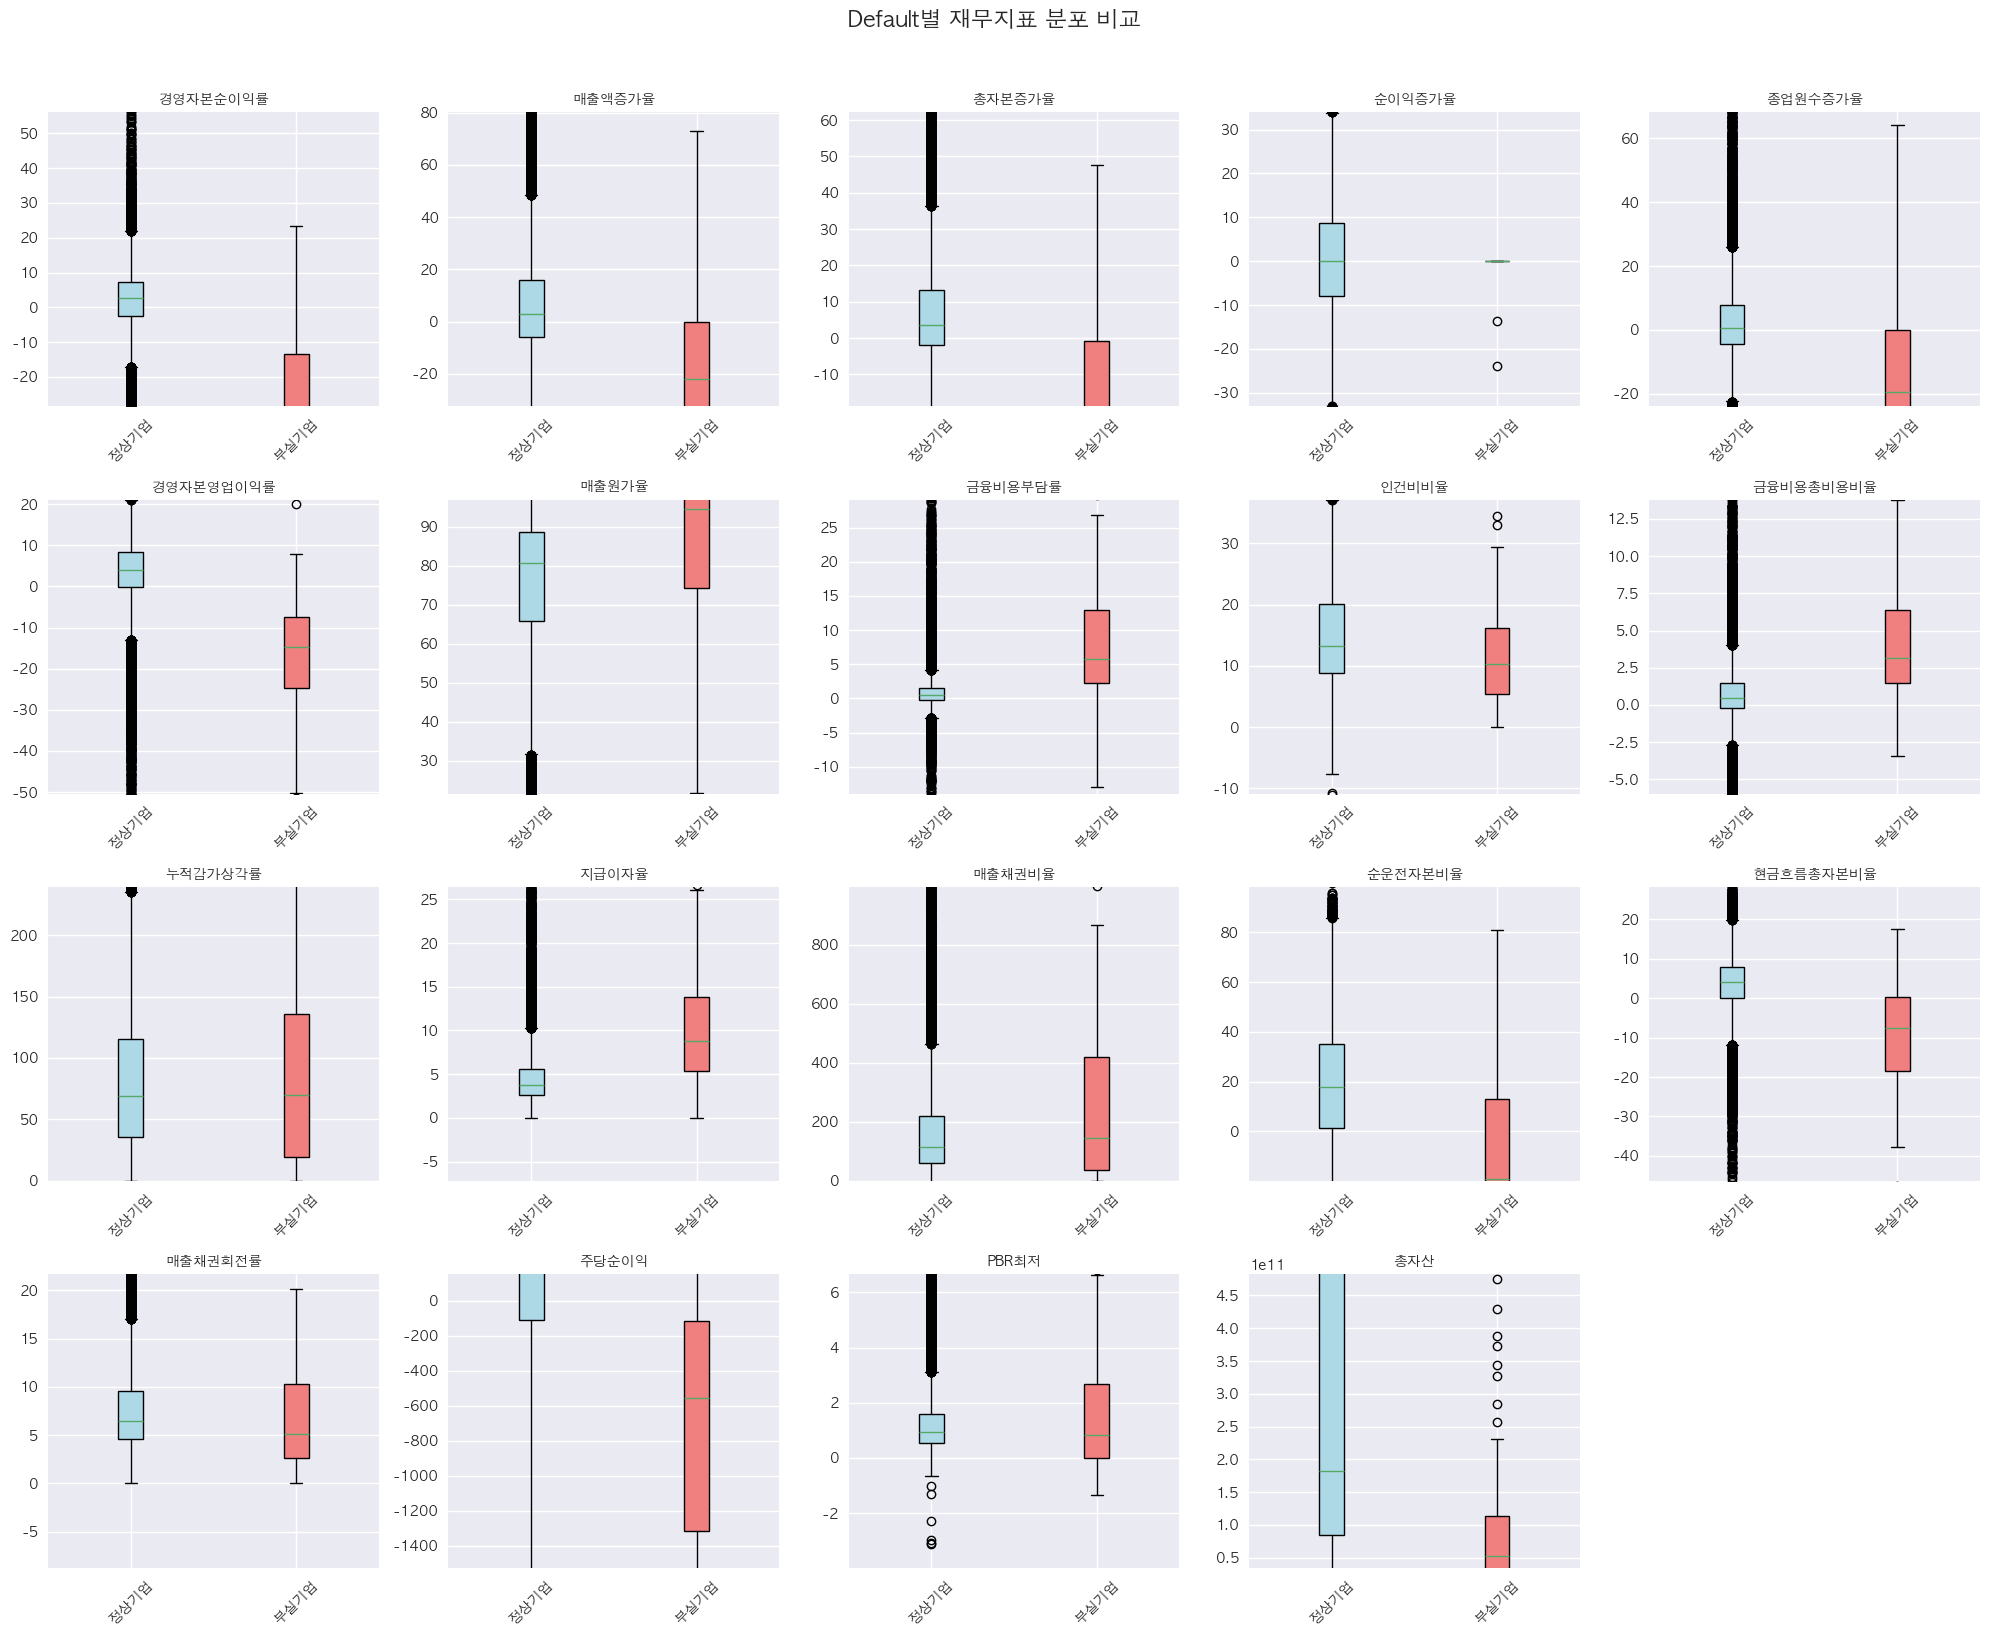


DefaultÎ≥Ñ ÌèâÍ∑†Í∞í Ï∞®Ïù¥ ÎπÑÍµê
                Ï†ïÏÉÅÍ∏∞ÏóÖ_ÌèâÍ∑†       Î∂ÄÏã§Í∏∞ÏóÖ_ÌèâÍ∑†      Ï†ïÏÉÅÍ∏∞ÏóÖ_Ï§ëÏúÑÏàò      Î∂ÄÏã§Í∏∞ÏóÖ_Ï§ëÏúÑÏàò  \
Í≤ΩÏòÅÏûêÎ≥∏ÏàúÏù¥ÏùµÎ•†   5.000000e-02 -4.369000e+01  2.710000e+00 -3.155000e+01   
Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®     2.137000e+01 -1.642000e+01  2.920000e+00 -2.180000e+01   
Ï¥ùÏûêÎ≥∏Ï¶ùÍ∞ÄÏú®     1.025000e+01 -1.764000e+01  3.620000e+00 -2.236000e+01   
ÏàúÏù¥ÏùµÏ¶ùÍ∞ÄÏú®     5.173000e+01 -7.601000e+01  0.000000e+00  0.000000e+00   
Ï¢ÖÏóÖÏõêÏàòÏ¶ùÍ∞ÄÏú®    4.770000e+00 -1.658000e+01  7.300000e-01 -1.947000e+01   
Í≤ΩÏòÅÏûêÎ≥∏ÏòÅÏóÖÏù¥ÏùµÎ•†  2.940000e+00 -1.864000e+01  3.920000e+00 -1.483000e+01   
Îß§Ï∂úÏõêÍ∞ÄÏú®      7.393000e+01  9.779000e+01  8.074000e+01  9.463000e+01   
Í∏àÏúµÎπÑÏö©Î∂ÄÎã¥Î•†    7.700000e-01  1.534000e+01  4.900000e-01  5.700000e+00   
Ïù∏Í±¥ÎπÑÎπÑÏú®      1.599000e+01  1.195000e+01  1.321000e+01  1.025000e+01   
Í∏àÏúµÎπÑÏö©Ï¥ùÎπÑÏö©ÎπÑÏú®  8.100000e-01  4.440000e+00  4.800000e-01  3.130000e+00   
ÎàÑÏ†ÅÍ∞êÍ∞ÄÏÉÅÍ∞

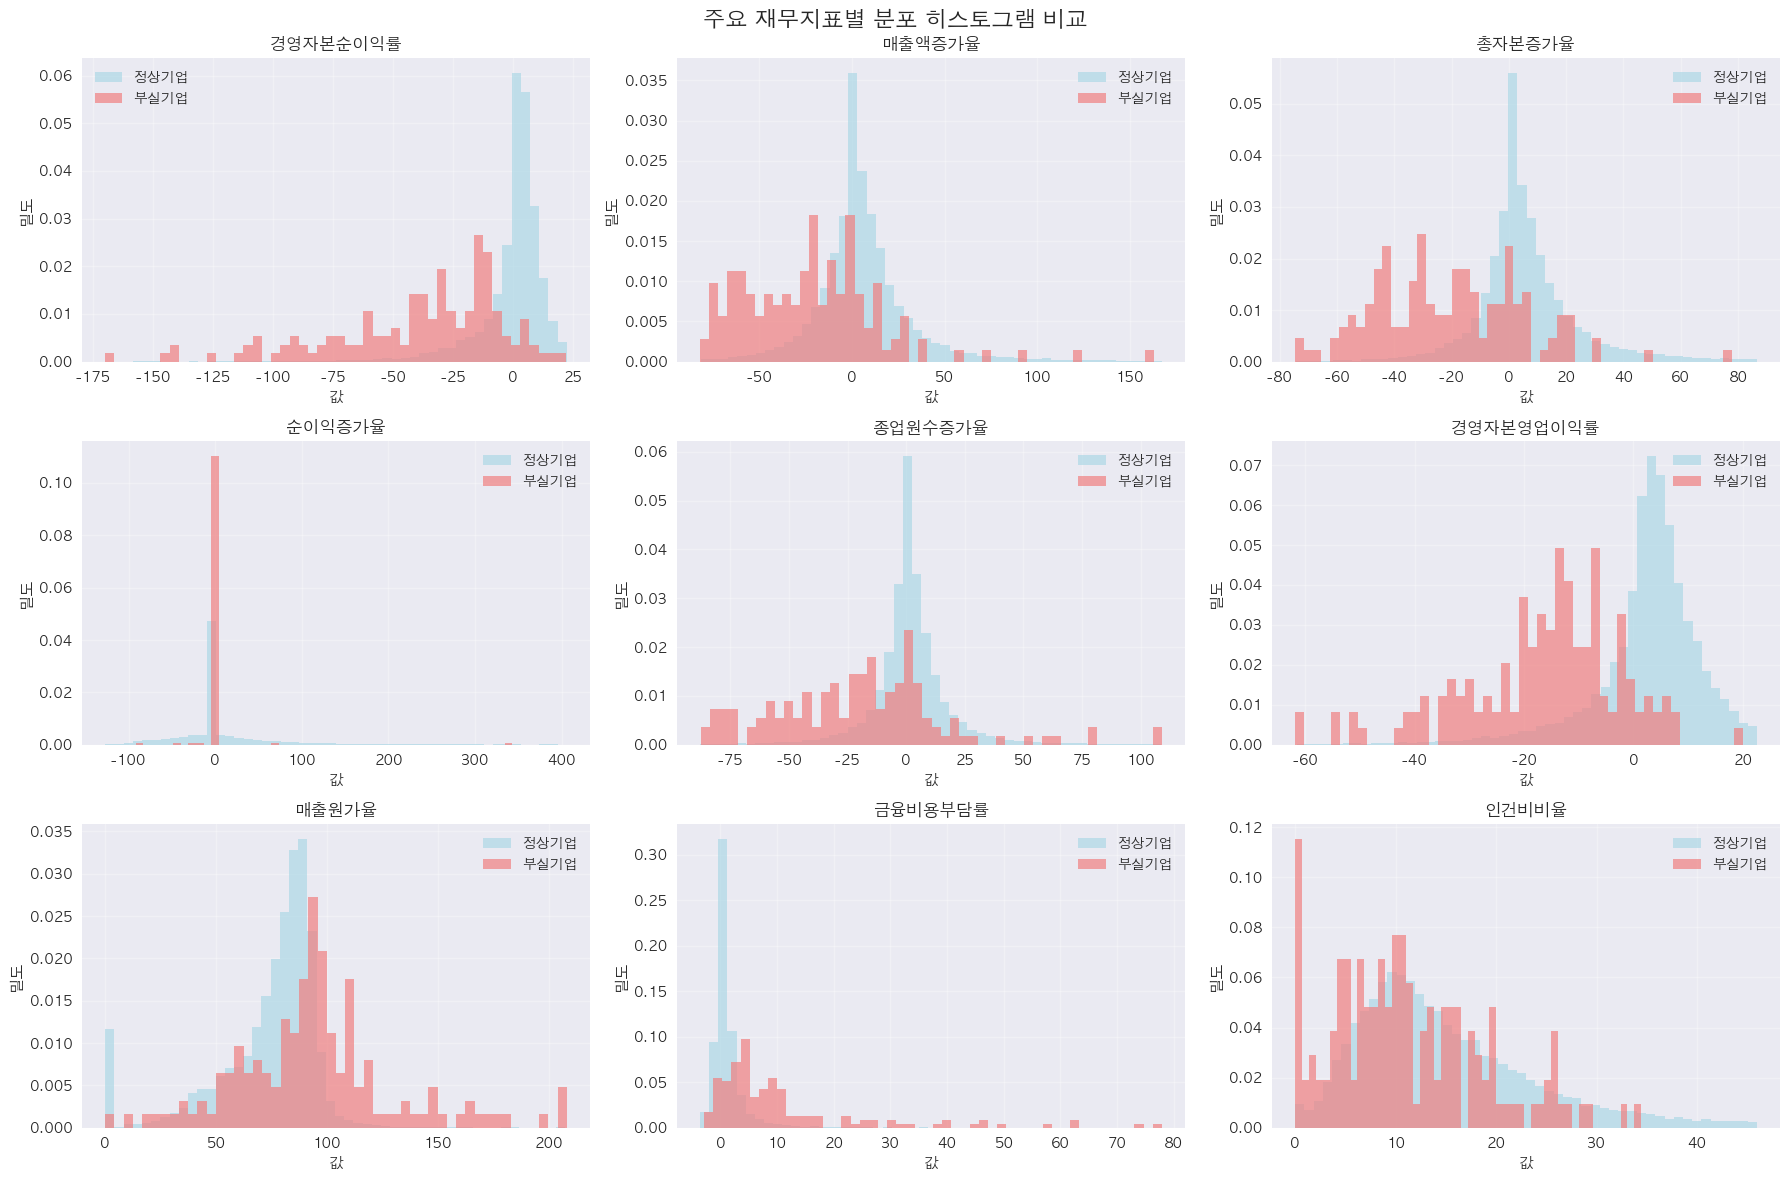

In [132]:
# defaultÎ≥Ñ Í∏∞Ïà†ÌÜµÍ≥ÑÎüâ ÎπÑÍµê Î∞è ÏãúÍ∞ÅÌôî
print("=" * 80)
print("DefaultÎ≥Ñ Í∏∞Ïà†ÌÜµÍ≥ÑÎüâ ÎπÑÍµê")
print("=" * 80)

# ÏõêÎ≥∏ FS Îç∞Ïù¥ÌÑ∞Î•º Îã§Ïãú Î°úÎìúÌïòÏó¨ default Ïª¨Îüº Ìè¨Ìï®
fs_with_default = pd.read_csv("/Users/jojongho/KDT/P2_Default-invest/data/processed/FS.csv")
fs_selected = fs_with_default[selected_features + ['default']]

# Default=0 (Ï†ïÏÉÅÍ∏∞ÏóÖ)Í≥º Default=1 (Î∂ÄÏã§Í∏∞ÏóÖ) Î∂ÑÎ¶¨
normal_companies = fs_selected[fs_selected['default'] == 0][selected_features]
default_companies = fs_selected[fs_selected['default'] == 1][selected_features]

print(f"\nÏ†ïÏÉÅÍ∏∞ÏóÖ Ïàò: {len(normal_companies):,}")
print(f"Î∂ÄÏã§Í∏∞ÏóÖ Ïàò: {len(default_companies):,}")

print("\n[Ï†ïÏÉÅÍ∏∞ÏóÖ (Default=0) Í∏∞Ïà†ÌÜµÍ≥ÑÎüâ]")
print(normal_companies.describe().round(2))

print("\n[Î∂ÄÏã§Í∏∞ÏóÖ (Default=1) Í∏∞Ïà†ÌÜµÍ≥ÑÎüâ]")
print(default_companies.describe().round(2))

# Ï∞®Ïù¥ ÏãúÍ∞ÅÌôî
import matplotlib.pyplot as plt
import seaborn as sns

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
import platform
import matplotlib.font_manager as fm

# Ïö¥ÏòÅÏ≤¥Ï†úÎ≥Ñ ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':  # Windows
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:  # Linux
    plt.rcParams['font.family'] = 'DejaVu Sans'

plt.rcParams['axes.unicode_minus'] = False

# ÌîºÏ≤ò ÏàòÏóê ÎßûÏ∂∞ ÎèôÏ†ÅÏúºÎ°ú Í∑∏Î¶¨Îìú ÏÑ§Ï†ï
n_features = len(selected_features)
n_cols = 5
n_rows = (n_features + n_cols - 1) // n_cols  # Ïò¨Î¶º Í≥ÑÏÇ∞

# ÏÑúÎ∏åÌîåÎ°Ø ÏÑ§Ï†ï
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
fig.suptitle('DefaultÎ≥Ñ Ïû¨Î¨¥ÏßÄÌëú Î∂ÑÌè¨ ÎπÑÍµê', fontsize=16, y=1.02)

# axesÎ•º 1Ï∞®Ïõê Î∞∞Ïó¥Î°ú Î≥ÄÌôò
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    ax = axes[i]
    
    # Î∞ïÏä§ÌîåÎ°ØÏúºÎ°ú Î∂ÑÌè¨ ÎπÑÍµê
    data_to_plot = [normal_companies[feature].dropna(), default_companies[feature].dropna()]
    labels = ['Ï†ïÏÉÅÍ∏∞ÏóÖ', 'Î∂ÄÏã§Í∏∞ÏóÖ']
    
    bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
    
    # ÏÉâÏÉÅ ÏÑ§Ï†ï
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    ax.set_title(feature, fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    
    # yÏ∂ï Î≤îÏúÑÎ•º Ï°∞Ï†ïÌïòÏó¨ Ïù¥ÏÉÅÏπò Ï†úÌïú
    q1_normal = normal_companies[feature].quantile(0.25)
    q3_normal = normal_companies[feature].quantile(0.75)
    q1_default = default_companies[feature].quantile(0.25)
    q3_default = default_companies[feature].quantile(0.75)
    
    iqr_normal = q3_normal - q1_normal
    iqr_default = q3_default - q1_default
    
    lower_bound = min(q1_normal - 1.5 * iqr_normal, q1_default - 1.5 * iqr_default)
    upper_bound = max(q3_normal + 1.5 * iqr_normal, q3_default + 1.5 * iqr_default)
    
    # Í∑πÎã®Ï†ÅÏù∏ Ïù¥ÏÉÅÏπò Ï†úÌïú
    if upper_bound > 100:
        upper_bound = min(upper_bound, normal_companies[feature].quantile(0.95), 
                         default_companies[feature].quantile(0.95))
    if lower_bound < -100:
        lower_bound = max(lower_bound, normal_companies[feature].quantile(0.05), 
                         default_companies[feature].quantile(0.05))
    
    ax.set_ylim(lower_bound, upper_bound)

# ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÎäî ÏÑúÎ∏åÌîåÎ°Ø Ïà®Í∏∞Í∏∞
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# ÌèâÍ∑†Í∞í Ï∞®Ïù¥ ÎπÑÍµêÌëú
print("\n" + "=" * 80)
print("DefaultÎ≥Ñ ÌèâÍ∑†Í∞í Ï∞®Ïù¥ ÎπÑÍµê")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Ï†ïÏÉÅÍ∏∞ÏóÖ_ÌèâÍ∑†': normal_companies.mean(),
    'Î∂ÄÏã§Í∏∞ÏóÖ_ÌèâÍ∑†': default_companies.mean(),
    'Ï†ïÏÉÅÍ∏∞ÏóÖ_Ï§ëÏúÑÏàò': normal_companies.median(),
    'Î∂ÄÏã§Í∏∞ÏóÖ_Ï§ëÏúÑÏàò': default_companies.median(),
})

comparison_df['ÌèâÍ∑†_Ï∞®Ïù¥'] = comparison_df['Î∂ÄÏã§Í∏∞ÏóÖ_ÌèâÍ∑†'] - comparison_df['Ï†ïÏÉÅÍ∏∞ÏóÖ_ÌèâÍ∑†']
comparison_df['Ï§ëÏúÑÏàò_Ï∞®Ïù¥'] = comparison_df['Î∂ÄÏã§Í∏∞ÏóÖ_Ï§ëÏúÑÏàò'] - comparison_df['Ï†ïÏÉÅÍ∏∞ÏóÖ_Ï§ëÏúÑÏàò']
comparison_df['ÌèâÍ∑†_ÎπÑÏú®'] = comparison_df['Î∂ÄÏã§Í∏∞ÏóÖ_ÌèâÍ∑†'] / comparison_df['Ï†ïÏÉÅÍ∏∞ÏóÖ_ÌèâÍ∑†']

print(comparison_df.round(2))

# ÌûàÏä§ÌÜ†Í∑∏Îû®ÏúºÎ°ú Î∂ÑÌè¨ ÎπÑÍµê (ÏÉÅÏúÑ 9Í∞ú ÏßÄÌëú)
n_hist_features = min(9, n_features)  # ÏµúÎåÄ 9Í∞úÍπåÏßÄÎßå ÌëúÏãú
hist_cols = 3
hist_rows = (n_hist_features + hist_cols - 1) // hist_cols

fig, axes = plt.subplots(hist_rows, hist_cols, figsize=(18, 4 * hist_rows))
fig.suptitle('Ï£ºÏöî Ïû¨Î¨¥ÏßÄÌëúÎ≥Ñ Î∂ÑÌè¨ ÌûàÏä§ÌÜ†Í∑∏Îû® ÎπÑÍµê', fontsize=16)

# axesÎ•º 1Ï∞®Ïõê Î∞∞Ïó¥Î°ú Î≥ÄÌôò
if hist_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

top_features = selected_features[:n_hist_features]  # ÏÉÅÏúÑ nÍ∞ú ÏßÄÌëú

for i, feature in enumerate(top_features):
    ax = axes[i]
    
    # ÌûàÏä§ÌÜ†Í∑∏Îû® Í∑∏Î¶¨Í∏∞ (Ïù¥ÏÉÅÏπò Ï†úÌïú)
    normal_data = normal_companies[feature].dropna()
    default_data = default_companies[feature].dropna()
    
    # 95% Î≤îÏúÑÎ°ú Ï†úÌïú
    lower_bound = min(normal_data.quantile(0.025), default_data.quantile(0.025))
    upper_bound = max(normal_data.quantile(0.975), default_data.quantile(0.975))
    
    normal_filtered = normal_data[(normal_data >= lower_bound) & (normal_data <= upper_bound)]
    default_filtered = default_data[(default_data >= lower_bound) & (default_data <= upper_bound)]
    
    ax.hist(normal_filtered, bins=50, alpha=0.7, label='Ï†ïÏÉÅÍ∏∞ÏóÖ', color='lightblue', density=True)
    ax.hist(default_filtered, bins=50, alpha=0.7, label='Î∂ÄÏã§Í∏∞ÏóÖ', color='lightcoral', density=True)
    
    ax.set_title(feature, fontsize=12)
    ax.set_xlabel('Í∞í')
    ax.set_ylabel('Î∞ÄÎèÑ')
    ax.legend()
    ax.grid(True, alpha=0.3)

# ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÎäî ÏÑúÎ∏åÌîåÎ°Ø Ïà®Í∏∞Í∏∞
for i in range(n_hist_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


In [133]:
import pandas as pd
import numpy as np
from scipy import stats

# Í∞ÄÏ†ï: 'normal_companies', 'default_companies', 'selected_features' Î≥ÄÏàòÍ∞Ä Ïù¥ÎØ∏ Ï†ïÏùòÎêòÏñ¥ ÏûàÎã§Í≥† Í∞ÄÏ†ïÌï©ÎãàÎã§.

# t-test Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏
ttest_results = []

for feature in selected_features:
    # Í∞Å Í∑∏Î£πÏùò Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú (Í≤∞Ï∏°Í∞í Ï†úÍ±∞)
    normal_data  = normal_companies[feature].dropna()
    default_data = default_companies[feature].dropna()
    
    # Ï∂©Î∂ÑÌïú ÌëúÎ≥∏ ÏàòÍ∞Ä ÏûàÏùÑ ÎïåÎßå ÏàòÌñâ
    if len(normal_data) > 1 and len(default_data) > 1:
        # Welch‚Äôs t-test (equal_var=False)
        t_stat, p_value = stats.ttest_ind(default_data, normal_data, equal_var=False)
        
        # Ìö®Í≥º ÌÅ¨Í∏∞ Í≥ÑÏÇ∞ (Cohen's d)
        pooled_std = np.sqrt(
            ((len(normal_data) - 1) * normal_data.var() +
             (len(default_data) - 1) * default_data.var()) /
            (len(normal_data) + len(default_data) - 2)
        )
        cohens_d = (
            (default_data.mean() - normal_data.mean()) / pooled_std
            if pooled_std > 0 else np.nan
        )
        
        ttest_results.append({
            'feature':      feature,
            'normal_mean':  normal_data.mean(),
            'default_mean': default_data.mean(),
            'mean_diff':    default_data.mean() - normal_data.mean(),
            't_statistic':  t_stat,
            'p_value':      p_value,           # 0~1 ÏÇ¨Ïù¥, Ï†àÎåìÍ∞í Ï∑®ÌïòÏßÄ ÏïäÏùå
            'cohens_d':     cohens_d,
            'significant':  (p_value < 0.05)
        })

# DataFrameÏúºÎ°ú Î≥ÄÌôò ÌõÑ p-value Ïò§Î¶ÑÏ∞®Ïàú Ï†ïÎ†¨
ttest_df = pd.DataFrame(ttest_results).sort_values('p_value')

# ÏöîÏïΩ Ï∂úÎ†•
print(f"Ï¥ù {len(selected_features)}Í∞ú ÏßÄÌëú Ï§ë Ïú†ÏùòÌïú Ï∞®Ïù¥Í∞Ä ÏûàÎäî ÏßÄÌëú: {ttest_df['significant'].sum()}Í∞ú")
print("="*120)
print(f"{'ÏßÄÌëúÎ™Ö':<20} {'Ï†ïÏÉÅÌèâÍ∑†':<10} {'Î∂ÄÏã§ÌèâÍ∑†':<10} {'ÌèâÍ∑†Ï∞®Ïù¥':<10} {'tÌÜµÍ≥ÑÎüâ':<10} {'p-value':<12} {'Cohen\'s d':<10} {'Ïú†ÏùòÏÑ±'}")
print("="*120)

for _, row in ttest_df.head(20).iterrows():
    # Ïú†ÏùòÏÑ± ÌëúÏãú
    if row['p_value'] < 0.001:
        sig = '***'
    elif row['p_value'] < 0.01:
        sig = '**'
    elif row['p_value'] < 0.05:
        sig = '*'
    else:
        sig = ''
    # p-value Ìè¨Îß∑ÌåÖ
    p_str = f"{row['p_value']:.2e}" if row['p_value'] < 1e-10 else f"{row['p_value']:.6f}"
    
    print(
        f"{row['feature']:<20} "
        f"{row['normal_mean']:<10.2f} "
        f"{row['default_mean']:<10.2f} "
        f"{row['mean_diff']:<10.2f} "
        f"{row['t_statistic']:<10.2f} "
        f"{p_str:<12} "
        f"{row['cohens_d']:<10.2f} "
        f"{sig}"
    )

print("\n*** p<0.001, ** p<0.01, * p<0.05")

# Ìö®Í≥º ÌÅ¨Í∏∞ ÌÅ∞ Ìï≠Î™© ÌôïÏù∏
large_effect = ttest_df[ttest_df['cohens_d'].abs() >= 0.8]
print(f"\nÌÅ∞ Ìö®Í≥º ÌÅ¨Í∏∞ (|d| >= 0.8): {len(large_effect)}Í∞ú")
for _, row in large_effect.iterrows():
    print(f"  {row['feature']}: d = {row['cohens_d']:.3f}")


Ï¥ù 19Í∞ú ÏßÄÌëú Ï§ë Ïú†ÏùòÌïú Ï∞®Ïù¥Í∞Ä ÏûàÎäî ÏßÄÌëú: 16Í∞ú
ÏßÄÌëúÎ™Ö                  Ï†ïÏÉÅÌèâÍ∑†       Î∂ÄÏã§ÌèâÍ∑†       ÌèâÍ∑†Ï∞®Ïù¥       tÌÜµÍ≥ÑÎüâ       p-value      Cohen's d  Ïú†ÏùòÏÑ±
Ï¥ùÏûêÏÇ∞                  1773915075957.85 165251721810.46 -1608663354147.39 -16.23     1.94e-55     -0.13      ***
Í≤ΩÏòÅÏûêÎ≥∏ÏòÅÏóÖÏù¥ÏùµÎ•†            2.94       -18.64     -21.58     -13.69     2.38e-28     -1.72      ***
Í≤ΩÏòÅÏûêÎ≥∏ÏàúÏù¥ÏùµÎ•†             0.05       -43.69     -43.74     -10.56     6.68e-20     -2.15      ***
Í∏àÏúµÎπÑÏö©Ï¥ùÎπÑÏö©ÎπÑÏú®            0.81       4.44       3.63       8.56       1.12e-14     1.22       ***
ÌòÑÍ∏àÌùêÎ¶ÑÏ¥ùÏûêÎ≥∏ÎπÑÏú®            3.34       -12.06     -15.41     -7.77      1.08e-12     -1.08      ***
ÏàúÏö¥Ï†ÑÏûêÎ≥∏ÎπÑÏú®              18.63      -26.17     -44.80     -7.51      4.63e-12     -1.61      ***
Ï¥ùÏûêÎ≥∏Ï¶ùÍ∞ÄÏú®               10.25      -17.64     -27.90     -7.32      1.27e-11     -0.71      ***
Îß§Ï∂úÏõêÍ∞ÄÏú®                7

In [134]:
# fsÏùò Í∞Å Ïª¨ÎüºÎ≥Ñ ÌïòÏúÑ 0.5%ÏôÄ ÏÉÅÏúÑ 0.5% Í∞í Ï∂úÎ†•
print("=" * 80)
print("Í∞Å Ïª¨ÎüºÎ≥Ñ ÌïòÏúÑ 0.5%ÏôÄ ÏÉÅÏúÑ 0.5% Í∞í")
print("=" * 80)

for column in fs.columns:
    lower_quantile = fs[column].quantile(0.005)
    upper_quantile = fs[column].quantile(0.995)
    
    print(f"\n{column}:")
    print(f"  ÌïòÏúÑ 0.5%: {lower_quantile:.2f}")
    print(f"  ÏÉÅÏúÑ 0.5%: {upper_quantile:.2f}")


Í∞Å Ïª¨ÎüºÎ≥Ñ ÌïòÏúÑ 0.5%ÏôÄ ÏÉÅÏúÑ 0.5% Í∞í

Í≤ΩÏòÅÏûêÎ≥∏ÏàúÏù¥ÏùµÎ•†:
  ÌïòÏúÑ 0.5%: -98.39
  ÏÉÅÏúÑ 0.5%: 46.30

Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®:
  ÌïòÏúÑ 0.5%: -76.24
  ÏÉÅÏúÑ 0.5%: 340.61

Ï¥ùÏûêÎ≥∏Ï¶ùÍ∞ÄÏú®:
  ÌïòÏúÑ 0.5%: -55.00
  ÏÉÅÏúÑ 0.5%: 220.65

ÏàúÏù¥ÏùµÏ¶ùÍ∞ÄÏú®:
  ÌïòÏúÑ 0.5%: -840.04
  ÏÉÅÏúÑ 0.5%: 1715.74

Ï¢ÖÏóÖÏõêÏàòÏ¶ùÍ∞ÄÏú®:
  ÌïòÏúÑ 0.5%: -76.33
  ÏÉÅÏúÑ 0.5%: 156.78

Í≤ΩÏòÅÏûêÎ≥∏ÏòÅÏóÖÏù¥ÏùµÎ•†:
  ÌïòÏúÑ 0.5%: -51.44
  ÏÉÅÏúÑ 0.5%: 35.79

Îß§Ï∂úÏõêÍ∞ÄÏú®:
  ÌïòÏúÑ 0.5%: 0.00
  ÏÉÅÏúÑ 0.5%: 133.43

Í∏àÏúµÎπÑÏö©Î∂ÄÎã¥Î•†:
  ÌïòÏúÑ 0.5%: -14.12
  ÏÉÅÏúÑ 0.5%: 38.01

Ïù∏Í±¥ÎπÑÎπÑÏú®:
  ÌïòÏúÑ 0.5%: 0.00
  ÏÉÅÏúÑ 0.5%: 63.79

Í∏àÏúµÎπÑÏö©Ï¥ùÎπÑÏö©ÎπÑÏú®:
  ÌïòÏúÑ 0.5%: -7.80
  ÏÉÅÏúÑ 0.5%: 13.97

ÎàÑÏ†ÅÍ∞êÍ∞ÄÏÉÅÍ∞ÅÎ•†:
  ÌïòÏúÑ 0.5%: 0.00
  ÏÉÅÏúÑ 0.5%: 545.60

ÏßÄÍ∏âÏù¥ÏûêÏú®:
  ÌïòÏúÑ 0.5%: 0.00
  ÏÉÅÏúÑ 0.5%: 139.25

Îß§Ï∂úÏ±ÑÍ∂åÎπÑÏú®:
  ÌïòÏúÑ 0.5%: 0.00
  ÏÉÅÏúÑ 0.5%: 48753.38

ÏàúÏö¥Ï†ÑÏûêÎ≥∏ÎπÑÏú®:
  ÌïòÏúÑ 0.5%: -53.54
  ÏÉÅÏúÑ 0.5%: 82.47

ÌòÑÍ∏àÌùêÎ¶ÑÏ¥ùÏûêÎ≥∏ÎπÑÏú®:
 

In [135]:
# Í∞Å Ïª¨ÎüºÎ≥Ñ 0Ïù∏ ÌñâÏóêÏÑúÏùò default Í∞úÏàò Ï∂úÎ†•
print("=" * 80)
print("Í∞Å Ïª¨ÎüºÎ≥Ñ 0Ïù∏ ÌñâÏùò default Í∞úÏàò")
print("=" * 80)

# ÏõêÎ≥∏ FS Îç∞Ïù¥ÌÑ∞Î•º Îã§Ïãú Î°úÎìúÌïòÏó¨ default Ïª¨Îüº Ìè¨Ìï®
fs_with_default = pd.read_csv("/Users/jojongho/KDT/P2_Default-invest/data/processed/FS.csv")

for column in fs.columns:
    # Ìï¥Îãπ Ïª¨ÎüºÏù¥ 0Ïù∏ ÌñâÎì§ Ï∞æÍ∏∞
    zero_mask = fs_with_default[column] == 0
    zero_rows = fs_with_default[zero_mask]
    
    # 0Ïù∏ ÌñâÎì§ Ï§ë defaultÍ∞Ä 1Ïù∏ Í∞úÏàò
    default_count_in_zeros = zero_rows['default'].sum()
    total_zeros = zero_mask.sum()
    
    print(f"\n{column}:")
    print(f"  0Ïù∏ ÌñâÏùò Ï¥ù Í∞úÏàò: {total_zeros:,}")
    print(f"  0Ïù∏ Ìñâ Ï§ë default=1Ïù∏ Í∞úÏàò: {default_count_in_zeros:,}")


Í∞Å Ïª¨ÎüºÎ≥Ñ 0Ïù∏ ÌñâÏùò default Í∞úÏàò

Í≤ΩÏòÅÏûêÎ≥∏ÏàúÏù¥ÏùµÎ•†:
  0Ïù∏ ÌñâÏùò Ï¥ù Í∞úÏàò: 7
  0Ïù∏ Ìñâ Ï§ë default=1Ïù∏ Í∞úÏàò: 0

Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®:
  0Ïù∏ ÌñâÏùò Ï¥ù Í∞úÏàò: 1,415
  0Ïù∏ Ìñâ Ï§ë default=1Ïù∏ Í∞úÏàò: 8

Ï¥ùÏûêÎ≥∏Ï¶ùÍ∞ÄÏú®:
  0Ïù∏ ÌñâÏùò Ï¥ù Í∞úÏàò: 1,383
  0Ïù∏ Ìñâ Ï§ë default=1Ïù∏ Í∞úÏàò: 8

ÏàúÏù¥ÏùµÏ¶ùÍ∞ÄÏú®:
  0Ïù∏ ÌñâÏùò Ï¥ù Í∞úÏàò: 9,541
  0Ïù∏ Ìñâ Ï§ë default=1Ïù∏ Í∞úÏàò: 144

Ï¢ÖÏóÖÏõêÏàòÏ¶ùÍ∞ÄÏú®:
  0Ïù∏ ÌñâÏùò Ï¥ù Í∞úÏàò: 1,598
  0Ïù∏ Ìñâ Ï§ë default=1Ïù∏ Í∞úÏàò: 9

Í≤ΩÏòÅÏûêÎ≥∏ÏòÅÏóÖÏù¥ÏùµÎ•†:
  0Ïù∏ ÌñâÏùò Ï¥ù Í∞úÏàò: 2
  0Ïù∏ Ìñâ Ï§ë default=1Ïù∏ Í∞úÏàò: 0

Îß§Ï∂úÏõêÍ∞ÄÏú®:
  0Ïù∏ ÌñâÏùò Ï¥ù Í∞úÏàò: 1,019
  0Ïù∏ Ìñâ Ï§ë default=1Ïù∏ Í∞úÏàò: 1

Í∏àÏúµÎπÑÏö©Î∂ÄÎã¥Î•†:
  0Ïù∏ ÌñâÏùò Ï¥ù Í∞úÏàò: 118
  0Ïù∏ Ìñâ Ï§ë default=1Ïù∏ Í∞úÏàò: 5

Ïù∏Í±¥ÎπÑÎπÑÏú®:
  0Ïù∏ ÌñâÏùò Ï¥ù Í∞úÏàò: 162
  0Ïù∏ Ìñâ Ï§ë default=1Ïù∏ Í∞úÏàò: 12

Í∏àÏúµÎπÑÏö©Ï¥ùÎπÑÏö©ÎπÑÏú®:
  0Ïù∏ ÌñâÏùò Ï¥ù Í∞úÏàò: 101
  0Ïù∏ Ìñâ Ï§ë default=1Ïù∏ Í∞úÏàò: 5

ÎàÑÏ†ÅÍ∞êÍ∞ÄÏÉÅÍ∞ÅÎ•†:
  0Ïù∏ ÌñâÏù

# FS2_feature.csv ÌõëÏñ¥Î≥¥Í∏∞

In [141]:
import pandas as pd

df = pd.read_csv('/Users/jojongho/KDT/P2_Default-invest/data/processed/FS2_features.csv')
# Ïª¨ÎüºÎ≥Ñ Í≤∞Ï∏°Ïπò ÎπÑÏú® Î∂ÑÏÑù
print("=" * 80)
print("Ïª¨ÎüºÎ≥Ñ Í≤∞Ï∏°Ïπò ÎπÑÏú®")
print("=" * 80)

# Í≤∞Ï∏°Ïπò ÎπÑÏú® Í≥ÑÏÇ∞
missing_ratio = df.isnull().sum() / len(df) * 100

# Í≤∞Ï∏°ÏπòÍ∞Ä ÏûàÎäî Ïª¨ÎüºÎßå ÌïÑÌÑ∞ÎßÅÌïòÍ≥† ÎπÑÏú® Í∏∞Ï§ÄÏúºÎ°ú ÎÇ¥Î¶ºÏ∞®Ïàú Ï†ïÎ†¨
missing_ratio_filtered = missing_ratio[missing_ratio > 0].sort_values(ascending=False)

print(f"Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Ìñâ Ïàò: {len(df):,}")
print(f"Ï†ÑÏ≤¥ Ïª¨Îüº Ïàò: {len(df.columns):,}")
print(f"Í≤∞Ï∏°ÏπòÍ∞Ä ÏûàÎäî Ïª¨Îüº Ïàò: {len(missing_ratio_filtered):,}")
print("\n" + "-" * 60)

# Í≤∞Ï∏°Ïπò ÎπÑÏú®Î≥ÑÎ°ú Í∑∏Î£πÌôîÌïòÏó¨ Ï∂úÎ†•
print("\nüìä Í≤∞Ï∏°Ïπò ÎπÑÏú®Î≥Ñ Ïª¨Îüº ÌòÑÌô©:")
high_missing = missing_ratio_filtered[missing_ratio_filtered >= 50]
medium_missing = missing_ratio_filtered[(missing_ratio_filtered >= 10) & (missing_ratio_filtered < 50)]
low_missing = missing_ratio_filtered[missing_ratio_filtered < 10]

print(f"  ‚Ä¢ ÎÜíÏùÄ Í≤∞Ï∏°Ïπò (‚â•50%): {len(high_missing)}Í∞ú Ïª¨Îüº")
print(f"  ‚Ä¢ Ï§ëÍ∞Ñ Í≤∞Ï∏°Ïπò (10-50%): {len(medium_missing)}Í∞ú Ïª¨Îüº")
print(f"  ‚Ä¢ ÎÇÆÏùÄ Í≤∞Ï∏°Ïπò (<10%): {len(low_missing)}Í∞ú Ïª¨Îüº")

# ÏÉÅÏúÑ 20Í∞ú Í≤∞Ï∏°Ïπò ÎπÑÏú® Ïª¨Îüº Ï∂úÎ†•
print(f"\nüìã Í≤∞Ï∏°Ïπò ÎπÑÏú® ÏÉÅÏúÑ 20Í∞ú Ïª¨Îüº:")
print("-" * 60)
for i, (col, ratio) in enumerate(missing_ratio_filtered.head(20).items(), 1):
    print(f"{i:2d}. {col:<35} : {ratio:6.2f}%")

# Í≤∞Ï∏°Ïπò ÎπÑÏú®Ïù¥ ÎÜíÏùÄ Ïª¨ÎüºÎì§Ïùò ÌäπÏÑ± Î∂ÑÏÑù
if len(high_missing) > 0:
    print(f"\n‚ö†Ô∏è  ÎÜíÏùÄ Í≤∞Ï∏°Ïπò ÎπÑÏú® (‚â•50%) Ïª¨ÎüºÎì§:")
    print("-" * 60)
    for col, ratio in high_missing.items():
        print(f"   {col:<35} : {ratio:6.2f}%")


Ïª¨ÎüºÎ≥Ñ Í≤∞Ï∏°Ïπò ÎπÑÏú®
Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Ìñâ Ïàò: 24,535
Ï†ÑÏ≤¥ Ïª¨Îüº Ïàò: 98
Í≤∞Ï∏°ÏπòÍ∞Ä ÏûàÎäî Ïª¨Îüº Ïàò: 94

------------------------------------------------------------

üìä Í≤∞Ï∏°Ïπò ÎπÑÏú®Î≥Ñ Ïª¨Îüº ÌòÑÌô©:
  ‚Ä¢ ÎÜíÏùÄ Í≤∞Ï∏°Ïπò (‚â•50%): 1Í∞ú Ïª¨Îüº
  ‚Ä¢ Ï§ëÍ∞Ñ Í≤∞Ï∏°Ïπò (10-50%): 53Í∞ú Ïª¨Îüº
  ‚Ä¢ ÎÇÆÏùÄ Í≤∞Ï∏°Ïπò (<10%): 40Í∞ú Ïª¨Îüº

üìã Í≤∞Ï∏°Ïπò ÎπÑÏú® ÏÉÅÏúÑ 20Í∞ú Ïª¨Îüº:
------------------------------------------------------------
 1. 3ÎÖÑÏàòÏùµÎ•†                               :  51.84%
 2. 2ÎÖÑÏàòÏùµÎ•†                               :  44.96%
 3. ŒîPER                                :  39.71%
 4. ŒîPCR                                :  39.64%
 5. ŒîPSR                                :  39.49%
 6. ŒîPBR                                :  38.96%
 7. 1ÎÖÑÏàòÏùµÎ•†                               :  37.80%
 8. ÏãúÍ∞ÄÏ¥ùÏï°Ï¶ùÍ∞ÄÏú®                             :  37.80%
 9. ŒîDOL                                :  36.10%
10. PEG                                 :  35.9

In [4]:
import pandas as pd

# Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞ÏôÄÏùò Îß§Ïπ≠ Î∂ÑÏÑù
print("=" * 80)
print("FS2_featuresÏôÄ Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞ Îß§Ïπ≠ Î∂ÑÏÑù")
print("=" * 80)

# Ïó∞ÎèÑÎ≥Ñ Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Í≤∞Ìï©
df = pd.read_csv('/Users/jojongho/KDT/P2_Default-invest/data/processed/FS2_features.csv')

yearly_data = []
from pathlib import Path
data_dir = Path('/Users/jojongho/KDT/P2_Default-invest/data/raw')

for year in range(2012, 2024):
    year_file = data_dir / f"{year}.csv"
    if year_file.exists():
        year_df = pd.read_csv(year_file, encoding='utf-8-sig')
        
        # Í±∞ÎûòÏÜåÏΩîÎìúÎ•º Î¨∏ÏûêÌòïÏúºÎ°ú ÌÜµÏùº
        year_df['Í±∞ÎûòÏÜåÏΩîÎìú'] = year_df['Í±∞ÎûòÏÜåÏΩîÎìú'].astype(str)
        year_df['Ïó∞ÎèÑ'] = year
        
        # ÏùºÏûê Ïª¨Îüº Ï≤òÎ¶¨
        if 'Îß§Îß§ÎÖÑÏõîÏùº' in year_df.columns:
            year_df['ÏùºÏûê'] = pd.to_datetime(year_df['Îß§Îß§ÎÖÑÏõîÏùº'])
        elif 'ÌöåÍ≥ÑÎÖÑÎèÑ' in year_df.columns:
            year_df['ÏùºÏûê'] = pd.to_datetime(year_df['ÌöåÍ≥ÑÎÖÑÎèÑ'])
        
        # Í±∞ÎûòÏÜåÏΩîÎìúÎ≥ÑÎ°ú ÎßàÏßÄÎßâ Í±∞ÎûòÏùº Îç∞Ïù¥ÌÑ∞Îßå ÏÑ†ÌÉù (Ïó∞Îßê Îç∞Ïù¥ÌÑ∞)
        if 'Í±∞ÎûòÏÜåÏΩîÎìú' in year_df.columns and 'ÏùºÏûê' in year_df.columns:
            year_end_df = year_df.loc[year_df.groupby('Í±∞ÎûòÏÜåÏΩîÎìú')['ÏùºÏûê'].idxmax()].copy()
            yearly_data.append(year_end_df[['Í±∞ÎûòÏÜåÏΩîÎìú', 'Ïó∞ÎèÑ']])
            print(f"{year}.csv Î°úÎìú ÏôÑÎ£å: {len(year_end_df):,} Í∏∞ÏóÖ")

# Î™®Îì† Ïó∞ÎèÑÎ≥Ñ Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞ Í≤∞Ìï©
if yearly_data:
    price_df = pd.concat(yearly_data, ignore_index=True)
    price_df['Ïó∞ÎèÑ'] = price_df['Ïó∞ÎèÑ'].astype('Int64')
    
    print(f"\nÍ≤∞Ìï©Îêú Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞: {len(price_df):,} Ìñâ")
    print(f"Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞ Ïó∞ÎèÑ Î≤îÏúÑ: {price_df['Ïó∞ÎèÑ'].min()} ~ {price_df['Ïó∞ÎèÑ'].max()}")
    print(f"Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞ Í≥†Ïú† Í∏∞ÏóÖ Ïàò: {price_df['Í±∞ÎûòÏÜåÏΩîÎìú'].nunique():,} Í∞ú")

# FS2_features Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
df['Í±∞ÎûòÏÜåÏΩîÎìú'] = df['Í±∞ÎûòÏÜåÏΩîÎìú'].astype(str)
df['Ïó∞ÎèÑ'] = df['Ïó∞ÎèÑ'].astype('Int64')

print(f"\nFS2_features Îç∞Ïù¥ÌÑ∞: {len(df):,} Ìñâ")
print(f"FS2_features Ïó∞ÎèÑ Î≤îÏúÑ: {df['Ïó∞ÎèÑ'].min()} ~ {df['Ïó∞ÎèÑ'].max()}")
print(f"FS2_features Í≥†Ïú† Í∏∞ÏóÖ Ïàò: {df['Í±∞ÎûòÏÜåÏΩîÎìú'].nunique():,} Í∞ú")

# Îß§Ïπ≠ ÌÇ§ ÏÉùÏÑ± Î∞è ÎπÑÍµê
fs2_keys = set(df[['Í±∞ÎûòÏÜåÏΩîÎìú', 'Ïó∞ÎèÑ']].apply(tuple, axis=1))
price_keys = set(price_df[['Í±∞ÎûòÏÜåÏΩîÎìú', 'Ïó∞ÎèÑ']].apply(tuple, axis=1))
common_keys = fs2_keys.intersection(price_keys)

print("\n" + "=" * 60)
print("üìä Îß§Ïπ≠ Î∂ÑÏÑù Í≤∞Í≥º")
print("=" * 60)
print(f"FS2_features ÌÇ§ Í∞úÏàò: {len(fs2_keys):,}")
print(f"Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞ ÌÇ§ Í∞úÏàò: {len(price_keys):,}")
print(f"Í≥µÌÜµ ÌÇ§ Í∞úÏàò: {len(common_keys):,}")
print(f"Îß§Ïπ≠Î•† (FS2 Í∏∞Ï§Ä): {len(common_keys)/len(fs2_keys)*100:.2f}%")
print(f"Îß§Ïπ≠Î•† (Ï£ºÍ∞Ä Í∏∞Ï§Ä): {len(common_keys)/len(price_keys)*100:.2f}%")

# Îß§Ïπ≠ÎêòÏßÄ ÏïäÎäî Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù
fs2_only = fs2_keys - price_keys
price_only = price_keys - fs2_keys

print(f"\nüîç Îß§Ïπ≠ÎêòÏßÄ ÏïäÎäî Îç∞Ïù¥ÌÑ∞:")
print(f"FS2ÏóêÎßå ÏûàÎäî ÌÇ§: {len(fs2_only):,} Í∞ú")
print(f"Ï£ºÍ∞ÄÏóêÎßå ÏûàÎäî ÌÇ§: {len(price_only):,} Í∞ú")

# Ïó∞ÎèÑÎ≥Ñ Îß§Ïπ≠ ÌòÑÌô©
print(f"\nüìÖ Ïó∞ÎèÑÎ≥Ñ Îß§Ïπ≠ ÌòÑÌô©:")
print("-" * 60)
for year in sorted(df['Ïó∞ÎèÑ'].unique()):
    if pd.notna(year):
        fs2_year = df[df['Ïó∞ÎèÑ'] == year]['Í±∞ÎûòÏÜåÏΩîÎìú'].nunique()
        price_year = price_df[price_df['Ïó∞ÎèÑ'] == year]['Í±∞ÎûòÏÜåÏΩîÎìú'].nunique() if year in price_df['Ïó∞ÎèÑ'].values else 0
        
        # Ìï¥Îãπ Ïó∞ÎèÑ Í≥µÌÜµ Í∏∞ÏóÖ Ïàò
        fs2_year_keys = set(df[df['Ïó∞ÎèÑ'] == year]['Í±∞ÎûòÏÜåÏΩîÎìú'])
        price_year_keys = set(price_df[price_df['Ïó∞ÎèÑ'] == year]['Í±∞ÎûòÏÜåÏΩîÎìú']) if year in price_df['Ïó∞ÎèÑ'].values else set()
        common_year = len(fs2_year_keys.intersection(price_year_keys))
        
        match_rate = (common_year / fs2_year * 100) if fs2_year > 0 else 0
        print(f"{year}: FS2={fs2_year:,}, Ï£ºÍ∞Ä={price_year:,}, Í≥µÌÜµ={common_year:,} ({match_rate:.1f}%)")

# Îß§Ïπ≠ÎêòÏßÄ ÏïäÎäî ÏÉòÌîå Í∏∞ÏóÖÎì§ Ï∂úÎ†•
if len(fs2_only) > 0:
    print(f"\n‚ùå FS2ÏóêÎßå ÏûàÎäî Í∏∞ÏóÖ ÏÉòÌîå (ÏÉÅÏúÑ 10Í∞ú):")
    fs2_only_list = list(fs2_only)[:10]
    for code, year in fs2_only_list:
        company_name = df[(df['Í±∞ÎûòÏÜåÏΩîÎìú'] == code) & (df['Ïó∞ÎèÑ'] == year)]['ÌöåÏÇ¨Î™Ö'].iloc[0] if len(df[(df['Í±∞ÎûòÏÜåÏΩîÎìú'] == code) & (df['Ïó∞ÎèÑ'] == year)]) > 0 else "Unknown"
        print(f"  {code} ({year}): {company_name}")

if len(price_only) > 0:
    print(f"\n‚ùå Ï£ºÍ∞ÄÏóêÎßå ÏûàÎäî Í∏∞ÏóÖ ÏÉòÌîå (ÏÉÅÏúÑ 10Í∞ú):")
    price_only_list = list(price_only)[:10]
    for code, year in price_only_list:
        print(f"  {code} ({year})")


FS2_featuresÏôÄ Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞ Îß§Ïπ≠ Î∂ÑÏÑù
2012.csv Î°úÎìú ÏôÑÎ£å: 1,430 Í∏∞ÏóÖ
2013.csv Î°úÎìú ÏôÑÎ£å: 1,421 Í∏∞ÏóÖ
2014.csv Î°úÎìú ÏôÑÎ£å: 1,439 Í∏∞ÏóÖ
2015.csv Î°úÎìú ÏôÑÎ£å: 1,524 Í∏∞ÏóÖ
2016.csv Î°úÎìú ÏôÑÎ£å: 1,531 Í∏∞ÏóÖ
2017.csv Î°úÎìú ÏôÑÎ£å: 1,616 Í∏∞ÏóÖ
2018.csv Î°úÎìú ÏôÑÎ£å: 1,673 Í∏∞ÏóÖ
2019.csv Î°úÎìú ÏôÑÎ£å: 1,722 Í∏∞ÏóÖ
2020.csv Î°úÎìú ÏôÑÎ£å: 1,780 Í∏∞ÏóÖ
2021.csv Î°úÎìú ÏôÑÎ£å: 1,852 Í∏∞ÏóÖ
2022.csv Î°úÎìú ÏôÑÎ£å: 1,921 Í∏∞ÏóÖ
2023.csv Î°úÎìú ÏôÑÎ£å: 1,997 Í∏∞ÏóÖ

Í≤∞Ìï©Îêú Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞: 19,906 Ìñâ
Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞ Ïó∞ÎèÑ Î≤îÏúÑ: 2012 ~ 2023
Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞ Í≥†Ïú† Í∏∞ÏóÖ Ïàò: 2,299 Í∞ú

FS2_features Îç∞Ïù¥ÌÑ∞: 24,535 Ìñâ
FS2_features Ïó∞ÎèÑ Î≤îÏúÑ: 2011 ~ 2023
FS2_features Í≥†Ïú† Í∏∞ÏóÖ Ïàò: 2,715 Í∞ú

üìä Îß§Ïπ≠ Î∂ÑÏÑù Í≤∞Í≥º
FS2_features ÌÇ§ Í∞úÏàò: 24,525
Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞ ÌÇ§ Í∞úÏàò: 19,906
Í≥µÌÜµ ÌÇ§ Í∞úÏàò: 17,160
Îß§Ïπ≠Î•† (FS2 Í∏∞Ï§Ä): 69.97%
Îß§Ïπ≠Î•† (Ï£ºÍ∞Ä Í∏∞Ï§Ä): 86.21%

üîç Îß§Ïπ≠ÎêòÏßÄ ÏïäÎäî Îç∞Ïù¥ÌÑ∞:
FS2ÏóêÎßå ÏûàÎäî ÌÇ§: 7,365 Í∞ú
Ï£ºÍ∞Ä

In [7]:
# %% cell 48 code
# ÏãúÍ∞ÄÏ¥ùÏï° Îç∞Ïù¥ÌÑ∞ÏôÄÏùò Îß§Ïπ≠ Î∂ÑÏÑù
print("\n" + "="*80)
print("üí∞ ÏãúÍ∞ÄÏ¥ùÏï° Îç∞Ïù¥ÌÑ∞ Îß§Ïπ≠ Î∂ÑÏÑù")
print("="*80)

# ÏãúÍ∞ÄÏ¥ùÏï° Îç∞Ïù¥ÌÑ∞ Î°úÎìú
market_cap_path = "../data/processed/ÏãúÍ∞ÄÏ¥ùÏï°.csv"
try:
    market_cap_df = pd.read_csv(market_cap_path, encoding='utf-8-sig')
    if 'ÌöåÍ≥ÑÎÖÑÎèÑ' in market_cap_df.columns:
        market_cap_df = market_cap_df.rename(columns={'ÌöåÍ≥ÑÎÖÑÎèÑ': 'Ïó∞ÎèÑ'})
    
    # Í±∞ÎûòÏÜåÏΩîÎìú ÌÉÄÏûÖ ÌÜµÏùº
    market_cap_df['Í±∞ÎûòÏÜåÏΩîÎìú'] = market_cap_df['Í±∞ÎûòÏÜåÏΩîÎìú'].astype(str)
    market_cap_df['Ïó∞ÎèÑ'] = pd.to_numeric(market_cap_df['Ïó∞ÎèÑ'], errors='coerce').astype('Int64')
    
    print(f"üìä ÏãúÍ∞ÄÏ¥ùÏï° Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: {len(market_cap_df):,} Ìñâ")
    print(f"ÏãúÍ∞ÄÏ¥ùÏï° Ïó∞ÎèÑ Î≤îÏúÑ: {market_cap_df['Ïó∞ÎèÑ'].min()} ~ {market_cap_df['Ïó∞ÎèÑ'].max()}")
    print(f"ÏãúÍ∞ÄÏ¥ùÏï° Í≥†Ïú† Í∏∞ÏóÖ Ïàò: {market_cap_df['Í±∞ÎûòÏÜåÏΩîÎìú'].nunique():,} Í∞ú")
    
    # ÌÇ§ ÏÉùÏÑ±
    fs2_keys = set(df[['Í±∞ÎûòÏÜåÏΩîÎìú', 'Ïó∞ÎèÑ']].apply(tuple, axis=1))
    market_cap_keys = set(market_cap_df[['Í±∞ÎûòÏÜåÏΩîÎìú', 'Ïó∞ÎèÑ']].apply(tuple, axis=1))
    common_keys_mc = fs2_keys.intersection(market_cap_keys)
    
    print("\nüìä Îß§Ïπ≠ Î∂ÑÏÑù Í≤∞Í≥º")
    print("=" * 60)
    print(f"FS2_features ÌÇ§ Í∞úÏàò: {len(fs2_keys):,}")
    print(f"ÏãúÍ∞ÄÏ¥ùÏï° Îç∞Ïù¥ÌÑ∞ ÌÇ§ Í∞úÏàò: {len(market_cap_keys):,}")
    print(f"Í≥µÌÜµ ÌÇ§ Í∞úÏàò: {len(common_keys_mc):,}")
    print(f"Îß§Ïπ≠Î•† (FS2 Í∏∞Ï§Ä): {len(common_keys_mc)/len(fs2_keys)*100:.2f}%")
    print(f"Îß§Ïπ≠Î•† (ÏãúÍ∞ÄÏ¥ùÏï° Í∏∞Ï§Ä): {len(common_keys_mc)/len(market_cap_keys)*100:.2f}%")
    
    # Îß§Ïπ≠ÎêòÏßÄ ÏïäÎäî Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù
    fs2_only_mc = fs2_keys - market_cap_keys
    mc_only = market_cap_keys - fs2_keys
    
    print(f"\nüîç Îß§Ïπ≠ÎêòÏßÄ ÏïäÎäî Îç∞Ïù¥ÌÑ∞:")
    print(f"FS2ÏóêÎßå ÏûàÎäî ÌÇ§: {len(fs2_only_mc):,} Í∞ú")
    print(f"ÏãúÍ∞ÄÏ¥ùÏï°ÏóêÎßå ÏûàÎäî ÌÇ§: {len(mc_only):,} Í∞ú")
    
    # Ïó∞ÎèÑÎ≥Ñ Îß§Ïπ≠ ÌòÑÌô©
    print(f"\nüìÖ Ïó∞ÎèÑÎ≥Ñ Îß§Ïπ≠ ÌòÑÌô©:")
    print("-" * 60)
    for year in sorted(df['Ïó∞ÎèÑ'].unique()):
        if pd.notna(year):
            fs2_year = df[df['Ïó∞ÎèÑ'] == year]['Í±∞ÎûòÏÜåÏΩîÎìú'].nunique()
            mc_year = market_cap_df[market_cap_df['Ïó∞ÎèÑ'] == year]['Í±∞ÎûòÏÜåÏΩîÎìú'].nunique() if year in market_cap_df['Ïó∞ÎèÑ'].values else 0
            
            # Ìï¥Îãπ Ïó∞ÎèÑ Í≥µÌÜµ Í∏∞ÏóÖ Ïàò
            fs2_year_keys = set(df[df['Ïó∞ÎèÑ'] == year]['Í±∞ÎûòÏÜåÏΩîÎìú'])
            mc_year_keys = set(market_cap_df[market_cap_df['Ïó∞ÎèÑ'] == year]['Í±∞ÎûòÏÜåÏΩîÎìú']) if year in market_cap_df['Ïó∞ÎèÑ'].values else set()
            common_year_mc = len(fs2_year_keys.intersection(mc_year_keys))
            
            match_rate_mc = (common_year_mc / fs2_year * 100) if fs2_year > 0 else 0
            print(f"{year}: FS2={fs2_year:,}, ÏãúÍ∞ÄÏ¥ùÏï°={mc_year:,}, Í≥µÌÜµ={common_year_mc:,} ({match_rate_mc:.1f}%)")
    
    # Îß§Ïπ≠ÎêòÏßÄ ÏïäÎäî ÏÉòÌîå Í∏∞ÏóÖÎì§ Ï∂úÎ†•
    if len(fs2_only_mc) > 0:
        print(f"\n‚ùå FS2ÏóêÎßå ÏûàÎäî Í∏∞ÏóÖ ÏÉòÌîå (ÏÉÅÏúÑ 10Í∞ú):")
        fs2_only_mc_list = list(fs2_only_mc)[:10]
        for code, year in fs2_only_mc_list:
            company_name = df[(df['Í±∞ÎûòÏÜåÏΩîÎìú'] == code) & (df['Ïó∞ÎèÑ'] == year)]['ÌöåÏÇ¨Î™Ö'].iloc[0] if len(df[(df['Í±∞ÎûòÏÜåÏΩîÎìú'] == code) & (df['Ïó∞ÎèÑ'] == year)]) > 0 else "Unknown"
            print(f"  {code} ({year}): {company_name}")
    
    if len(mc_only) > 0:
        print(f"\n‚ùå ÏãúÍ∞ÄÏ¥ùÏï°ÏóêÎßå ÏûàÎäî Í∏∞ÏóÖ ÏÉòÌîå (ÏÉÅÏúÑ 10Í∞ú):")
        mc_only_list = list(mc_only)[:10]
        for code, year in mc_only_list:
            print(f"  {code} ({year})")

except FileNotFoundError:
    print("‚ö†Ô∏è ÏãúÍ∞ÄÏ¥ùÏï°.csv ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")
except Exception as e:
    print(f"‚ö†Ô∏è ÏãúÍ∞ÄÏ¥ùÏï° Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")

# 3Í∞ú Îç∞Ïù¥ÌÑ∞ÏÖã ÍµêÏßëÌï© Î∂ÑÏÑù
print("\n" + "="*80)
print("üîÑ Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÏÖã ÍµêÏßëÌï© Î∂ÑÏÑù")
print("="*80)

try:
    # 3Í∞ú Îç∞Ïù¥ÌÑ∞ÏÖãÏùò ÍµêÏßëÌï©
    all_common_keys = fs2_keys.intersection(price_keys).intersection(market_cap_keys)
    
    print(f"üìä Ï†ÑÏ≤¥ ÍµêÏßëÌï© Î∂ÑÏÑù:")
    print("=" * 60)
    print(f"FS2_features ÌÇ§ Í∞úÏàò: {len(fs2_keys):,}")
    print(f"Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞ ÌÇ§ Í∞úÏàò: {len(price_keys):,}")
    print(f"ÏãúÍ∞ÄÏ¥ùÏï° Îç∞Ïù¥ÌÑ∞ ÌÇ§ Í∞úÏàò: {len(market_cap_keys):,}")
    print(f"3Í∞ú Îç∞Ïù¥ÌÑ∞ÏÖã Î™®Îëê Í≥µÌÜµ: {len(all_common_keys):,}")
    print(f"Ï†ÑÏ≤¥ ÍµêÏßëÌï©Î•† (FS2 Í∏∞Ï§Ä): {len(all_common_keys)/len(fs2_keys)*100:.2f}%")
    
    # Ïó∞ÎèÑÎ≥Ñ Ï†ÑÏ≤¥ ÍµêÏßëÌï© ÌòÑÌô©
    print(f"\nüìÖ Ïó∞ÎèÑÎ≥Ñ Ï†ÑÏ≤¥ ÍµêÏßëÌï© ÌòÑÌô©:")
    print("-" * 60)
    for year in sorted(df['Ïó∞ÎèÑ'].unique()):
        if pd.notna(year):
            fs2_year_keys = set(df[df['Ïó∞ÎèÑ'] == year]['Í±∞ÎûòÏÜåÏΩîÎìú'])
            price_year_keys = set(price_df[price_df['Ïó∞ÎèÑ'] == year]['Í±∞ÎûòÏÜåÏΩîÎìú']) if year in price_df['Ïó∞ÎèÑ'].values else set()
            mc_year_keys = set(market_cap_df[market_cap_df['Ïó∞ÎèÑ'] == year]['Í±∞ÎûòÏÜåÏΩîÎìú']) if year in market_cap_df['Ïó∞ÎèÑ'].values else set()
            
            all_common_year = len(fs2_year_keys.intersection(price_year_keys).intersection(mc_year_keys))
            fs2_year_count = len(fs2_year_keys)
            
            all_match_rate = (all_common_year / fs2_year_count * 100) if fs2_year_count > 0 else 0
            print(f"{year}: FS2={fs2_year_count:,}, 3Í∞ú Î™®Îëê Í≥µÌÜµ={all_common_year:,} ({all_match_rate:.1f}%)")

except:
    print("‚ö†Ô∏è Ï†ÑÏ≤¥ ÍµêÏßëÌï© Î∂ÑÏÑù Ï§ë ÏùºÎ∂Ä Îç∞Ïù¥ÌÑ∞Î•º ÏÇ¨Ïö©Ìï† Ïàò ÏóÜÏäµÎãàÎã§.")



üí∞ ÏãúÍ∞ÄÏ¥ùÏï° Îç∞Ïù¥ÌÑ∞ Îß§Ïπ≠ Î∂ÑÏÑù
üìä ÏãúÍ∞ÄÏ¥ùÏï° Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: 18,522 Ìñâ
ÏãúÍ∞ÄÏ¥ùÏï° Ïó∞ÎèÑ Î≤îÏúÑ: 2012 ~ 2023
ÏãúÍ∞ÄÏ¥ùÏï° Í≥†Ïú† Í∏∞ÏóÖ Ïàò: 2,149 Í∞ú

üìä Îß§Ïπ≠ Î∂ÑÏÑù Í≤∞Í≥º
FS2_features ÌÇ§ Í∞úÏàò: 24,525
ÏãúÍ∞ÄÏ¥ùÏï° Îç∞Ïù¥ÌÑ∞ ÌÇ§ Í∞úÏàò: 18,522
Í≥µÌÜµ ÌÇ§ Í∞úÏàò: 17,141
Îß§Ïπ≠Î•† (FS2 Í∏∞Ï§Ä): 69.89%
Îß§Ïπ≠Î•† (ÏãúÍ∞ÄÏ¥ùÏï° Í∏∞Ï§Ä): 92.54%

üîç Îß§Ïπ≠ÎêòÏßÄ ÏïäÎäî Îç∞Ïù¥ÌÑ∞:
FS2ÏóêÎßå ÏûàÎäî ÌÇ§: 7,384 Í∞ú
ÏãúÍ∞ÄÏ¥ùÏï°ÏóêÎßå ÏûàÎäî ÌÇ§: 1,381 Í∞ú

üìÖ Ïó∞ÎèÑÎ≥Ñ Îß§Ïπ≠ ÌòÑÌô©:
------------------------------------------------------------
2011: FS2=1,484, ÏãúÍ∞ÄÏ¥ùÏï°=0, Í≥µÌÜµ=0 (0.0%)
2012: FS2=1,491, ÏãúÍ∞ÄÏ¥ùÏï°=1,278, Í≥µÌÜµ=1,119 (75.1%)
2013: FS2=1,543, ÏãúÍ∞ÄÏ¥ùÏï°=1,277, Í≥µÌÜµ=1,137 (73.7%)
2014: FS2=1,619, ÏãúÍ∞ÄÏ¥ùÏï°=1,307, Í≥µÌÜµ=1,179 (72.8%)
2015: FS2=1,739, ÏãúÍ∞ÄÏ¥ùÏï°=1,401, Í≥µÌÜµ=1,273 (73.2%)
2016: FS2=1,808, ÏãúÍ∞ÄÏ¥ùÏï°=1,427, Í≥µÌÜµ=1,305 (72.2%)
2017: FS2=1,901, ÏãúÍ∞ÄÏ¥ùÏï°=1,508, Í≥µÌÜµ=1,398 (73.5%)
2018: FS2=1,973, ÏãúÍ∞ÄÏ

In [9]:
import pandas as pd

# FS2_features.csv Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Î∞è Ï†ÄÏû•
print("\n" + "="*80)
print("üìä FS2_features Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ (Í∞Å Í∏∞ÏóÖ Ï≤´Ìï¥ Îç∞Ïù¥ÌÑ∞ ÏÇ≠Ï†ú, Î∂ÄÎèÑÍ∏∞ÏóÖ Ï†úÏô∏)")
print("="*80)

try:
    # FS2_features.csv Î°úÎìú
    fs2_df = pd.read_csv('../data/processed/FS2_features.csv')
    print(f"FS2_features Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: {fs2_df.shape}")
    
    # Ï†ÑÏ≤òÎ¶¨ Ï†Ñ Í∏∞Î≥∏ Ï†ïÎ≥¥
    print(f"\nüìà Ï†ÑÏ≤òÎ¶¨ Ï†Ñ Îç∞Ïù¥ÌÑ∞ ÌòÑÌô©:")
    print(f"Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞: {fs2_df.shape[0]:,}Í∞ú")
    print(f"Ïó∞ÎèÑ Î≤îÏúÑ: {fs2_df['Ïó∞ÎèÑ'].min():.0f} ~ {fs2_df['Ïó∞ÎèÑ'].max():.0f}")
    print(f"Í≥†Ïú† Í∏∞ÏóÖ Ïàò: {fs2_df['Í±∞ÎûòÏÜåÏΩîÎìú'].nunique():,}Í∞ú")
    
    # Î∂ÄÎèÑ Í∏∞ÏóÖ ÌòÑÌô© ÌôïÏù∏
    if 'default' in fs2_df.columns:
        default_count = fs2_df[fs2_df['default'] == 1].shape[0]
        print(f"Î∂ÄÎèÑ Í∏∞ÏóÖ Îç∞Ïù¥ÌÑ∞: {default_count:,}Í∞ú ({default_count/fs2_df.shape[0]*100:.2f}%)")
    
    # Ïó∞ÎèÑÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Í∞úÏàò
    print(f"\nüìÖ Ïó∞ÎèÑÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Í∞úÏàò:")
    print("-" * 40)
    year_counts_before = fs2_df['Ïó∞ÎèÑ'].value_counts().sort_index()
    for year, count in year_counts_before.items():
        print(f"{int(year)}: {count:,}Í∞ú")
    
    # Í∞Å Í±∞ÎûòÏÜåÏΩîÎìúÎ≥Ñ Ï≤´Ìï¥ Îç∞Ïù¥ÌÑ∞ ÏÇ≠Ï†ú (Î∂ÄÎèÑ Í∏∞ÏóÖ Ï†úÏô∏)
    print(f"\nüóëÔ∏è Í∞Å Í∏∞ÏóÖÎ≥Ñ Ï≤´Ìï¥ Îç∞Ïù¥ÌÑ∞ ÏÇ≠Ï†ú (Î∂ÄÎèÑ Í∏∞ÏóÖ Ï†úÏô∏)")
    print("-" * 40)
    
    # Î∂ÄÎèÑ Í∏∞ÏóÖÏù¥ ÏïÑÎãå Îç∞Ïù¥ÌÑ∞Îßå ÎåÄÏÉÅÏúºÎ°ú Ï≤´Ìï¥ ÏÇ≠Ï†ú
    if 'default' in fs2_df.columns:
        # Î∂ÄÎèÑ Í∏∞ÏóÖÏù¥ ÏïÑÎãå Îç∞Ïù¥ÌÑ∞ÏóêÏÑúÎßå Ï≤´Ìï¥ Ï∞æÍ∏∞
        non_default_df = fs2_df[fs2_df['default'] != 1]
        first_year_by_code = non_default_df.groupby('Í±∞ÎûòÏÜåÏΩîÎìú')['Ïó∞ÎèÑ'].min()
        print(f"Ï≤´Ìï¥ ÏÇ≠Ï†ú ÎåÄÏÉÅ Í∏∞ÏóÖ Ïàò (Î∂ÄÎèÑ Í∏∞ÏóÖ Ï†úÏô∏): {len(first_year_by_code):,}Í∞ú")
        
        # Ï≤´Ìï¥ Îç∞Ïù¥ÌÑ∞ ÏãùÎ≥Ñ (Î∂ÄÎèÑ Í∏∞ÏóÖÏù¥ ÏïÑÎãå Í≤ΩÏö∞Îßå)
        first_year_mask = fs2_df.apply(
            lambda row: (row['default'] != 1) and 
                       (row['Í±∞ÎûòÏÜåÏΩîÎìú'] in first_year_by_code) and
                       (row['Ïó∞ÎèÑ'] == first_year_by_code.get(row['Í±∞ÎûòÏÜåÏΩîÎìú'], float('inf'))), 
            axis=1
        )
    else:
        # default Ïª¨ÎüºÏù¥ ÏóÜÎäî Í≤ΩÏö∞ Í∏∞Ï°¥ Î°úÏßÅ ÏÇ¨Ïö©
        first_year_by_code = fs2_df.groupby('Í±∞ÎûòÏÜåÏΩîÎìú')['Ïó∞ÎèÑ'].min()
        print(f"Î∂ÑÏÑù ÎåÄÏÉÅ Í∏∞ÏóÖ Ïàò: {len(first_year_by_code):,}Í∞ú")
        
        first_year_mask = fs2_df.apply(
            lambda row: row['Ïó∞ÎèÑ'] == first_year_by_code[row['Í±∞ÎûòÏÜåÏΩîÎìú']], 
            axis=1
        )
    
    first_year_count = first_year_mask.sum()
    print(f"Í∞Å Í∏∞ÏóÖÎ≥Ñ Ï≤´Ìï¥ Îç∞Ïù¥ÌÑ∞ (ÏÇ≠Ï†ú ÎåÄÏÉÅ): {first_year_count:,}Í∞ú")
    
    # Ï≤´Ìï¥ Îç∞Ïù¥ÌÑ∞ ÏÇ≠Ï†ú
    fs2_final = fs2_df[~first_year_mask].copy()
    print(f"Ï≤´Ìï¥ Îç∞Ïù¥ÌÑ∞ ÏÇ≠Ï†ú ÌõÑ: {fs2_final.shape[0]:,}Í∞ú")
    
    # ÏµúÏ¢Ö Í≤∞Í≥º ÏöîÏïΩ
    print(f"\nüìä Ï†ÑÏ≤òÎ¶¨ Í≤∞Í≥º ÏöîÏïΩ:")
    print("=" * 60)
    print(f"ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞: {fs2_df.shape[0]:,}Í∞ú")
    print(f"Í∞Å Í∏∞ÏóÖ Ï≤´Ìï¥ ÏÇ≠Ï†ú (Î∂ÄÎèÑÍ∏∞ÏóÖ Ï†úÏô∏): -{first_year_count:,}Í∞ú")
    print(f"ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞: {fs2_final.shape[0]:,}Í∞ú")
    print(f"Ï†ÑÏ≤¥ ÏÇ≠Ï†úÏú®: {(fs2_df.shape[0] - fs2_final.shape[0])/fs2_df.shape[0]*100:.2f}%")
    
    # ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ Ïó∞ÎèÑÎ≥Ñ Î∂ÑÌè¨
    print(f"\nüìÖ ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ Ïó∞ÎèÑÎ≥Ñ Î∂ÑÌè¨:")
    print("-" * 40)
    year_counts_after = fs2_final['Ïó∞ÎèÑ'].value_counts().sort_index()
    for year, count in year_counts_after.items():
        print(f"{int(year)}: {count:,}Í∞ú")
    
    # Í∏∞ÏóÖÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Í∞úÏàò Î∂ÑÌè¨ ÌôïÏù∏
    company_data_counts = fs2_final['Í±∞ÎûòÏÜåÏΩîÎìú'].value_counts()
    print(f"\nüè¢ Í∏∞ÏóÖÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Í∞úÏàò Î∂ÑÌè¨:")
    print("-" * 40)
    print(f"ÌèâÍ∑† Ïó∞ÎèÑ Ïàò: {company_data_counts.mean():.1f}ÎÖÑ")
    print(f"ÏµúÏÜå Ïó∞ÎèÑ Ïàò: {company_data_counts.min()}ÎÖÑ")
    print(f"ÏµúÎåÄ Ïó∞ÎèÑ Ïàò: {company_data_counts.max()}ÎÖÑ")
    
    # FS2_del.csvÎ°ú Ï†ÄÏû•
    output_path = '../data/processed/FS2_del.csv'
    fs2_final.to_csv(output_path, index=False)
    print(f"\nüíæ Ï†ÑÏ≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû• ÏôÑÎ£å: {output_path}")
    print(f"Ï†ÄÏû•Îêú Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: {fs2_final.shape}")
    
    # Î∂ÄÎèÑ Í∏∞ÏóÖ Î∂ÑÏÑù (default Ïª¨ÎüºÏù¥ ÏûàÎäî Í≤ΩÏö∞)
    if 'default' in fs2_final.columns:
        default_before = fs2_df[fs2_df['default'] == 1].shape[0]
        default_after = fs2_final[fs2_final['default'] == 1].shape[0]
        default_loss = default_before - default_after
        
        print(f"\nüìà Î∂ÄÎèÑ Í∏∞ÏóÖ Î∂ÑÏÑù:")
        print("-" * 40)
        print(f"Ï†ÑÏ≤òÎ¶¨ Ï†Ñ Î∂ÄÎèÑ Í∏∞ÏóÖ: {default_before:,}Í∞ú")
        print(f"Ï†ÑÏ≤òÎ¶¨ ÌõÑ Î∂ÄÎèÑ Í∏∞ÏóÖ: {default_after:,}Í∞ú")
        print(f"Î∂ÄÎèÑ Í∏∞ÏóÖ ÏÜêÏã§: {default_loss:,}Í∞ú ({default_loss/default_before*100:.2f}%)")
        print(f"Î∂ÄÎèÑÏú® Î≥ÄÌôî: {default_before/fs2_df.shape[0]*100:.3f}% ‚Üí {default_after/fs2_final.shape[0]*100:.3f}%")
        print(f"üí° Î∂ÄÎèÑ Í∏∞ÏóÖ(default=1)ÏùÄ Ï≤´Ìï¥ ÏÇ≠Ï†ú ÎåÄÏÉÅÏóêÏÑú Ï†úÏô∏ÎêòÏñ¥ Î≥¥Ï°¥Îê®")

except FileNotFoundError:
    print("‚ö†Ô∏è FS2_features.csv ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")
except Exception as e:
    print(f"‚ö†Ô∏è Ï†ÑÏ≤òÎ¶¨ Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
    import traceback
    traceback.print_exc()



üìä FS2_features Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ (Í∞Å Í∏∞ÏóÖ Ï≤´Ìï¥ Îç∞Ïù¥ÌÑ∞ ÏÇ≠Ï†ú, Î∂ÄÎèÑÍ∏∞ÏóÖ Ï†úÏô∏)
FS2_features Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: (24535, 88)

üìà Ï†ÑÏ≤òÎ¶¨ Ï†Ñ Îç∞Ïù¥ÌÑ∞ ÌòÑÌô©:
Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞: 24,535Í∞ú
Ïó∞ÎèÑ Î≤îÏúÑ: 2011 ~ 2023
Í≥†Ïú† Í∏∞ÏóÖ Ïàò: 2,715Í∞ú
Î∂ÄÎèÑ Í∏∞ÏóÖ Îç∞Ïù¥ÌÑ∞: 191Í∞ú (0.78%)

üìÖ Ïó∞ÎèÑÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Í∞úÏàò:
----------------------------------------
2011: 1,484Í∞ú
2012: 1,492Í∞ú
2013: 1,544Í∞ú
2014: 1,620Í∞ú
2015: 1,740Í∞ú
2016: 1,809Í∞ú
2017: 1,902Í∞ú
2018: 1,975Í∞ú
2019: 2,058Í∞ú
2020: 2,128Í∞ú
2021: 2,198Í∞ú
2022: 2,255Í∞ú
2023: 2,330Í∞ú

üóëÔ∏è Í∞Å Í∏∞ÏóÖÎ≥Ñ Ï≤´Ìï¥ Îç∞Ïù¥ÌÑ∞ ÏÇ≠Ï†ú (Î∂ÄÎèÑ Í∏∞ÏóÖ Ï†úÏô∏)
----------------------------------------
Ï≤´Ìï¥ ÏÇ≠Ï†ú ÎåÄÏÉÅ Í∏∞ÏóÖ Ïàò (Î∂ÄÎèÑ Í∏∞ÏóÖ Ï†úÏô∏): 2,524Í∞ú
Í∞Å Í∏∞ÏóÖÎ≥Ñ Ï≤´Ìï¥ Îç∞Ïù¥ÌÑ∞ (ÏÇ≠Ï†ú ÎåÄÏÉÅ): 2,525Í∞ú
Ï≤´Ìï¥ Îç∞Ïù¥ÌÑ∞ ÏÇ≠Ï†ú ÌõÑ: 22,010Í∞ú

üìä Ï†ÑÏ≤òÎ¶¨ Í≤∞Í≥º ÏöîÏïΩ:
ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞: 24,535Í∞ú
Í∞Å Í∏∞ÏóÖ Ï≤´Ìï¥ ÏÇ≠Ï†ú (Î∂ÄÎèÑÍ∏∞ÏóÖ Ï†úÏô∏): -2,525Í∞ú
ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞: 22,010Í∞ú
Ï†ÑÏ≤

üìä FS2_filtered.csv Ïª¨ÎüºÎ≥Ñ t-test Î∂ÑÏÑù
Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Í∞úÏàò: 21,972Í∞ú
Ï†ÑÏ≤¥ Ïª¨Îüº Ïàò: 37Í∞ú

üéØ ÌÉÄÍ≤ü Î≥ÄÏàò Î∂ÑÌè¨:
------------------------------
Ï†ïÏÉÅ Í∏∞ÏóÖ (default=0): 21,819Í∞ú (99.30%)
Î∂ÄÎèÑ Í∏∞ÏóÖ (default=1): 153Í∞ú (0.70%)

üî¨ t-test ÎåÄÏÉÅ Ïª¨Îüº Ïàò: 35Í∞ú
Ïª¨ÎüºÎ™Ö                            t-statistic     p-value         Ïú†ÏùòÏÑ±        Ìö®Í≥ºÌÅ¨Í∏∞(Cohen d)  
------------------------------------------------------------------------------------------
Í±∞ÎûòÏÜåÏΩîÎìú                          -0.3123         0.755257                   -0.0339        
Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®                         4.5565          0.000006        ***        0.0378         
ÏòÅÏóÖÏù¥ÏùµÏ¶ùÍ∞ÄÏú®                        0.4107          0.681713                   0.0075         
ÎãπÍ∏∞ÏàúÏù¥ÏùµÏ¶ùÍ∞ÄÏú®                       1.0683          0.285857                   0.0106         
Ï¥ùÏûêÏÇ∞Ï¶ùÍ∞ÄÏú®                         7.4880          0.000000        ***        0.7365    

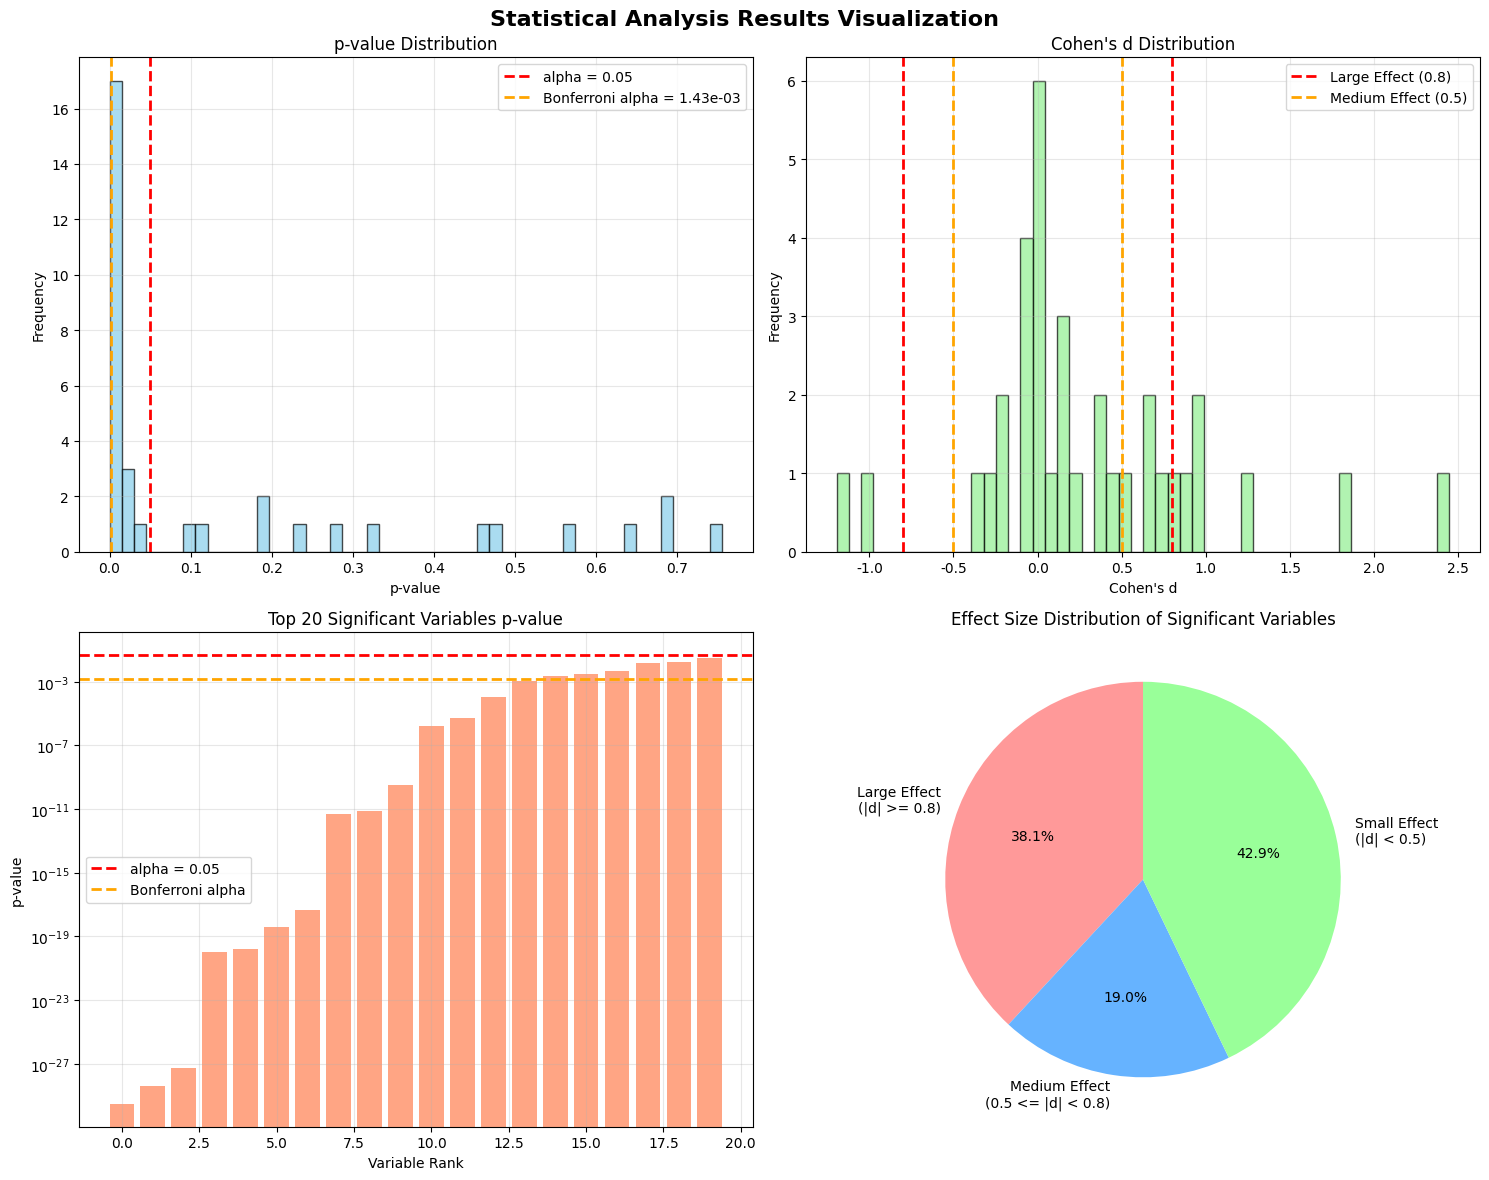


üèÜ Í∞ÄÏû• Ïú†ÏùòÌïú ÏÉÅÏúÑ 10Í∞ú Î≥ÄÏàò:
--------------------------------------------------------------------------------
ÏàúÏúÑ    Î≥ÄÏàòÎ™Ö                            p-value         Cohen d   
--------------------------------------------------------------------------------
1     Î°úÍ∑∏Ï¥ùÏûêÏÇ∞                          2.84e-30        0.936     
2     Ï¥ùÏûêÏÇ∞ÌöåÏ†ÑÏú®                         3.80e-29        0.797     
3     Ìà¨ÌïòÏûêÎ≥∏ÏàòÏùµÎ•†(ROIC)                  5.32e-28        0.946     
4     EV                             1.09e-20        0.112     
5     Ï¥ùÏûêÏÇ∞ÏàòÏùµÎ•†(ROA)                    1.70e-20        2.448     
6     ÌòÑÍ∏àÌùêÎ¶ÑÎåÄÎ∂ÄÏ±ÑÎπÑÏú®                      3.71e-19        0.671     
7     ÎÇ©ÏûÖÏûêÎ≥∏Í∏à                          4.49e-18        0.126     
8     Ï¥ùÏûêÏÇ∞Ï¶ùÍ∞ÄÏú®                         5.12e-12        0.736     
9     PER                            7.97e-12        0.165     
10    ÏûêÎ≥∏ÎπÑÏú®                           3.37e-10   

In [12]:
import pandas as pd
import numpy as np
from scipy import stats
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
df = pd.read_csv('../data/processed/FS2_filtered.csv')

print(f"üìä FS2_filtered.csv Ïª¨ÎüºÎ≥Ñ t-test Î∂ÑÏÑù")
print("=" * 60)
print(f"Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Í∞úÏàò: {df.shape[0]:,}Í∞ú")
print(f"Ï†ÑÏ≤¥ Ïª¨Îüº Ïàò: {df.shape[1]:,}Í∞ú")

# default Î∂ÑÌè¨ ÌôïÏù∏
default_counts = df['default'].value_counts()
print(f"\nüéØ ÌÉÄÍ≤ü Î≥ÄÏàò Î∂ÑÌè¨:")
print("-" * 30)
print(f"Ï†ïÏÉÅ Í∏∞ÏóÖ (default=0): {default_counts[0]:,}Í∞ú ({default_counts[0]/len(df)*100:.2f}%)")
print(f"Î∂ÄÎèÑ Í∏∞ÏóÖ (default=1): {default_counts[1]:,}Í∞ú ({default_counts[1]/len(df)*100:.2f}%)")

# Ï†ïÏÉÅ Í∏∞ÏóÖÍ≥º Î∂ÄÎèÑ Í∏∞ÏóÖ Í∑∏Î£π Î∂ÑÎ¶¨
normal_companies = df[df['default'] == 0]
default_companies = df[df['default'] == 1]

# ÏàòÏπòÌòï Ïª¨ÎüºÎßå ÏÑ†ÌÉù (Î¨∏ÏûêÏó¥ Ïª¨Îüº Ï†úÏô∏)
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
# ÌÉÄÍ≤ü Î≥ÄÏàòÏôÄ ÏãùÎ≥ÑÏûê Ïª¨Îüº Ï†úÏô∏
exclude_columns = ['default', 'ÌöåÍ≥ÑÎÖÑÎèÑ', 'Ïó∞ÎèÑ']
test_columns = [col for col in numeric_columns if col not in exclude_columns]

print(f"\nüî¨ t-test ÎåÄÏÉÅ Ïª¨Îüº Ïàò: {len(test_columns)}Í∞ú")
print("=" * 60)

# t-test Í≤∞Í≥º Ï†ÄÏû•Ïö© Î¶¨Ïä§Ìä∏
ttest_results = []

print(f"{'Ïª¨ÎüºÎ™Ö':<30} {'t-statistic':<15} {'p-value':<15} {'Ïú†ÏùòÏÑ±':<10} {'Ìö®Í≥ºÌÅ¨Í∏∞(Cohen d)':<15}")
print("-" * 90)

for column in test_columns:
    # Í≤∞Ï∏°Ïπò Ï†úÍ±∞
    normal_values = normal_companies[column].dropna()
    default_values = default_companies[column].dropna()
    
    # ÏµúÏÜå ÏÉòÌîå Ïàò ÌôïÏù∏ (Í∞Å Í∑∏Î£πÏóê ÏµúÏÜå 30Í∞ú Ïù¥ÏÉÅ)
    if len(normal_values) < 30 or len(default_values) < 30:
        continue
    
    # Welch's t-test (Îì±Î∂ÑÏÇ∞ Í∞ÄÏ†ïÌïòÏßÄ ÏïäÏùå)
    t_stat, p_value = stats.ttest_ind(normal_values, default_values, equal_var=False)
    
    # Cohen's d Í≥ÑÏÇ∞ (Ìö®Í≥º ÌÅ¨Í∏∞)
    pooled_std = np.sqrt(((len(normal_values)-1)*normal_values.var() + 
                         (len(default_values)-1)*default_values.var()) / 
                        (len(normal_values) + len(default_values) - 2))
    cohens_d = (normal_values.mean() - default_values.mean()) / pooled_std
    
    # Ïú†ÏùòÏÑ± ÌåêÎã®
    if p_value < 0.001:
        significance = "***"
    elif p_value < 0.01:
        significance = "**"
    elif p_value < 0.05:
        significance = "*"
    else:
        significance = ""
    
    # Í≤∞Í≥º Ï†ÄÏû•
    ttest_results.append({
        'column': column,
        't_statistic': t_stat,
        'p_value': p_value,
        'significance': significance,
        'cohens_d': cohens_d,
        'normal_mean': normal_values.mean(),
        'default_mean': default_values.mean(),
        'normal_std': normal_values.std(),
        'default_std': default_values.std()
    })
    
    # Ï∂úÎ†•
    print(f"{column:<30} {t_stat:<15.4f} {p_value:<15.6f} {significance:<10} {cohens_d:<15.4f}")

# Í≤∞Í≥º Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
results_df = pd.DataFrame(ttest_results)

# Ïú†ÏùòÌïú Î≥ÄÏàòÎì§ (p < 0.05) ÏöîÏïΩ
significant_vars = results_df[results_df['p_value'] < 0.05].sort_values('p_value')

print(f"\nüìà ÌÜµÍ≥ÑÏ†ÅÏúºÎ°ú Ïú†ÏùòÌïú Î≥ÄÏàò ÏöîÏïΩ (p < 0.05):")
print("=" * 60)
print(f"Ïú†ÏùòÌïú Î≥ÄÏàò Ïàò: {len(significant_vars)}Í∞ú / {len(results_df)}Í∞ú")
print()

# Ìö®Í≥º ÌÅ¨Í∏∞Î≥Ñ Î∂ÑÎ•ò
large_effect = significant_vars[abs(significant_vars['cohens_d']) >= 0.8]
medium_effect = significant_vars[(abs(significant_vars['cohens_d']) >= 0.5) & 
                                (abs(significant_vars['cohens_d']) < 0.8)]
small_effect = significant_vars[abs(significant_vars['cohens_d']) < 0.5]

print(f"üîç Ìö®Í≥º ÌÅ¨Í∏∞Î≥Ñ Î∂ÑÎ•ò:")
print(f"  ‚Ä¢ ÌÅ∞ Ìö®Í≥º (|Cohen's d| ‚â• 0.8): {len(large_effect)}Í∞ú")
print(f"  ‚Ä¢ Ï§ëÍ∞Ñ Ìö®Í≥º (0.5 ‚â§ |Cohen's d| < 0.8): {len(medium_effect)}Í∞ú")  
print(f"  ‚Ä¢ ÏûëÏùÄ Ìö®Í≥º (|Cohen's d| < 0.5): {len(small_effect)}Í∞ú")

# ÏÉÅÏúÑ 10Í∞ú Ïú†ÏùòÌïú Î≥ÄÏàò ÏÉÅÏÑ∏ Ï†ïÎ≥¥
print(f"\nüèÜ Í∞ÄÏû• Ïú†ÏùòÌïú ÏÉÅÏúÑ 10Í∞ú Î≥ÄÏàò:")
print("-" * 80)
print(f"{'ÏàúÏúÑ':<5} {'Ïª¨ÎüºÎ™Ö':<25} {'p-value':<12} {'Cohen d':<10} {'Ï†ïÏÉÅ ÌèâÍ∑†':<12} {'Î∂ÄÎèÑ ÌèâÍ∑†':<12}")
print("-" * 80)

for idx, row in significant_vars.head(10).iterrows():
    rank = list(significant_vars.index).index(idx) + 1
    print(f"{rank:<5} {row['column']:<25} {row['p_value']:<12.2e} {row['cohens_d']:<10.3f} "
          f"{row['normal_mean']:<12.2f} {row['default_mean']:<12.2f}")

# Bonferroni Î≥¥Ï†ï
bonferroni_alpha = 0.05 / len(results_df)
bonferroni_significant = results_df[results_df['p_value'] < bonferroni_alpha]

print(f"\nüéØ Bonferroni Î≥¥Ï†ï ÌõÑ Ïú†ÏùòÌïú Î≥ÄÏàò:")
print("-" * 40)
print(f"Î≥¥Ï†ïÎêú Ïú†ÏùòÏàòÏ§Ä: {bonferroni_alpha:.2e}")
print(f"Î≥¥Ï†ï ÌõÑ Ïú†ÏùòÌïú Î≥ÄÏàò Ïàò: {len(bonferroni_significant)}Í∞ú")

if len(bonferroni_significant) > 0:
    print("\nÎ≥¥Ï†ï ÌõÑÏóêÎèÑ Ïú†ÏùòÌïú Î≥ÄÏàòÎì§:")
    for _, row in bonferroni_significant.iterrows():
        print(f"  ‚Ä¢ {row['column']} (p={row['p_value']:.2e}, d={row['cohens_d']:.3f})")


# üìä ÏãúÍ∞ÅÌôî: ÌÜµÍ≥Ñ Î∂ÑÏÑù Í≤∞Í≥º 
print("\n" + "="*80)
print("üìä ÌÜµÍ≥Ñ Î∂ÑÏÑù Í≤∞Í≥º ÏãúÍ∞ÅÌôî")
print("="*80)

# ÌûàÏä§ÌÜ†Í∑∏Îû®ÏúºÎ°ú p-value Î∂ÑÌè¨ ÏãúÍ∞ÅÌôî
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Statistical Analysis Results Visualization', fontsize=16, fontweight='bold')

# 1. p-value Î∂ÑÌè¨ ÌûàÏä§ÌÜ†Í∑∏Îû®
axes[0, 0].hist(results_df['p_value'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='alpha = 0.05')
axes[0, 0].axvline(x=bonferroni_alpha, color='orange', linestyle='--', linewidth=2, label=f'Bonferroni alpha = {bonferroni_alpha:.2e}')
axes[0, 0].set_xlabel('p-value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('p-value Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Cohen's d Î∂ÑÌè¨ ÌûàÏä§ÌÜ†Í∑∏Îû®
axes[0, 1].hist(results_df['cohens_d'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].axvline(x=0.8, color='red', linestyle='--', linewidth=2, label='Large Effect (0.8)')
axes[0, 1].axvline(x=0.5, color='orange', linestyle='--', linewidth=2, label='Medium Effect (0.5)')
axes[0, 1].axvline(x=-0.5, color='orange', linestyle='--', linewidth=2)
axes[0, 1].axvline(x=-0.8, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel("Cohen's d")
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title("Cohen's d Distribution")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Ïú†ÏùòÌïú Î≥ÄÏàòÏùò p-value (ÏÉÅÏúÑ 20Í∞ú)
top_20_vars = significant_vars.head(20)
bars = axes[1, 0].bar(range(len(top_20_vars)), top_20_vars['p_value'], color='coral', alpha=0.7)
axes[1, 0].axhline(y=0.05, color='red', linestyle='--', linewidth=2, label='alpha = 0.05')
axes[1, 0].axhline(y=bonferroni_alpha, color='orange', linestyle='--', linewidth=2, label=f'Bonferroni alpha')
axes[1, 0].set_xlabel('Variable Rank')
axes[1, 0].set_ylabel('p-value')
axes[1, 0].set_title('Top 20 Significant Variables p-value')
axes[1, 0].set_yscale('log')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Ìö®Í≥º ÌÅ¨Í∏∞ Î∂ÑÌè¨ (ÌååÏù¥ Ï∞®Ìä∏)
effect_sizes = ['Large Effect\n(|d| >= 0.8)', 'Medium Effect\n(0.5 <= |d| < 0.8)', 'Small Effect\n(|d| < 0.5)']
effect_counts = [len(large_effect), len(medium_effect), len(small_effect)]
colors = ['#ff9999', '#66b3ff', '#99ff99']

axes[1, 1].pie(effect_counts, labels=effect_sizes, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Effect Size Distribution of Significant Variables')

plt.tight_layout()
plt.show()

# ÏÉÅÏúÑ Ïú†ÏùòÌïú Î≥ÄÏàòÎì§Ïùò ÏÉÅÏÑ∏ Ï†ïÎ≥¥ Ï∂úÎ†•
print(f"\nüèÜ Í∞ÄÏû• Ïú†ÏùòÌïú ÏÉÅÏúÑ 10Í∞ú Î≥ÄÏàò:")
print("-" * 80)
print(f"{'ÏàúÏúÑ':<5} {'Î≥ÄÏàòÎ™Ö':<30} {'p-value':<15} {'Cohen d':<10}")
print("-" * 80)

for idx, (_, row) in enumerate(significant_vars.head(10).iterrows(), 1):
    print(f"{idx:<5} {row['column']:<30} {row['p_value']:<15.2e} {row['cohens_d']:<10.3f}")

print(f"\nüîç ÏÉÅÏúÑ 10Í∞ú Ïú†ÏùòÌïú Î≥ÄÏàòÎ™Ö:")
print("-" * 50)
for idx, (_, row) in enumerate(significant_vars.head(10).iterrows(), 1):
    print(f"{idx:2d}. {row['column']}")

print(f"\n‚úÖ Î∂ÑÏÑù ÏôÑÎ£å!")
print(f"üìå ÏöîÏïΩ:")
print(f"   ‚Ä¢ Ï†ÑÏ≤¥ {len(results_df)}Í∞ú Î≥ÄÏàò Ï§ë {len(significant_vars)}Í∞úÍ∞Ä ÌÜµÍ≥ÑÏ†ÅÏúºÎ°ú Ïú†Ïùò")
print(f"   ‚Ä¢ Bonferroni Î≥¥Ï†ï ÌõÑÏóêÎèÑ Ïú†ÏùòÌïú Î≥ÄÏàò: {len(bonferroni_significant)}Í∞ú")


üìä X_train.csv Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú t-test Î∂ÑÏÑù
üìã Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú:
   ‚Ä¢ X_train: (17411, 34)
   ‚Ä¢ y_train: (17411, 1)

üìà ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨:
   ‚Ä¢ Ï†ïÏÉÅ Í∏∞ÏóÖ: 17282Í∞ú
   ‚Ä¢ Î∂ÄÏã§ Í∏∞ÏóÖ: 129Í∞ú
   ‚Ä¢ Î∂ÄÏã§ ÎπÑÏú®: 0.007

üî¨ t-test ÏßÑÌñâ Ï§ë...


Î≥ÄÏàòÎ≥Ñ t-test: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 34/34 [00:00<00:00, 686.52it/s]

‚úÖ t-test ÏôÑÎ£å! Ï¥ù 34Í∞ú Î≥ÄÏàò Î∂ÑÏÑù

üìä Ïú†ÏùòÏÑ± Î∂ÑÏÑù Í≤∞Í≥º:
   ‚Ä¢ Œ± = 0.05 Í∏∞Ï§Ä Ïú†ÏùòÌïú Î≥ÄÏàò: 25Í∞ú
   ‚Ä¢ Bonferroni Î≥¥Ï†ï ÌõÑ Ïú†ÏùòÌïú Î≥ÄÏàò: 17Í∞ú
   ‚Ä¢ Bonferroni Î≥¥Ï†ï Œ±: 0.001471

üéØ Ìö®Í≥º ÌÅ¨Í∏∞ Î∂ÑÏÑù:
   ‚Ä¢ ÌÅ∞ Ìö®Í≥º (|d| >= 0.8): 9Í∞ú
   ‚Ä¢ Ï§ëÍ∞Ñ Ìö®Í≥º (0.5 <= |d| < 0.8): 3Í∞ú
   ‚Ä¢ ÏûëÏùÄ Ìö®Í≥º (|d| < 0.5): 13Í∞ú


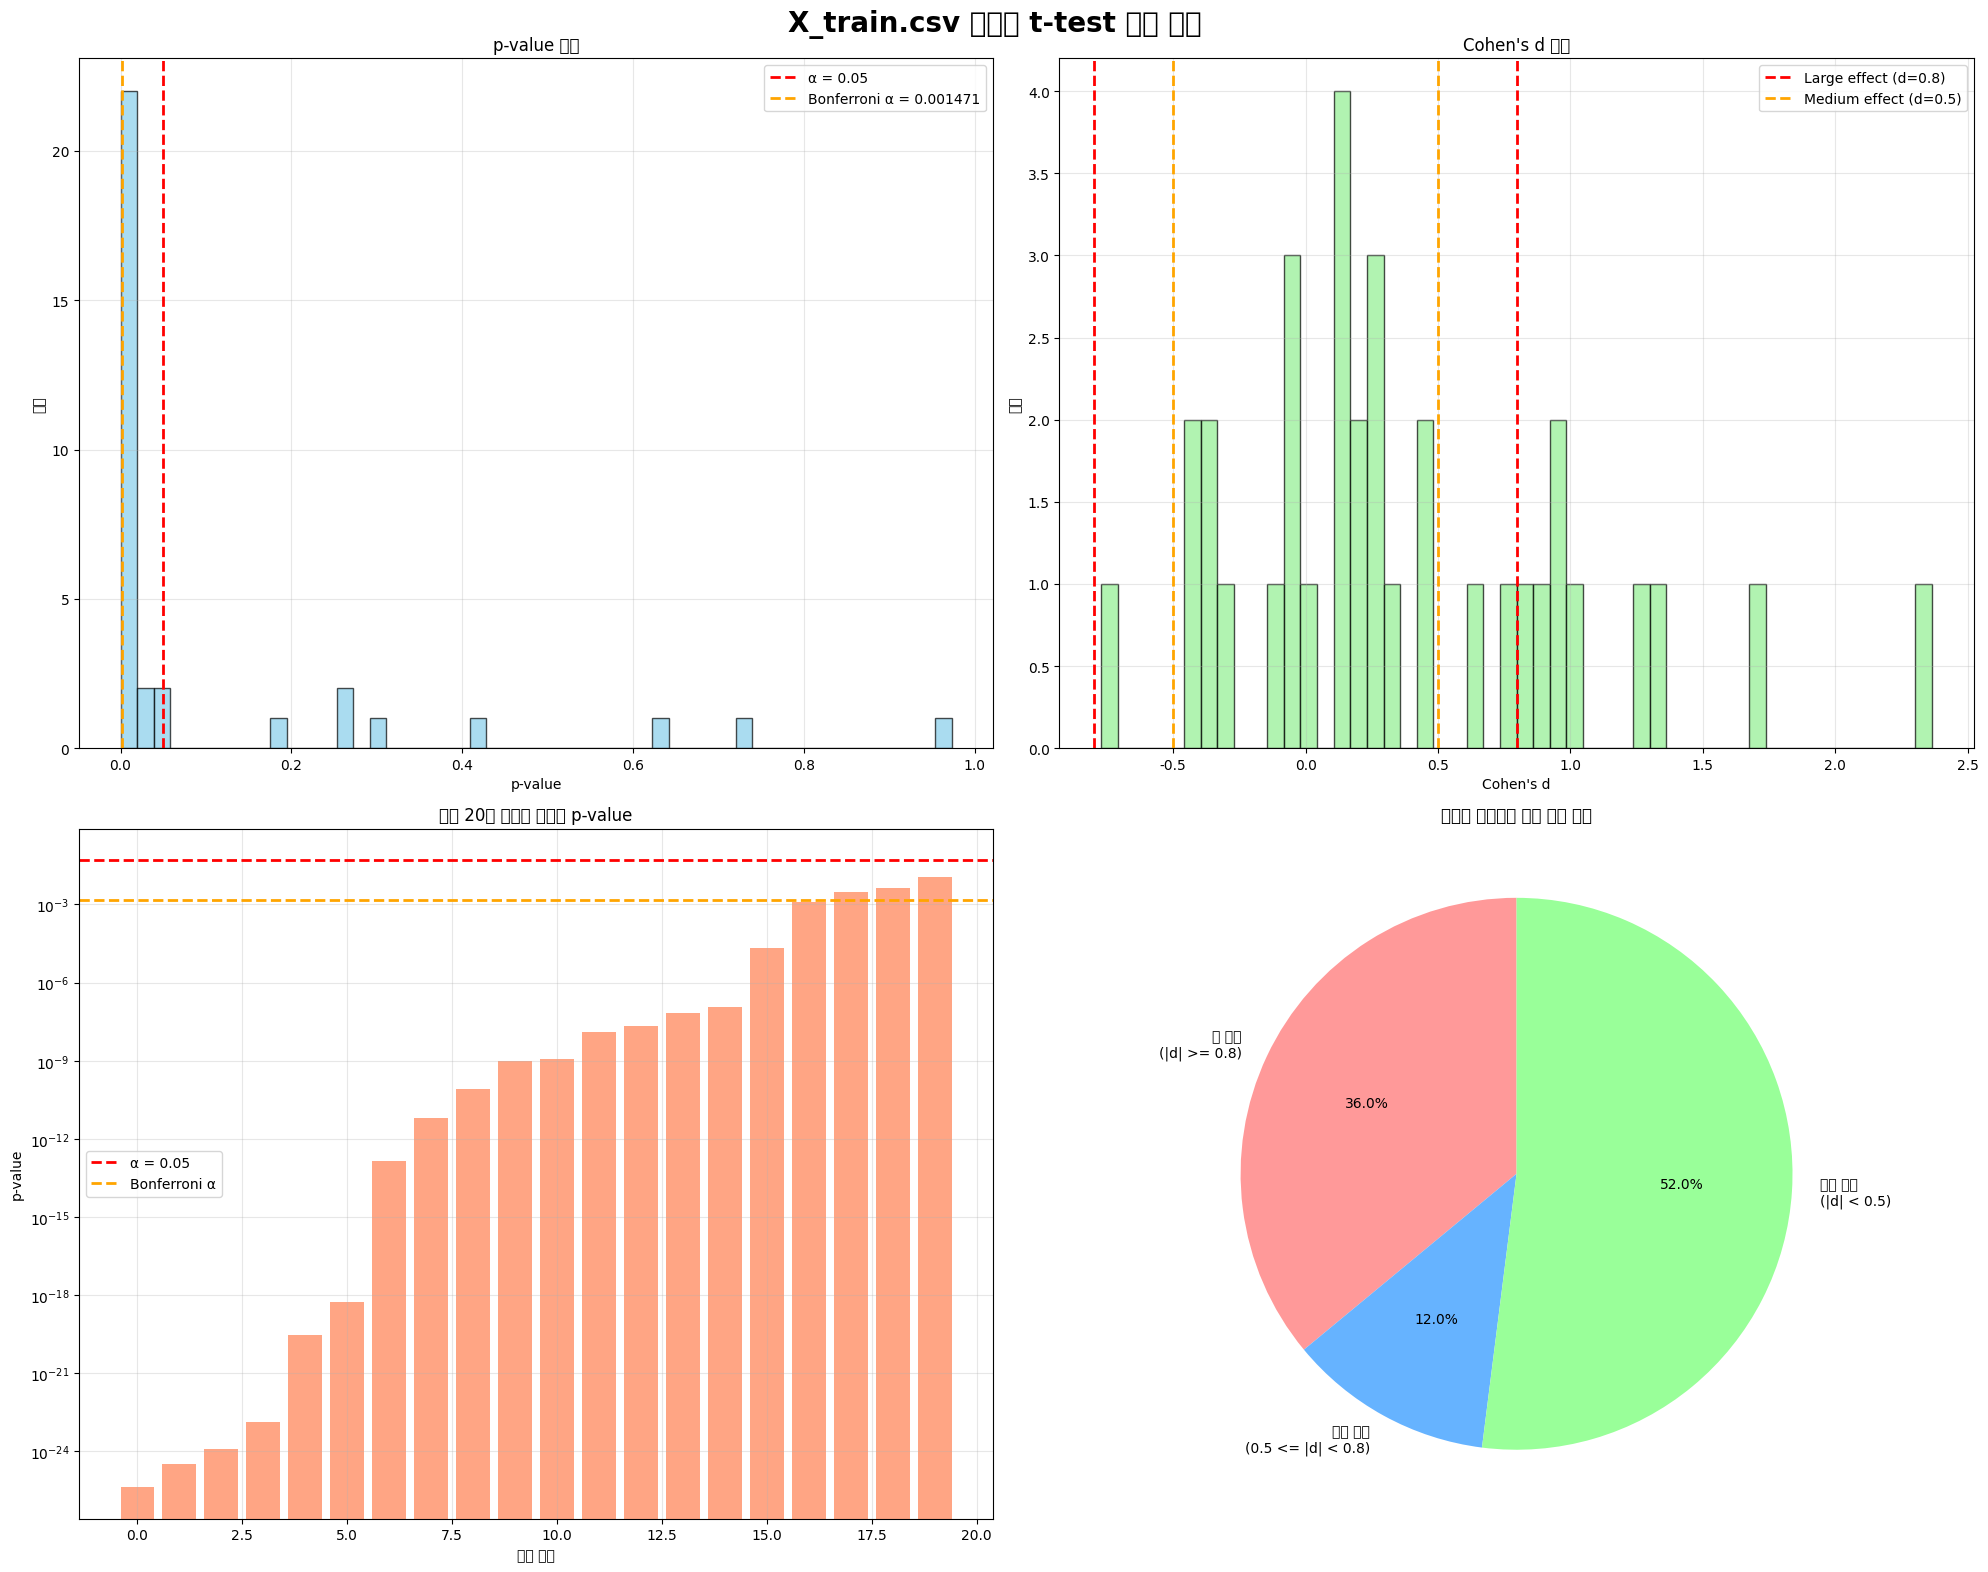


üèÜ Í∞ÄÏû• Ïú†ÏùòÌïú ÏÉÅÏúÑ 10Í∞ú Î≥ÄÏàò:
----------------------------------------------------------------------------------------------------
ÏàúÏúÑ    Î≥ÄÏàòÎ™Ö                            p-value         Cohen d    Ï†ïÏÉÅÌèâÍ∑†         Î∂ÄÏã§ÌèâÍ∑†        
----------------------------------------------------------------------------------------------------
1     Ï¥ùÏûêÏÇ∞ÏàòÏùµÎ•†(ROA)                    4.18e-26        2.366      0.004        -0.272      
2     Î°úÍ∑∏Ï¥ùÏûêÏÇ∞                          3.20e-25        0.896      26.197       24.876      
3     Ìà¨ÌïòÏûêÎ≥∏ÏàòÏùµÎ•†(ROIC)                  1.24e-24        1.321      0.032        -0.149      
4     Ï¥ùÏûêÏÇ∞ÌöåÏ†ÑÏú®                         1.40e-23        0.831      0.860        0.445       
5     ÌòÑÍ∏àÌùêÎ¶ÑÎåÄÎ∂ÄÏ±ÑÎπÑÏú®                      2.83e-20        0.743      0.159        -0.127      
6     ÏûêÎ≥∏ÎπÑÏú®                           5.39e-19        1.283      0.579        0.311       
7     ÏòÅÏóÖÏù¥ÏùµÎåÄÏ∞®

In [16]:
from tqdm import tqdm

# X_train.csv Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú t-test Î∂ÑÏÑù
print("=" * 80)
print("üìä X_train.csv Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú t-test Î∂ÑÏÑù")
print("=" * 80)

# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
X_train = pd.read_csv('../data/final/X_train.csv')
y_train = pd.read_csv('../data/final/y_train.csv')

print(f"üìã Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú:")
print(f"   ‚Ä¢ X_train: {X_train.shape}")
print(f"   ‚Ä¢ y_train: {y_train.shape}")

# y_trainÏùÑ 1Ï∞®Ïõê Î∞∞Ïó¥Î°ú Î≥ÄÌôò
y_train_values = y_train.iloc[:, 0].values if y_train.shape[1] == 1 else y_train['default'].values

# Î∂ÄÏã§ Í∏∞ÏóÖÍ≥º Ï†ïÏÉÅ Í∏∞ÏóÖ Íµ¨Î∂Ñ
normal_mask = y_train_values == 0
default_mask = y_train_values == 1

print(f"\nüìà ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨:")
print(f"   ‚Ä¢ Ï†ïÏÉÅ Í∏∞ÏóÖ: {normal_mask.sum()}Í∞ú")
print(f"   ‚Ä¢ Î∂ÄÏã§ Í∏∞ÏóÖ: {default_mask.sum()}Í∞ú")
print(f"   ‚Ä¢ Î∂ÄÏã§ ÎπÑÏú®: {default_mask.mean():.3f}")

# t-test ÏàòÌñâ
results_list = []

print(f"\nüî¨ t-test ÏßÑÌñâ Ï§ë...")
for col in tqdm(X_train.columns, desc="Î≥ÄÏàòÎ≥Ñ t-test"):
    # Ï†ïÏÉÅ Í∏∞ÏóÖÍ≥º Î∂ÄÏã§ Í∏∞ÏóÖÏùò Ìï¥Îãπ Î≥ÄÏàò Í∞í
    normal_values = X_train.loc[normal_mask, col].dropna()
    default_values = X_train.loc[default_mask, col].dropna()
    
    # Ïú†Ìö®Ìïú Í∞íÏù¥ Ï∂©Î∂ÑÌûà ÏûàÎäî Í≤ΩÏö∞ÏóêÎßå t-test ÏàòÌñâ
    if len(normal_values) >= 30 and len(default_values) >= 30:
        # Welch's t-test (Îì±Î∂ÑÏÇ∞ Í∞ÄÏ†ïÌïòÏßÄ ÏïäÏùå)
        t_stat, p_value = stats.ttest_ind(normal_values, default_values, equal_var=False)
        
        # Cohen's d Í≥ÑÏÇ∞
        pooled_std = np.sqrt(((len(normal_values) - 1) * normal_values.var() + 
                             (len(default_values) - 1) * default_values.var()) / 
                            (len(normal_values) + len(default_values) - 2))
        
        cohens_d = (normal_values.mean() - default_values.mean()) / pooled_std if pooled_std > 0 else 0
        
        # Í∏∞Ï¥à ÌÜµÍ≥ÑÎüâ
        normal_mean = normal_values.mean()
        default_mean = default_values.mean()
        normal_std = normal_values.std()
        default_std = default_values.std()
        
        results_list.append({
            'column': col,
            't_statistic': t_stat,
            'p_value': p_value,
            'cohens_d': cohens_d,
            'normal_mean': normal_mean,
            'default_mean': default_mean,
            'normal_std': normal_std,
            'default_std': default_std,
            'normal_count': len(normal_values),
            'default_count': len(default_values)
        })

# Í≤∞Í≥ºÎ•º DataFrameÏúºÎ°ú Î≥ÄÌôò
results_df = pd.DataFrame(results_list)

# p-value Í∏∞Ï§ÄÏúºÎ°ú Ï†ïÎ†¨
results_df = results_df.sort_values('p_value').reset_index(drop=True)

print(f"‚úÖ t-test ÏôÑÎ£å! Ï¥ù {len(results_df)}Í∞ú Î≥ÄÏàò Î∂ÑÏÑù")

# ÌÜµÍ≥ÑÏ†Å Ïú†ÏùòÏÑ± Î∂ÑÏÑù
alpha = 0.05
bonferroni_alpha = alpha / len(results_df)

significant_vars = results_df[results_df['p_value'] < alpha].copy()
bonferroni_significant = results_df[results_df['p_value'] < bonferroni_alpha].copy()

print(f"\nüìä Ïú†ÏùòÏÑ± Î∂ÑÏÑù Í≤∞Í≥º:")
print(f"   ‚Ä¢ Œ± = 0.05 Í∏∞Ï§Ä Ïú†ÏùòÌïú Î≥ÄÏàò: {len(significant_vars)}Í∞ú")
print(f"   ‚Ä¢ Bonferroni Î≥¥Ï†ï ÌõÑ Ïú†ÏùòÌïú Î≥ÄÏàò: {len(bonferroni_significant)}Í∞ú")
print(f"   ‚Ä¢ Bonferroni Î≥¥Ï†ï Œ±: {bonferroni_alpha:.6f}")

# Ìö®Í≥º ÌÅ¨Í∏∞ Î∂ÑÏÑù
large_effect = significant_vars[abs(significant_vars['cohens_d']) >= 0.8]
medium_effect = significant_vars[(abs(significant_vars['cohens_d']) >= 0.5) & 
                                (abs(significant_vars['cohens_d']) < 0.8)]
small_effect = significant_vars[abs(significant_vars['cohens_d']) < 0.5]

print(f"\nüéØ Ìö®Í≥º ÌÅ¨Í∏∞ Î∂ÑÏÑù:")
print(f"   ‚Ä¢ ÌÅ∞ Ìö®Í≥º (|d| >= 0.8): {len(large_effect)}Í∞ú")
print(f"   ‚Ä¢ Ï§ëÍ∞Ñ Ìö®Í≥º (0.5 <= |d| < 0.8): {len(medium_effect)}Í∞ú")
print(f"   ‚Ä¢ ÏûëÏùÄ Ìö®Í≥º (|d| < 0.5): {len(small_effect)}Í∞ú")

# ÏãúÍ∞ÅÌôî
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('X_train.csv Îç∞Ïù¥ÌÑ∞ t-test Î∂ÑÏÑù Í≤∞Í≥º', fontsize=20, fontweight='bold')

# 1. p-value ÌûàÏä§ÌÜ†Í∑∏Îû®
axes[0, 0].hist(results_df['p_value'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(x=alpha, color='red', linestyle='--', linewidth=2, label=f'Œ± = {alpha}')
axes[0, 0].axvline(x=bonferroni_alpha, color='orange', linestyle='--', linewidth=2, 
                   label=f'Bonferroni Œ± = {bonferroni_alpha:.6f}')
axes[0, 0].set_xlabel('p-value')
axes[0, 0].set_ylabel('ÎπàÎèÑ')
axes[0, 0].set_title("p-value Î∂ÑÌè¨")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Cohen's d Î∂ÑÌè¨
axes[0, 1].hist(results_df['cohens_d'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].axvline(x=0.8, color='red', linestyle='--', linewidth=2, label='Large effect (d=0.8)')
axes[0, 1].axvline(x=-0.8, color='red', linestyle='--', linewidth=2)
axes[0, 1].axvline(x=0.5, color='orange', linestyle='--', linewidth=2, label='Medium effect (d=0.5)')
axes[0, 1].axvline(x=-0.5, color='orange', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel("Cohen's d")
axes[0, 1].set_ylabel('ÎπàÎèÑ')
axes[0, 1].set_title("Cohen's d Î∂ÑÌè¨")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Ïú†ÏùòÌïú Î≥ÄÏàòÏùò p-value (ÏÉÅÏúÑ 20Í∞ú)
if len(significant_vars) > 0:
    top_20_vars = significant_vars.head(20)
    bars = axes[1, 0].bar(range(len(top_20_vars)), top_20_vars['p_value'], color='coral', alpha=0.7)
    axes[1, 0].axhline(y=alpha, color='red', linestyle='--', linewidth=2, label=f'Œ± = {alpha}')
    axes[1, 0].axhline(y=bonferroni_alpha, color='orange', linestyle='--', linewidth=2, 
                       label=f'Bonferroni Œ±')
    axes[1, 0].set_xlabel('Î≥ÄÏàò ÏàúÏúÑ')
    axes[1, 0].set_ylabel('p-value')
    axes[1, 0].set_title('ÏÉÅÏúÑ 20Í∞ú Ïú†ÏùòÌïú Î≥ÄÏàòÏùò p-value')
    axes[1, 0].set_yscale('log')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'Ïú†ÏùòÌïú Î≥ÄÏàòÍ∞Ä ÏóÜÏäµÎãàÎã§', ha='center', va='center', fontsize=16)
    axes[1, 0].set_title('ÏÉÅÏúÑ 20Í∞ú Ïú†ÏùòÌïú Î≥ÄÏàòÏùò p-value')

# 4. Ìö®Í≥º ÌÅ¨Í∏∞ Î∂ÑÌè¨ (ÌååÏù¥ Ï∞®Ìä∏)
effect_sizes = ['ÌÅ∞ Ìö®Í≥º\n(|d| >= 0.8)', 'Ï§ëÍ∞Ñ Ìö®Í≥º\n(0.5 <= |d| < 0.8)', 'ÏûëÏùÄ Ìö®Í≥º\n(|d| < 0.5)']
effect_counts = [len(large_effect), len(medium_effect), len(small_effect)]
colors = ['#ff9999', '#66b3ff', '#99ff99']

if sum(effect_counts) > 0:
    axes[1, 1].pie(effect_counts, labels=effect_sizes, colors=colors, autopct='%1.1f%%', startangle=90)
    axes[1, 1].set_title('Ïú†ÏùòÌïú Î≥ÄÏàòÎì§Ïùò Ìö®Í≥º ÌÅ¨Í∏∞ Î∂ÑÌè¨')
else:
    axes[1, 1].text(0.5, 0.5, 'Ïú†ÏùòÌïú Î≥ÄÏàòÍ∞Ä ÏóÜÏäµÎãàÎã§', ha='center', va='center', fontsize=16)
    axes[1, 1].set_title('Ïú†ÏùòÌïú Î≥ÄÏàòÎì§Ïùò Ìö®Í≥º ÌÅ¨Í∏∞ Î∂ÑÌè¨')

plt.tight_layout()
plt.show()

# ÏÉÅÏúÑ Ïú†ÏùòÌïú Î≥ÄÏàòÎì§Ïùò ÏÉÅÏÑ∏ Ï†ïÎ≥¥ Ï∂úÎ†•
if len(significant_vars) > 0:
    print(f"\nüèÜ Í∞ÄÏû• Ïú†ÏùòÌïú ÏÉÅÏúÑ 10Í∞ú Î≥ÄÏàò:")
    print("-" * 100)
    print(f"{'ÏàúÏúÑ':<5} {'Î≥ÄÏàòÎ™Ö':<30} {'p-value':<15} {'Cohen d':<10} {'Ï†ïÏÉÅÌèâÍ∑†':<12} {'Î∂ÄÏã§ÌèâÍ∑†':<12}")
    print("-" * 100)
    
    for idx, (_, row) in enumerate(significant_vars.head(10).iterrows(), 1):
        print(f"{idx:<5} {row['column']:<30} {row['p_value']:<15.2e} {row['cohens_d']:<10.3f} "
              f"{row['normal_mean']:<12.3f} {row['default_mean']:<12.3f}")
    
    print(f"\nüîç ÏÉÅÏúÑ 10Í∞ú Ïú†ÏùòÌïú Î≥ÄÏàòÎ™Ö:")
    print("-" * 50)
    for idx, (_, row) in enumerate(significant_vars.head(10).iterrows(), 1):
        print(f"{idx:2d}. {row['column']}")
else:
    print(f"\n‚ö†Ô∏è ÌÜµÍ≥ÑÏ†ÅÏúºÎ°ú Ïú†ÏùòÌïú Î≥ÄÏàòÍ∞Ä ÏóÜÏäµÎãàÎã§.")

print(f"\n‚úÖ X_train.csv Îç∞Ïù¥ÌÑ∞ t-test Î∂ÑÏÑù ÏôÑÎ£å!")
print(f"üìå ÏöîÏïΩ:")
print(f"   ‚Ä¢ Ï†ÑÏ≤¥ {len(results_df)}Í∞ú Î≥ÄÏàò Ï§ë {len(significant_vars)}Í∞úÍ∞Ä ÌÜµÍ≥ÑÏ†ÅÏúºÎ°ú Ïú†Ïùò")
print(f"   ‚Ä¢ Bonferroni Î≥¥Ï†ï ÌõÑÏóêÎèÑ Ïú†ÏùòÌïú Î≥ÄÏàò: {len(bonferroni_significant)}Í∞ú")
print(f"   ‚Ä¢ Î∂ÄÏã§ ÏòàÏ∏°Ïóê Í∞ÄÏû• Ï§ëÏöîÌïú Ïû¨Î¨¥ ÏßÄÌëúÎì§ÏùÑ ÏãùÎ≥ÑÌñàÏäµÎãàÎã§")


üìä FS2_filtered.csv Îç∞Ïù¥ÌÑ∞ÏÖã Î∂ÑÏÑù
Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Ïàò: 21,972Í∞ú
Ï†ïÏÉÅ Í∏∞ÏóÖ(default=0): 21,819Í∞ú
Î∂ÄÏã§ Í∏∞ÏóÖ(default=1): 153Í∞ú
Î∂ÄÏã§Î•†: 0.70%

Î∂ÑÏÑùÌï† Ï†ÑÏ≤¥ Ïû¨Î¨¥ÏßÄÌëú: 36Í∞ú


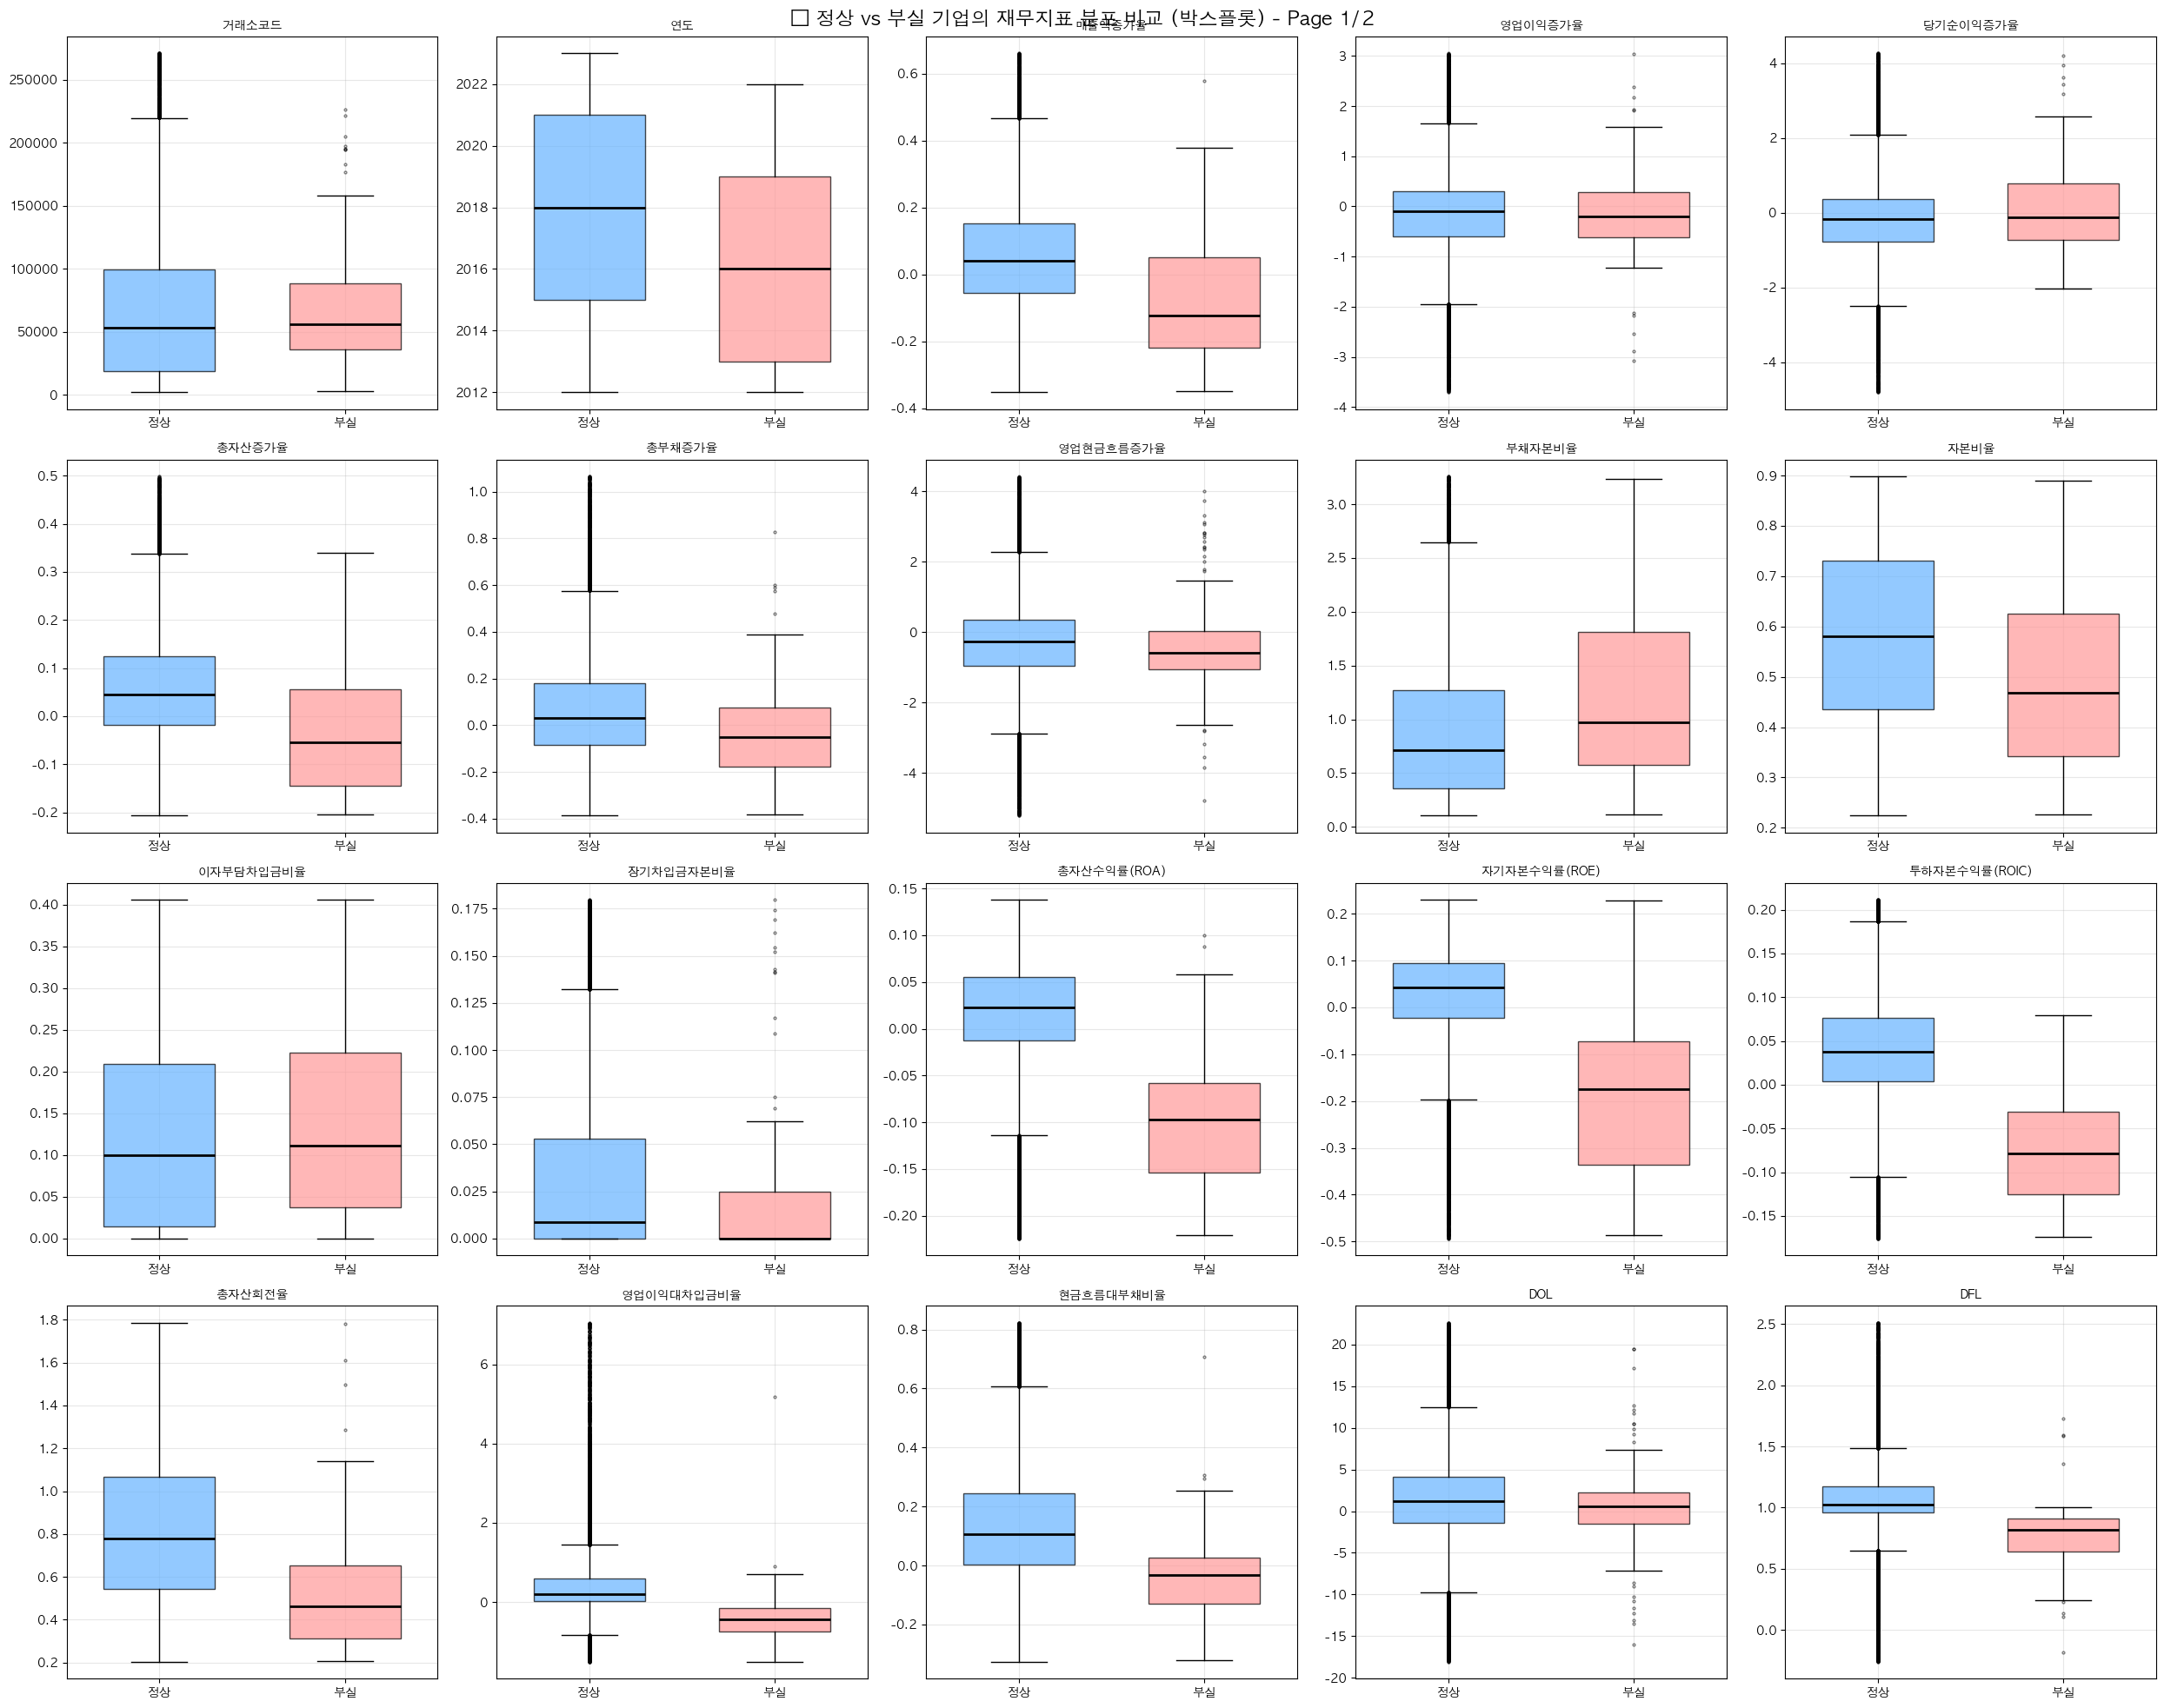

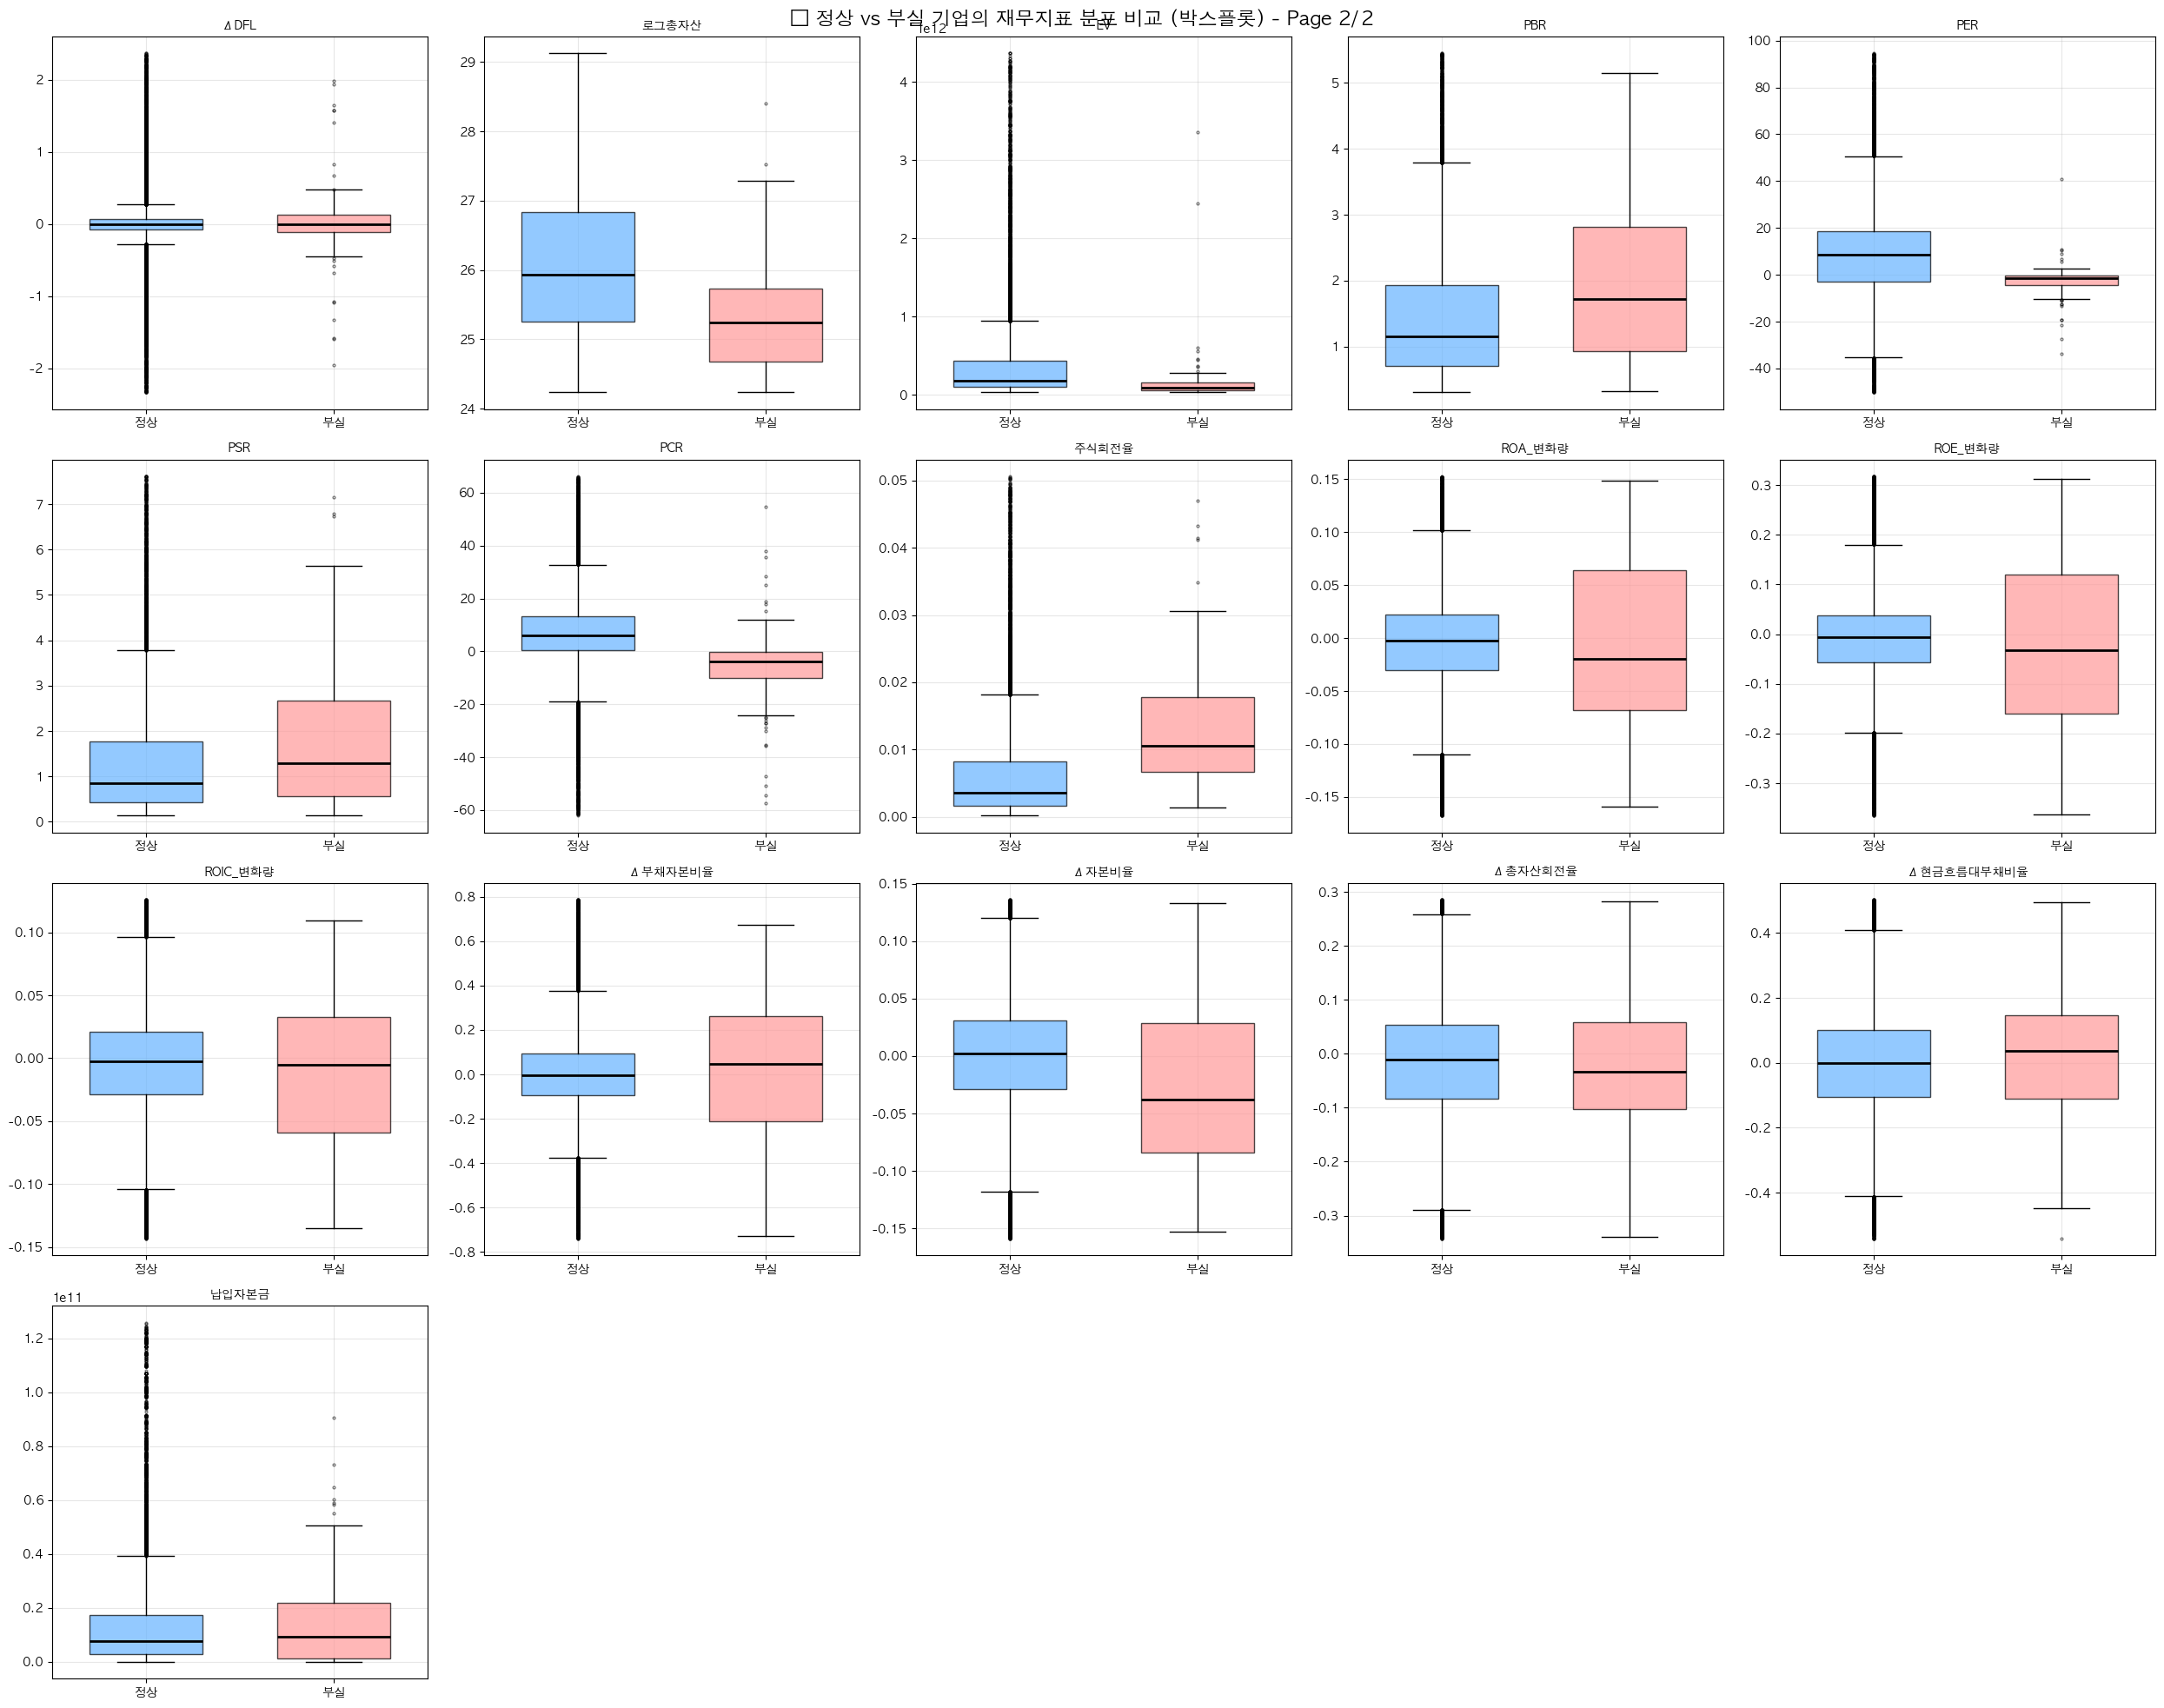


‚úÖ Ï†ÑÏ≤¥ 36Í∞ú Ïû¨Î¨¥ÏßÄÌëú Î∞ïÏä§ÌîåÎ°Ø Î∂ÑÏÑù ÏôÑÎ£å!
üìå 2Í∞ú ÌéòÏù¥ÏßÄÎ°ú Î∂ÑÌï†ÌïòÏó¨ Î™®Îì† Ïû¨Î¨¥ÏßÄÌëúÏùò Î∂ÑÌè¨ Ï∞®Ïù¥Î•º ÏãúÍ∞ÅÌôîÌñàÏäµÎãàÎã§.


In [6]:
# %% cell 52 code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
import platform
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# FS2_filtered.csv Îç∞Ïù¥ÌÑ∞Î°ú default=0, =1Ïóê Îî∞Î•∏ Ï∞®Ïù¥ ÏãúÍ∞ÅÌôî
# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
fs2_filtered = pd.read_csv('../data/processed/FS2_filtered.csv')

print("üìä FS2_filtered.csv Îç∞Ïù¥ÌÑ∞ÏÖã Î∂ÑÏÑù")
print(f"Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Ïàò: {len(fs2_filtered):,}Í∞ú")
print(f"Ï†ïÏÉÅ Í∏∞ÏóÖ(default=0): {(fs2_filtered['default'] == 0).sum():,}Í∞ú")
print(f"Î∂ÄÏã§ Í∏∞ÏóÖ(default=1): {(fs2_filtered['default'] == 1).sum():,}Í∞ú")
print(f"Î∂ÄÏã§Î•†: {(fs2_filtered['default'] == 1).mean()*100:.2f}%")

# Î™®Îì† ÏàòÏπòÌòï Ïû¨Î¨¥ÏßÄÌëú ÏÑ†ÌÉù
numeric_cols = fs2_filtered.select_dtypes(include=[np.number]).columns.tolist()
if 'default' in numeric_cols:
    numeric_cols.remove('default')

print(f"\nÎ∂ÑÏÑùÌï† Ï†ÑÏ≤¥ Ïû¨Î¨¥ÏßÄÌëú: {len(numeric_cols)}Í∞ú")

# Î∞ïÏä§ÌîåÎ°ØÏúºÎ°ú Î™®Îì† Ïû¨Î¨¥ÏßÄÌëú ÏãúÍ∞ÅÌôî
# Ìïú ÌéòÏù¥ÏßÄÏóê ÌëúÏãúÌï† Ïàò ÏûàÎäî Ï†ÅÏ†àÌïú ÌÅ¨Í∏∞Î°ú Î∂ÑÌï†
charts_per_page = 20
total_pages = (len(numeric_cols) + charts_per_page - 1) // charts_per_page

for page in range(total_pages):
    start_idx = page * charts_per_page
    end_idx = min((page + 1) * charts_per_page, len(numeric_cols))
    current_indicators = numeric_cols[start_idx:end_idx]
    
    # ÏÑúÎ∏åÌîåÎ°Ø Î∞∞Ïπò Í≥ÑÏÇ∞
    n_cols = 5
    n_rows = (len(current_indicators) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for i, indicator in enumerate(current_indicators):
        # Ïù¥ÏÉÅÏπò Ï†úÍ±∞Î•º ÏúÑÌïú IQR Í∏∞Î∞ò ÌïÑÌÑ∞ÎßÅ
        Q1 = fs2_filtered[indicator].quantile(0.05)
        Q3 = fs2_filtered[indicator].quantile(0.95)
        
        filtered_data = fs2_filtered[
            (fs2_filtered[indicator] >= Q1) & 
            (fs2_filtered[indicator] <= Q3)
        ]
        
        # Î∞ïÏä§ÌîåÎ°ØÏùÑ ÏúÑÌïú Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
        data_normal = filtered_data[filtered_data['default'] == 0][indicator].dropna()
        data_default = filtered_data[filtered_data['default'] == 1][indicator].dropna()
        
        if len(data_normal) > 0 and len(data_default) > 0:
            # Î∞ïÏä§ÌîåÎ°Ø Í∑∏Î¶¨Í∏∞
            box_data = [data_normal, data_default]
            box_plot = axes[i].boxplot(box_data, 
                                     positions=[1, 2], 
                                     widths=0.6,
                                     patch_artist=True,
                                     showfliers=True,
                                     flierprops=dict(marker='o', markersize=2, alpha=0.5))
            
            # ÏÉâÏÉÅ ÏÑ§Ï†ï
            box_plot['boxes'][0].set_facecolor('#66b3ff')
            box_plot['boxes'][1].set_facecolor('#ff9999')
            box_plot['boxes'][0].set_alpha(0.7)
            box_plot['boxes'][1].set_alpha(0.7)
            
            # Ï§ëÏïôÍ∞í ÏÑ† ÏÉâÏÉÅ ÏÑ§Ï†ï
            for median in box_plot['medians']:
                median.set_color('black')
                median.set_linewidth(2)
            
            axes[i].set_xticks([1, 2])
            axes[i].set_xticklabels(['Ï†ïÏÉÅ', 'Î∂ÄÏã§'])
            axes[i].set_title(f'{indicator}', fontsize=10, fontweight='bold')
            axes[i].grid(True, alpha=0.3)
        else:
            axes[i].text(0.5, 0.5, 'Data Î∂ÄÏ°±', ha='center', va='center', fontsize=12)
            axes[i].set_title(f'{indicator}', fontsize=10, fontweight='bold')
    
    # ÎÇ®ÏùÄ subplot Ï†úÍ±∞
    for i in range(len(current_indicators), len(axes)):
        fig.delaxes(axes[i])
    
    plt.suptitle(f'üì¶ Ï†ïÏÉÅ vs Î∂ÄÏã§ Í∏∞ÏóÖÏùò Ïû¨Î¨¥ÏßÄÌëú Î∂ÑÌè¨ ÎπÑÍµê (Î∞ïÏä§ÌîåÎ°Ø) - Page {page+1}/{total_pages}', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

print(f"\n‚úÖ Ï†ÑÏ≤¥ {len(numeric_cols)}Í∞ú Ïû¨Î¨¥ÏßÄÌëú Î∞ïÏä§ÌîåÎ°Ø Î∂ÑÏÑù ÏôÑÎ£å!")
print(f"üìå {total_pages}Í∞ú ÌéòÏù¥ÏßÄÎ°ú Î∂ÑÌï†ÌïòÏó¨ Î™®Îì† Ïû¨Î¨¥ÏßÄÌëúÏùò Î∂ÑÌè¨ Ï∞®Ïù¥Î•º ÏãúÍ∞ÅÌôîÌñàÏäµÎãàÎã§.")


# Î≤†Ïù¥Ïä§ÎùºÏù∏ Î™®Îç∏ÎßÅ

In [72]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Baseline logistic-regression pipeline
data path : ../data/final/
output    : metrics + logreg_model.pkl
"""
import os
import joblib
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score,
                             roc_auc_score, confusion_matrix,
                             classification_report)
from sklearn.preprocessing import RobustScaler

# ------------------------------------------------------------------
# 1. ÌååÏùº Í≤ΩÎ°ú ÏÑ§Ï†ï
# ------------------------------------------------------------------
DATA_DIR = os.path.join(os.getcwd(), '..', 'data', 'final')

X_train = pd.read_csv(os.path.join(DATA_DIR, 'X_train.csv'))
X_valid = pd.read_csv(os.path.join(DATA_DIR, 'X_val.csv'))
X_test  = pd.read_csv(os.path.join(DATA_DIR, 'X_test.csv'))

y_train = pd.read_csv(os.path.join(DATA_DIR, 'y_train.csv')).squeeze()
y_valid = pd.read_csv(os.path.join(DATA_DIR, 'y_val.csv')).squeeze()
y_test  = pd.read_csv(os.path.join(DATA_DIR, 'y_test.csv' )).squeeze()

# ------------------------------------------------------------------
# 2. ÌååÏù¥ÌîÑÎùºÏù∏: ÌëúÏ§ÄÌôî + Î°úÏßÄÏä§Ìã± ÌöåÍ∑Ä
# ------------------------------------------------------------------
pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('clf',    LogisticRegression(max_iter=100000, penalty='l2', solver='saga'))
])

# ------------------------------------------------------------------
# 3. ÌïôÏäµ & Í≤ÄÏ¶ù
# ------------------------------------------------------------------
pipe.fit(X_train, y_train)

y_pred_valid = pipe.predict(X_valid)
y_prob_valid = pipe.predict_proba(X_valid)[:, 1]

print("\n[ Validation Set ]")
print("Accuracy :", accuracy_score(y_valid, y_pred_valid))
print("F1-score :", f1_score(y_valid, y_pred_valid))
print("ROC AUC  :", roc_auc_score(y_valid, y_prob_valid))
print("\nConfusion Matrix\n", confusion_matrix(y_valid, y_pred_valid))
print("\nClassification Report\n", classification_report(y_valid, y_pred_valid))

# ------------------------------------------------------------------
# 4. ÌÖåÏä§Ìä∏ ÏÑ±Í≥º
# ------------------------------------------------------------------
y_pred_test = pipe.predict(X_test)
y_prob_test = pipe.predict_proba(X_test)[:, 1]

print("\n[ Test Set ]")
print("Accuracy :", accuracy_score(y_test, y_pred_test))
print("F1-score :", f1_score(y_test, y_pred_test))
print("ROC AUC  :", roc_auc_score(y_test, y_prob_test))
print("\nConfusion Matrix\n", confusion_matrix(y_test, y_pred_test))
print("\nClassification Report\n", classification_report(y_test, y_pred_test))



[ Validation Set ]
Accuracy : 0.9915766343160594
F1-score : 0.17857142857142858
ROC AUC  : 0.9141117233016107

Confusion Matrix
 [[5410    9]
 [  37    5]]

Classification Report
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      5419
           1       0.36      0.12      0.18        42

    accuracy                           0.99      5461
   macro avg       0.68      0.56      0.59      5461
weighted avg       0.99      0.99      0.99      5461


[ Test Set ]
Accuracy : 0.9932445111653219
F1-score : 0.25
ROC AUC  : 0.9202371143458757

Confusion Matrix
 [[5287    9]
 [  27    6]]

Classification Report
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      5296
           1       0.40      0.18      0.25        33

    accuracy                           0.99      5329
   macro avg       0.70      0.59      0.62      5329
weighted avg       0.99      0.99      0.99      5329



In [69]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Baseline Random-Forest pipeline
data path : ../data/final/
output    : metrics + rf_model.pkl
"""
import os
import joblib
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score,
                             roc_auc_score, confusion_matrix,
                             classification_report)

# -----------------------------------------------------------
# 1. ÌååÏùº Í≤ΩÎ°ú ÏÑ§Ï†ï
# -----------------------------------------------------------
DATA_DIR = os.path.join(os.getcwd(), '..', 'data', 'final')

X_train = pd.read_csv(os.path.join(DATA_DIR, 'X_train.csv'))
X_valid = pd.read_csv(os.path.join(DATA_DIR, 'X_val.csv'))
X_test  = pd.read_csv(os.path.join(DATA_DIR, 'X_test.csv'))

y_train = pd.read_csv(os.path.join(DATA_DIR, 'y_train.csv')).squeeze()
y_valid = pd.read_csv(os.path.join(DATA_DIR, 'y_val.csv')).squeeze()
y_test  = pd.read_csv(os.path.join(DATA_DIR, 'y_test.csv' )).squeeze()


# -----------------------------------------------------------
# 2. Random-Forest Î™®Îç∏ Ï†ïÏùò
#    (Í∏∞Î≥∏ ÌååÎùºÎØ∏ÌÑ∞ + reproducibilityÏö© random_state)
# -----------------------------------------------------------
rf_clf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=7,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'      # Î∂àÍ∑†Ìòï Îç∞Ïù¥ÌÑ∞ ÎåÄÎπÑ
)

# -----------------------------------------------------------
# 3. ÌïôÏäµ & Í≤ÄÏ¶ù
# -----------------------------------------------------------
rf_clf.fit(X_train, y_train)

y_pred_valid = rf_clf.predict(X_valid)
y_prob_valid = rf_clf.predict_proba(X_valid)[:, 1]

print("\n[ Validation Set ]")
print("Accuracy :", accuracy_score(y_valid, y_pred_valid))
print("F1-score :", f1_score(y_valid, y_pred_valid))
print("ROC AUC  :", roc_auc_score(y_valid, y_prob_valid))
print("\nConfusion Matrix\n", confusion_matrix(y_valid, y_pred_valid))
print("\nClassification Report\n", classification_report(y_valid, y_pred_valid))

# -----------------------------------------------------------
# 4. ÌÖåÏä§Ìä∏ ÏÑ±Í≥º
# -----------------------------------------------------------
y_pred_test = rf_clf.predict(X_test)
y_prob_test = rf_clf.predict_proba(X_test)[:, 1]

print("\n[ Test Set ]")
print("Accuracy :", accuracy_score(y_test, y_pred_test))
print("F1-score :", f1_score(y_test, y_pred_test))
print("ROC AUC  :", roc_auc_score(y_test, y_prob_test))


[ Validation Set ]
Accuracy : 0.9769273026918147
F1-score : 0.17105263157894737
ROC AUC  : 0.9287208147699013

Confusion Matrix
 [[5322   97]
 [  29   13]]

Classification Report
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      5419
           1       0.12      0.31      0.17        42

    accuracy                           0.98      5461
   macro avg       0.56      0.65      0.58      5461
weighted avg       0.99      0.98      0.98      5461


[ Test Set ]
Accuracy : 0.9836742353161944
F1-score : 0.2809917355371901
ROC AUC  : 0.9334231667124415


In [71]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Robust XGBoost baseline  ‚Äì tries early_stopping_rounds, falls back if unsupported
"""
import os, joblib, pandas as pd, xgboost as xgb
from sklearn.metrics import (accuracy_score, f1_score,
                             roc_auc_score, confusion_matrix,
                             classification_report)

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
DATA_DIR = os.path.join(os.getcwd(), '..', 'data', 'final')

X_train = pd.read_csv(os.path.join(DATA_DIR, 'X_train.csv'))
X_val   = pd.read_csv(os.path.join(DATA_DIR, 'X_val.csv'))
X_test  = pd.read_csv(os.path.join(DATA_DIR, 'X_test.csv'))

y_train = pd.read_csv(os.path.join(DATA_DIR, 'y_train.csv')).squeeze()
y_val   = pd.read_csv(os.path.join(DATA_DIR, 'y_val.csv')).squeeze()
y_test  = pd.read_csv(os.path.join(DATA_DIR, 'y_test.csv')).squeeze()

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 2. Î™®Îç∏ Ï†ïÏùò ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
xgb_clf = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    objective="binary:logistic",
    eval_metric="auc"
)

eval_set = [(X_val, y_val)]

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 3. fit (try ‚Üí fallback) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
try:
    # 1st attempt: Íµ¨Î≤ÑÏ†Ñ(‚â§1.x) Ïä§ÌÉÄÏùº
    xgb_clf.fit(
        X_train, y_train,
        eval_set=eval_set,
        early_stopping_rounds=50,
        verbose=False
    )
except TypeError:
    try:
        # 2nd attempt: Ïã†Î≤ÑÏ†Ñ(‚â•2.x) - keywordÏóÜÏù¥ Ìò∏Ï∂ú
        xgb_clf.fit(
            X_train, y_train,
            eval_set=eval_set,
            verbose=False
        )
    except TypeError as e:
        raise RuntimeError(f"XGBoost fit failed: {e}")

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 4. ÌèâÍ∞Ä Ìï®Ïàò ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
def evaluate(tag, X, y):
    y_hat  = xgb_clf.predict(X)
    y_prob = xgb_clf.predict_proba(X)[:, 1]
    print(f"\n[{tag}]")
    print("Accuracy :", accuracy_score(y, y_hat))
    print("F1-score :", f1_score(y, y_hat))
    print("ROC AUC  :", roc_auc_score(y, y_prob))
    print("Confusion Matrix\n", confusion_matrix(y, y_hat))
    print(classification_report(y, y_hat))

evaluate("Validation", X_val,  y_val)
evaluate("Test",        X_test, y_test)

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 5. Î™®Îç∏ Ï†ÄÏû• ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# xgb_clf.save_model("xgb_model.json")
# joblib.dump(xgb_clf,   "xgb_model.pkl")
# print("\nModel saved ‚ûú  xgb_model.json  &  xgb_model.pkl")



[Validation]
Accuracy : 0.9923091008972715
F1-score : 0.08695652173913043
ROC AUC  : 0.9483167690401497
Confusion Matrix
 [[5417    2]
 [  40    2]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5419
           1       0.50      0.05      0.09        42

    accuracy                           0.99      5461
   macro avg       0.75      0.52      0.54      5461
weighted avg       0.99      0.99      0.99      5461


[Test]
Accuracy : 0.9928692062300619
F1-score : 0.09523809523809523
ROC AUC  : 0.9245285178064635
Confusion Matrix
 [[5289    7]
 [  31    2]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5296
           1       0.22      0.06      0.10        33

    accuracy                           0.99      5329
   macro avg       0.61      0.53      0.55      5329
weighted avg       0.99      0.99      0.99      5329

